In [1]:
link = 'D:/users/Marko/downloads/mirna/'

# Imports

In [2]:
%load_ext tensorboard

In [3]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf

import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

import datetime


writer = SummaryWriter(f"{link}/saved_models/new/CIMVAE1/tensorboard")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

# Model Classes

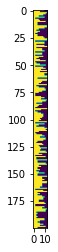

In [6]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[0])

In [7]:
stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].to(DEVICE).float()

In [8]:
stamp.shape

torch.Size([1, 14, 13])

In [9]:
a = torch.arange(13)[None, :] < torch.randint(2,14,(64,200))[:,:, None]

In [10]:
torch.arange(13)[None, :].shape, torch.randint(2,14,(64,200))[:,:, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [11]:
tens1 = torch.tensor([[1.,0,0,0,0]])
tens2 = torch.tensor([[.9,0,0,0,0]])
tens3 = torch.tensor([[0.,0,0,0,0]])

In [12]:
print(F.cross_entropy(tens1, tens1, reduction='sum'))
print(F.cross_entropy(tens1, tens2, reduction='sum'))
print(F.cross_entropy(tens3, tens2, reduction='sum'))

tensor(0.9048)
tensor(0.8143)
tensor(1.4485)


In [13]:
a = a.reshape(-1,2,100,13)

In [14]:
b = a[:,0,:,:].flip(2)
c = torch.cat([b,a[:,1,:,:12]], 2).permute(0,2,1)[:,None].repeat(1,3,1,1)

In [15]:
d = torch.randint(0,2,(64,3,2,100))

In [16]:
e = d[:,:,0,None,:].repeat(1,1,13,1)
f = d[:,:,1,None,:].repeat(1,1,12,1)
g = torch.cat([e,f],2)

In [17]:
g.shape, c.shape

(torch.Size([64, 3, 25, 100]), torch.Size([64, 3, 25, 100]))

In [18]:
x = torch.tensor([[0.03,0.37,.1,0.4,0.1]])
y = torch.tensor([[0,0,0,0,0],
                 [1,0,0,0,0],
                 [1,1,0,0,0],
                 [1,1,1,0,0],
                 [1,1,1,1,1],
                 ])

In [19]:
x.shape, y.shape

(torch.Size([1, 5]), torch.Size([5, 5]))

In [20]:
x_test = F.one_hot(torch.randint(0,13,(64,200)), num_classes=13)
x_test.shape

torch.Size([64, 200, 13])

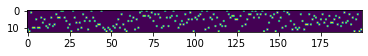

In [21]:
plt.imshow(x_test[0].T)

In [22]:
y_test = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].repeat(64,1,1)
y_test.shape

torch.Size([64, 13, 13])

In [23]:
tst = torch.bmm(x_test,y_test)
tst.shape

torch.Size([64, 200, 13])

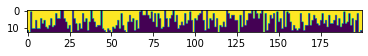

In [24]:
plt.imshow(tst[0].T)

In [25]:
x2 = torch.randint(0,2,(64,200,13))
y2 = torch.ones((64,13,13))

In [26]:
x2.T.shape

D:\Users\Marko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  """Entry point for launching an IPython kernel.


torch.Size([13, 200, 64])

In [27]:
#torch.bmm(x2,y2).shape

In [28]:
im = c*g+(~c)

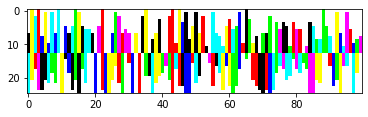

In [29]:
plt.imshow((im[0].permute(1,2,0)*255))

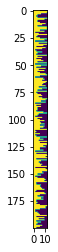

In [30]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[1])

In [31]:
torch.arange(13)[None, :].shape , torch.randint(2,14,(64,200))[:, :, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [32]:
class diva_args:

    def __init__(self, z_dim=128, d_dim=45, x_dim=7500, y_dim=2,
                 beta=1, rec = 1,
                 warmup = 1, prewarmup = 1):

        self.z_dim = z_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        
        self.beta = beta
        self.rec = rec
        self.warmup = warmup
        self.prewarmup = prewarmup


## Dataset Class

In [33]:
class MicroRNADataset(Dataset):

    def __init__(self, ds='train', create_encodings=False, use_subset=False):
        
        # loading images
        self.images = np.load(f'{link}/data/modmirbase_{ds}_images.npz')['arr_0']/255
        
        
        if create_encodings:
            x_cat = self.get_encoded_values(self.images, ds)
        else:
            x_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cattt.npz')['arr_0']
        #self.images_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cat_new.npz')
        
        self.images_cat = x_cat
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'{link}/data/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        self.mountain = np.load(f'{link}/data/modmirbase_{ds}_mountain.npy')
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'{link}/data/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        
       
        
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
            
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        x_cat = self.images_cat[idx]
        return (x_cat, y, d, x)


    def get_encoded_values(self, x, ds):
        """
        given an image or batch of images
        returns length of strand, length of bars and colors of bars
        """
        n = x.shape[0]
        x = np.transpose(x, (0,3,1,2))
        x_cat = np.zeros((n, 5, 25, 100), dtype=np.uint8)
        
        for i in range(n):
            if i % 100 == 0:
                print(f'at {i} out of {n}')
            for j in range(100):
                if (x[i,:,12,j] == np.array([1,1,1])).all():
                    break
                else:
                    # loop through all pixels of the bar
                    for k in range(25):
                        if (x[i,:,k,j] == np.array([1,1,1])).all():
                            continue
                        else:
                            x_cat[i,self.get_color(x[i,:,k,j]),k,j] = 1

        np.savez_compressed(f'{link}/data/modmirbase_{ds}_images_cattt.npz', x_cat)
        #with open(f'{link}/data/modmirbase_{ds}_images_cattt.npz', 'wb') as f:
        #    np.save(f, out_len)
        

        return x_cat

        
    
    def get_color(self, pixel):
        """
        returns the encoded value for a pixel
        """
        if (pixel == np.array([0,0,0])).all():  
            return 0 # black
        elif (pixel == np.array([1,0,0])).all():  
            return 1 # red
        elif (pixel == np.array([0,0,1])).all():  
            return 2 # blue
        elif (pixel == np.array([0,1,0])).all():  
            return 3 # green
        elif (pixel == np.array([1,1,0])).all():  
            return 4 # yellow
        else:
            print("Something wrong!")


## Decoder classes

In [34]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, dim1=256, dim2=512):
        super(px, self).__init__()

        self.fc = nn.Sequential(nn.Linear(z_dim, dim2),  
                                nn.ReLU(),
                                nn.Dropout(.2),
                                nn.Linear(dim2, dim2),
                                nn.Dropout(.5),
                                nn.ReLU())
        
        # Predicting length and color of each bar
        
        self.color = nn.Sequential(nn.Linear(dim2, 1000))
        
        
        self.length_bar = nn.Sequential(nn.Linear(dim2,2800))
        
        # monster
        self.stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                 ])[None,:].to(DEVICE).float()
        
        
        
    def forward(self, z):
        
        h = self.fc(z)
        
        
        len_bar = self.length_bar(h).reshape(-1,14,200)
        len_bar_ = nn.Softmax(dim=1)(len_bar)
        len_bar = len_bar_.permute(0,2,1)
        len_bar = torch.bmm(len_bar, self.stamp.repeat(len_bar.shape[0],1,1))
        #len_bar = len_bar.reshape(-1,2,100,13)
        msk2 = len_bar[:,:100,:12]
        msk1 = len_bar[:,100:,:].flip(2)
        bars = torch.cat([msk1,msk2], 2).permute(0,2,1)[:,None]
        bars2 = bars.repeat(1,5,1,1)
        
        col = nn.Softmax(dim=1)(self.color(h).reshape(-1,5,2,100))
        col_top = col[:,:,0,None,:].repeat(1,1,13,1)
        col_bot = col[:,:,1,None,:].repeat(1,1,12,1)
        color = torch.cat([col_top,col_bot],2)
        
        rna = color*bars2
        
        return rna, col, len_bar_
    
    def sample(self, color, len_bar, mean=True):
        
        if mean:
            bars = torch.argmax(len_bar, dim=1)
            bars = torch.where(bars>0, bars+1, bars)
            col = torch.argmax(color, dim=1)
        else:
            bars = dist.Categorical(len_bar).sample()
            bars = torch.where(bars>0, bars+1, bars)
            col = dist.Categorical(color).sample()
        out = torch.ones((color.shape[0], 25, 100 ,3))
        for i in range(color.shape[0]):
            for j in range(100):
                out[i, 13-bars[i, 100+j]:13, j] = self.get_color(col[i,0,j])
                out[i, 13: 13+bars[i,j], j] = self.get_color(col[i,1,j])
                
        return out
                
                

                
    def get_color(self, color):
        if color == 0:
            return torch.tensor([0,0,0])
        elif color == 1:
            return torch.tensor([1,0,0])
        elif color == 2:
            return torch.tensor([0,0,1])
        elif color == 3:
            return torch.tensor([0,1,0])
        elif color == 4:
            return torch.tensor([1,1,0])
        

In [35]:
int(np.round(3.7, 0))
int(3.7)

3

In [36]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
pzy_ = px(45, 7500, 2, 512)
summary(pzy_, (1,512))

Layer (type:depth-idx)                   Output Shape              Param #
px                                       --                        --
├─Sequential: 1-1                        [1, 512]                  --
│    └─Linear: 2-1                       [1, 512]                  262,656
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─Linear: 2-4                       [1, 512]                  262,656
│    └─Dropout: 2-5                      [1, 512]                  --
│    └─ReLU: 2-6                         [1, 512]                  --
├─Sequential: 1-2                        [1, 2800]                 --
│    └─Linear: 2-7                       [1, 2800]                 1,436,400
├─Sequential: 1-3                        [1, 1000]                 --
│    └─Linear: 2-8                       [1, 1000]                 513,000
Total params: 2,474,712
Trainable params: 2,474,712
Non-trainab

## Endcoder Classes

In [37]:
#pzy_.reconstruct_image(torch.zeros((1,100)), torch.zeros((1,13,200)), torch.zeros(1,5,200)).shape

In [38]:
class qz(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, h_dim=2592):
        super(qz, self).__init__()
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(60, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(60, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.Conv2d(72, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(self.h_dim, z_dim))
        self.fc12 = nn.Sequential(nn.Linear(self.h_dim, z_dim), nn.Softplus())


    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, self.h_dim)
        z_loc = self.fc11(h)
        z_scale = self.fc12(h) + 1e-7

        return z_loc, z_scale




In [39]:
enc = qz(128,10,10,512)
summary(enc, (1,5,25,100))

Layer (type:depth-idx)                   Output Shape              Param #
qz                                       --                        --
├─Sequential: 1-1                        [1, 72, 3, 12]            --
│    └─Conv2d: 2-1                       [1, 48, 25, 100]          6,048
│    └─ReLU: 2-2                         [1, 48, 25, 100]          --
│    └─Conv2d: 2-3                       [1, 48, 25, 100]          57,648
│    └─ReLU: 2-4                         [1, 48, 25, 100]          --
│    └─MaxPool2d: 2-5                    [1, 48, 12, 50]           --
│    └─Conv2d: 2-6                       [1, 60, 12, 50]           25,980
│    └─ReLU: 2-7                         [1, 60, 12, 50]           --
│    └─Conv2d: 2-8                       [1, 60, 12, 50]           32,460
│    └─ReLU: 2-9                         [1, 60, 12, 50]           --
│    └─MaxPool2d: 2-10                   [1, 60, 6, 25]            --
│    └─Conv2d: 2-11                      [1, 72, 6, 25]            38,

## Full model class

In [40]:
class StampDIVA(nn.Module):
    def __init__(self, args):
        super(StampDIVA, self).__init__()
        self.z_dim = args.z_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        
        self.qz = qz(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        

        self.beta = args.beta
        
        self.rec = args.rec
        self.warmup = args.warmup
        self.prewarmup = args.prewarmup

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qz(x)
        
        # Reparameterization trick
        qz = dist.Normal(zd_q_loc, zd_q_scale)
        z_q = qz.rsample()
        
        
        # Decode
        x_hat, color, bars = self.px(z_q)
        z_p_loc, z_p_scale = torch.zeros(z_q.size()[0], self.z_dim).cuda(),\
                        torch.ones(z_q.size()[0], self.z_dim).cuda()
        
        pz = dist.Normal(z_p_loc, z_p_scale)
        
        return x_hat, qz, pz, z_q, color ,bars

    def loss_function(self, d, x, y):
        
        x_hat, qz, pz, z_q, _, _ = self.forward(d, x, y)
       
        rec_loss = F.mse_loss(x_hat, x, reduction='sum')
        
        KL_z = torch.sum(pz.log_prob(z_q) - qz.log_prob(z_q))
          
        return self.rec * rec_loss - self.beta * KL_z, rec_loss

In [41]:
default_args = diva_args(z_dim=256, rec = 10, 
                         beta=1, warmup=1, prewarmup=0)
enc = StampDIVA(default_args)
summary(enc,[ (1,1),(1,5,25,100),(1,1)])

Layer (type:depth-idx)                   Output Shape              Param #
StampDIVA                                --                        --
├─qz: 1-1                                [1, 256]                  --
│    └─Sequential: 2-1                   [1, 72, 3, 12]            --
│    │    └─Conv2d: 3-1                  [1, 48, 25, 100]          6,048
│    │    └─ReLU: 3-2                    [1, 48, 25, 100]          --
│    │    └─Conv2d: 3-3                  [1, 48, 25, 100]          57,648
│    │    └─ReLU: 3-4                    [1, 48, 25, 100]          --
│    │    └─MaxPool2d: 3-5               [1, 48, 12, 50]           --
│    │    └─Conv2d: 3-6                  [1, 60, 12, 50]           25,980
│    │    └─ReLU: 3-7                    [1, 60, 12, 50]           --
│    │    └─Conv2d: 3-8                  [1, 60, 12, 50]           32,460
│    │    └─ReLU: 3-9                    [1, 60, 12, 50]           --
│    │    └─MaxPool2d: 3-10              [1, 60, 6, 25]            --


# Training the model

## Loading dataset

In [42]:
RNA_dataset = MicroRNADataset(create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [43]:
RNA_dataset_test = MicroRNADataset('test', create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [44]:
len(RNA_dataset)

34721

In [45]:
def train_single_epoch(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0
    no_batches = 0
    mse_t = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d, _) in pbar:
        # To device
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        optimizer.zero_grad()
        loss, mse = model.loss_function(d.float(), x.float(), y.float())
      
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0])
        train_loss += loss
        mse_t += mse
        no_batches += 1

    train_loss /= len(train_loader.dataset)
    mse_t /= len(train_loader.dataset)
    
    return train_loss, mse_t

In [46]:
def test_single_epoch(test_loader, model, epoch):
    model.eval()
    test_loss = 0
    mse_t = 0
    with torch.no_grad():
        for batch_idx, (x,y,d,_) in enumerate(test_loader):
            x, y, d= x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss , mse = model.loss_function(d.float(), x.float(), y.float())
            test_loss += loss
            mse_t += mse
            
    test_loss /= len(test_loader.dataset)
    mse_t /= len(test_loader.dataset)
    
    return test_loss, mse_t
  

In [47]:
def train(args, train_loader, test_loader, diva, optimizer, end_epoch, start_epoch=0, save_folder='sd_1.0.0',save_interval=5):
    
    epoch_loss_sup = []
    test_loss = []
    
    for epoch in range(start_epoch+1, end_epoch+1):
        #idx1, idx2 = choose_index(epoch)
        diva.beta = min([args.beta, args.beta * (epoch - args.prewarmup * 1.) / (args.warmup)])
        if epoch< args.prewarmup:
            diva.beta = args.beta/args.prewarmup
        train_loss , mtr = train_single_epoch(train_loader, diva, optimizer, epoch)
        str_loss_sup = train_loss
        epoch_loss_sup.append(train_loss)
        str_print = "epoch {}: avg train loss {:.2f}".format(epoch, str_loss_sup)
        str_print += ", ce {:.3f}".format(mtr)
        print(str_print)

        rec_loss_train = diva.rec * mtr
        dis_loss_train = train_loss - rec_loss_train

        test_lss, mte = test_single_epoch(test_loader, diva, epoch)
        test_loss.append(test_lss)
       
        str_print = "epoch {}: avg test  loss {:.2f}".format(epoch, test_lss)
        str_print += ", ce {:.3f}".format(mte)
        print(str_print)

        rec_loss_test = diva.rec* mte
        dis_loss_test = test_lss - rec_loss_test

        if writer is not None:
            
            writer.add_scalars("Total_Loss", {'train': train_loss, 'test': test_lss} ,epoch)
            writer.add_scalars("Reconstruction_vs_Disentanglement",{'rec':rec_loss_train, 'dis':dis_loss_train}, epoch)
            writer.add_scalars("bar_mse",{'train': mtr, 'test':mte}, epoch)
           
        if epoch % save_interval == 0:
            save_reconstructions(epoch, test_loader, diva, name=save_folder)
            save_reconstructions(epoch, train_loader, diva, name=save_folder, estr='tr')
        
        
        if epoch % 50 == 0:
            torch.save(diva.state_dict(), f'{link}/saved_models/{save_folder}/checkpoints/{epoch}.pth')

    if writer is not None:
        writer.flush()

    epoch_loss_sup = [i.detach().cpu().numpy() for i in epoch_loss_sup]
    test_loss = [i.detach().cpu().numpy() for i in test_loss]
    return epoch_loss_sup, test_loss

In [48]:
def save_reconstructions(epoch, test_loader, diva, name='diva', estr=''):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:10].to(DEVICE).float()
        x = a[1][0][:10].to(DEVICE).float()
        y = a[1][1][:10].to(DEVICE).float()
        x_org = a[1][-1][:10]
        x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)
        
        rec = diva.px.sample(color, bar)
        
        
        #out = x_hat.round().permute(0,2,3,1)

    plt.figure(figsize=(80,20))
    fig, ax = plt.subplots(nrows=10, ncols=2)

    ax[0,0].set_title("Original")
    ax[0,1].set_title("Reconstructed")

    for i in range(10):
        ax[i, 1].imshow(rec[i].cpu())
        ax[i, 0].imshow(x_org[i].cpu().permute(1,2,0))
        ax[i, 0].xaxis.set_visible(False)
        ax[i, 0].yaxis.set_visible(False)
        ax[i, 1].xaxis.set_visible(False)
        ax[i, 1].yaxis.set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.savefig(f'{link}/saved_models/{name}/reconstructions/e{epoch}{estr}.png')
    plt.close('all')

In [49]:
DEVICE

device(type='cuda')

## Model Training

In [50]:
default_args = diva_args(z_dim=1024, rec = 1, 
                         beta=1, warmup=1, prewarmup=0)

In [51]:
diva = StampDIVA(default_args).to(DEVICE)

In [53]:
diva.load_state_dict(torch.load(f'{link}/saved_models/new/CIMVAE1/checkpoints/1750.pth'))

<All keys matched successfully>

In [54]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [55]:
#optimizer = optim.SGD(diva.parameters(), lr=0.00001, momentum=0.1, nesterov=True)
optimizer = optim.Adam(diva.parameters(), lr=0.0001)

In [56]:
#RNA_dataset.x_len.min(), RNA_dataset.x_len.max()

In [57]:
writer.flush()

In [61]:
from tensorboard import notebook
notebook.start(" --logdir=D:/users/Marko/downloads/mirna/saved_models/new/ ")

In [62]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 3000, 1797, save_folder="new/CIMVAE1",save_interval=25)

Epoch 1798: 272batch [00:28,  9.52batch/s, loss=369]


epoch 1798: avg train loss 380.89, ce 356.166
epoch 1798: avg test  loss 378.70, ce 354.032


Epoch 1799: 272batch [00:20, 13.19batch/s, loss=372]


epoch 1799: avg train loss 380.66, ce 355.829


Epoch 1800: 2batch [00:00, 12.99batch/s, loss=388]

epoch 1799: avg test  loss 378.73, ce 354.029


Epoch 1800: 272batch [00:20, 13.32batch/s, loss=364]


epoch 1800: avg train loss 380.73, ce 355.925
epoch 1800: avg test  loss 378.82, ce 354.081


Epoch 1801: 272batch [00:20, 13.43batch/s, loss=419]


epoch 1801: avg train loss 380.87, ce 356.109


Epoch 1802: 2batch [00:00, 13.79batch/s, loss=386]

epoch 1801: avg test  loss 378.79, ce 354.081


Epoch 1802: 272batch [00:20, 13.39batch/s, loss=361]


epoch 1802: avg train loss 380.61, ce 355.817


Epoch 1803: 2batch [00:00, 13.79batch/s, loss=361]

epoch 1802: avg test  loss 378.80, ce 354.153


Epoch 1803: 272batch [00:20, 13.36batch/s, loss=391]


epoch 1803: avg train loss 380.74, ce 355.950


Epoch 1804: 2batch [00:00, 13.99batch/s, loss=384]

epoch 1803: avg test  loss 378.68, ce 354.190


Epoch 1804: 272batch [00:20, 13.44batch/s, loss=422]


epoch 1804: avg train loss 380.71, ce 355.943


Epoch 1805: 2batch [00:00, 13.16batch/s, loss=370]

epoch 1804: avg test  loss 378.80, ce 354.243


Epoch 1805: 272batch [00:20, 13.53batch/s, loss=372]


epoch 1805: avg train loss 380.77, ce 355.915


Epoch 1806: 2batch [00:00, 13.79batch/s, loss=373]

epoch 1805: avg test  loss 378.77, ce 354.406


Epoch 1806: 272batch [00:20, 13.53batch/s, loss=393]


epoch 1806: avg train loss 380.53, ce 355.759


Epoch 1807: 2batch [00:00, 13.42batch/s, loss=376]

epoch 1806: avg test  loss 378.80, ce 353.903


Epoch 1807: 272batch [00:20, 13.56batch/s, loss=370]


epoch 1807: avg train loss 380.79, ce 355.991


Epoch 1808: 2batch [00:00, 13.61batch/s, loss=388]

epoch 1807: avg test  loss 378.87, ce 354.158


Epoch 1808: 272batch [00:20, 13.48batch/s, loss=403]


epoch 1808: avg train loss 380.93, ce 356.046


Epoch 1809: 2batch [00:00, 13.70batch/s, loss=361]

epoch 1808: avg test  loss 378.87, ce 354.389


Epoch 1809: 272batch [00:20, 13.53batch/s, loss=435]


epoch 1809: avg train loss 380.88, ce 356.063


Epoch 1810: 2batch [00:00, 13.79batch/s, loss=386]

epoch 1809: avg test  loss 378.86, ce 354.145


Epoch 1810: 272batch [00:20, 13.45batch/s, loss=343]


epoch 1810: avg train loss 380.50, ce 355.714


Epoch 1811: 2batch [00:00, 13.89batch/s, loss=365]

epoch 1810: avg test  loss 378.75, ce 354.466


Epoch 1811: 272batch [00:20, 13.51batch/s, loss=339]


epoch 1811: avg train loss 380.78, ce 355.924


Epoch 1812: 2batch [00:00, 13.79batch/s, loss=390]

epoch 1811: avg test  loss 378.74, ce 353.911


Epoch 1812: 272batch [00:20, 13.52batch/s, loss=367]


epoch 1812: avg train loss 380.81, ce 355.961


Epoch 1813: 2batch [00:00, 13.79batch/s, loss=374]

epoch 1812: avg test  loss 378.72, ce 353.893


Epoch 1813: 272batch [00:20, 13.42batch/s, loss=392]


epoch 1813: avg train loss 380.75, ce 355.950


Epoch 1814: 2batch [00:00, 13.61batch/s, loss=364]

epoch 1813: avg test  loss 378.65, ce 353.949


Epoch 1814: 272batch [00:20, 13.33batch/s, loss=374]


epoch 1814: avg train loss 380.74, ce 355.894


Epoch 1815: 2batch [00:00, 13.42batch/s, loss=360]

epoch 1814: avg test  loss 378.84, ce 354.230


Epoch 1815: 272batch [00:20, 13.27batch/s, loss=375]


epoch 1815: avg train loss 380.70, ce 355.878


Epoch 1816: 2batch [00:00, 13.42batch/s, loss=393]

epoch 1815: avg test  loss 378.71, ce 353.572


Epoch 1816: 272batch [00:20, 13.35batch/s, loss=369]


epoch 1816: avg train loss 380.81, ce 355.946


Epoch 1817: 2batch [00:00, 13.70batch/s, loss=390]

epoch 1816: avg test  loss 378.76, ce 354.059


Epoch 1817: 272batch [00:20, 13.33batch/s, loss=411]


epoch 1817: avg train loss 380.69, ce 355.832


Epoch 1818: 2batch [00:00, 13.51batch/s, loss=382]

epoch 1817: avg test  loss 378.79, ce 354.167


Epoch 1818: 272batch [00:20, 13.48batch/s, loss=372]


epoch 1818: avg train loss 380.77, ce 355.936


Epoch 1819: 2batch [00:00, 13.79batch/s, loss=390]

epoch 1818: avg test  loss 378.86, ce 354.017


Epoch 1819: 272batch [00:20, 13.46batch/s, loss=396]


epoch 1819: avg train loss 380.49, ce 355.624


Epoch 1820: 2batch [00:00, 13.51batch/s, loss=392]

epoch 1819: avg test  loss 378.71, ce 353.759


Epoch 1820: 272batch [00:20, 13.51batch/s, loss=358]


epoch 1820: avg train loss 380.64, ce 355.814


Epoch 1821: 2batch [00:00, 13.70batch/s, loss=368]

epoch 1820: avg test  loss 378.79, ce 354.177


Epoch 1821: 272batch [00:20, 13.44batch/s, loss=339]


epoch 1821: avg train loss 380.87, ce 355.994


Epoch 1822: 2batch [00:00, 13.61batch/s, loss=378]

epoch 1821: avg test  loss 378.62, ce 353.796


Epoch 1822: 272batch [00:20, 13.46batch/s, loss=396]


epoch 1822: avg train loss 380.82, ce 356.007


Epoch 1823: 2batch [00:00, 13.79batch/s, loss=387]

epoch 1822: avg test  loss 378.78, ce 353.757


Epoch 1823: 272batch [00:20, 13.42batch/s, loss=345]


epoch 1823: avg train loss 380.62, ce 355.775


Epoch 1824: 2batch [00:00, 13.51batch/s, loss=371]

epoch 1823: avg test  loss 378.80, ce 354.111


Epoch 1824: 272batch [00:20, 13.41batch/s, loss=398]


epoch 1824: avg train loss 380.70, ce 355.877


Epoch 1825: 2batch [00:00, 13.70batch/s, loss=387]

epoch 1824: avg test  loss 378.78, ce 354.132


Epoch 1825: 272batch [00:20, 13.41batch/s, loss=372]


epoch 1825: avg train loss 380.58, ce 355.790
epoch 1825: avg test  loss 378.80, ce 354.082


Epoch 1826: 272batch [00:20, 13.40batch/s, loss=413]


epoch 1826: avg train loss 380.69, ce 355.847


Epoch 1827: 2batch [00:00, 13.79batch/s, loss=380]

epoch 1826: avg test  loss 378.61, ce 353.840


Epoch 1827: 272batch [00:20, 13.45batch/s, loss=356]


epoch 1827: avg train loss 380.67, ce 355.846


Epoch 1828: 2batch [00:00, 13.70batch/s, loss=410]

epoch 1827: avg test  loss 378.72, ce 353.869


Epoch 1828: 272batch [00:20, 13.41batch/s, loss=381]


epoch 1828: avg train loss 380.79, ce 355.859


Epoch 1829: 2batch [00:00, 13.70batch/s, loss=371]

epoch 1828: avg test  loss 378.85, ce 354.089


Epoch 1829: 272batch [00:20, 13.29batch/s, loss=385]


epoch 1829: avg train loss 380.54, ce 355.655


Epoch 1830: 2batch [00:00, 13.42batch/s, loss=380]

epoch 1829: avg test  loss 378.72, ce 353.954


Epoch 1830: 272batch [00:20, 13.32batch/s, loss=380]


epoch 1830: avg train loss 380.70, ce 355.794


Epoch 1831: 2batch [00:00, 13.33batch/s, loss=384]

epoch 1830: avg test  loss 379.01, ce 354.625


Epoch 1831: 272batch [00:20, 13.34batch/s, loss=337]


epoch 1831: avg train loss 380.55, ce 355.687


Epoch 1832: 2batch [00:00, 13.61batch/s, loss=370]

epoch 1831: avg test  loss 378.74, ce 353.792


Epoch 1832: 272batch [00:20, 13.37batch/s, loss=338]


epoch 1832: avg train loss 380.91, ce 356.062


Epoch 1833: 2batch [00:00, 13.99batch/s, loss=376]

epoch 1832: avg test  loss 378.77, ce 353.927


Epoch 1833: 272batch [00:20, 13.43batch/s, loss=394]


epoch 1833: avg train loss 380.51, ce 355.618


Epoch 1834: 2batch [00:00, 13.61batch/s, loss=377]

epoch 1833: avg test  loss 378.64, ce 353.615


Epoch 1834: 272batch [00:20, 13.46batch/s, loss=411]


epoch 1834: avg train loss 380.65, ce 355.792


Epoch 1835: 2batch [00:00, 13.51batch/s, loss=396]

epoch 1834: avg test  loss 378.80, ce 353.881


Epoch 1835: 272batch [00:20, 13.41batch/s, loss=362]


epoch 1835: avg train loss 380.53, ce 355.706


Epoch 1836: 2batch [00:00, 13.79batch/s, loss=373]

epoch 1835: avg test  loss 378.62, ce 354.133


Epoch 1836: 272batch [00:20, 13.48batch/s, loss=401]


epoch 1836: avg train loss 380.44, ce 355.524


Epoch 1837: 2batch [00:00, 13.79batch/s, loss=369]

epoch 1836: avg test  loss 378.64, ce 353.867


Epoch 1837: 272batch [00:20, 13.43batch/s, loss=376]


epoch 1837: avg train loss 380.59, ce 355.790


Epoch 1838: 2batch [00:00, 13.61batch/s, loss=384]

epoch 1837: avg test  loss 378.59, ce 354.273


Epoch 1838: 272batch [00:20, 13.44batch/s, loss=355]


epoch 1838: avg train loss 380.58, ce 355.730


Epoch 1839: 2batch [00:00, 13.51batch/s, loss=365]

epoch 1838: avg test  loss 378.61, ce 353.985


Epoch 1839: 272batch [00:20, 13.45batch/s, loss=397]


epoch 1839: avg train loss 380.57, ce 355.735


Epoch 1840: 2batch [00:00, 13.70batch/s, loss=373]

epoch 1839: avg test  loss 378.65, ce 353.747


Epoch 1840: 272batch [00:20, 13.39batch/s, loss=338]


epoch 1840: avg train loss 380.67, ce 355.812


Epoch 1841: 2batch [00:00, 13.61batch/s, loss=383]

epoch 1840: avg test  loss 378.71, ce 354.062


Epoch 1841: 272batch [00:20, 13.37batch/s, loss=408]


epoch 1841: avg train loss 380.51, ce 355.660


Epoch 1842: 2batch [00:00, 13.70batch/s, loss=358]

epoch 1841: avg test  loss 378.61, ce 353.850


Epoch 1842: 272batch [00:20, 13.36batch/s, loss=374]


epoch 1842: avg train loss 380.71, ce 355.869


Epoch 1843: 2batch [00:00, 13.51batch/s, loss=379]

epoch 1842: avg test  loss 378.62, ce 354.208


Epoch 1843: 272batch [00:20, 13.29batch/s, loss=409]


epoch 1843: avg train loss 380.74, ce 355.859


Epoch 1844: 2batch [00:00, 13.61batch/s, loss=399]

epoch 1843: avg test  loss 378.82, ce 354.475


Epoch 1844: 272batch [00:20, 13.35batch/s, loss=378]


epoch 1844: avg train loss 380.76, ce 355.915


Epoch 1845: 2batch [00:00, 13.61batch/s, loss=370]

epoch 1844: avg test  loss 378.64, ce 353.725


Epoch 1845: 272batch [00:20, 13.37batch/s, loss=371]


epoch 1845: avg train loss 380.46, ce 355.587


Epoch 1846: 2batch [00:00, 13.70batch/s, loss=378]

epoch 1845: avg test  loss 378.65, ce 353.656


Epoch 1846: 272batch [00:20, 13.39batch/s, loss=384]


epoch 1846: avg train loss 380.61, ce 355.659


Epoch 1847: 2batch [00:00, 13.61batch/s, loss=384]

epoch 1846: avg test  loss 378.54, ce 353.887


Epoch 1847: 272batch [00:20, 13.39batch/s, loss=379]


epoch 1847: avg train loss 380.59, ce 355.667


Epoch 1848: 2batch [00:00, 13.33batch/s, loss=344]

epoch 1847: avg test  loss 378.54, ce 353.852


Epoch 1848: 272batch [00:20, 13.39batch/s, loss=364]


epoch 1848: avg train loss 380.51, ce 355.666


Epoch 1849: 2batch [00:00, 13.42batch/s, loss=389]

epoch 1848: avg test  loss 378.62, ce 354.278


Epoch 1849: 272batch [00:20, 13.39batch/s, loss=374]


epoch 1849: avg train loss 380.46, ce 355.585


Epoch 1850: 2batch [00:00, 13.70batch/s, loss=382]

epoch 1849: avg test  loss 378.73, ce 354.196


Epoch 1850: 272batch [00:20, 13.40batch/s, loss=382]


epoch 1850: avg train loss 380.64, ce 355.798
epoch 1850: avg test  loss 378.54, ce 353.876


Epoch 1851: 272batch [00:20, 13.37batch/s, loss=364]


epoch 1851: avg train loss 380.66, ce 355.778


Epoch 1852: 2batch [00:00, 13.51batch/s, loss=361]

epoch 1851: avg test  loss 378.80, ce 354.137


Epoch 1852: 272batch [00:20, 13.40batch/s, loss=383]


epoch 1852: avg train loss 380.53, ce 355.674


Epoch 1853: 2batch [00:00, 13.42batch/s, loss=388]

epoch 1852: avg test  loss 378.57, ce 353.786


Epoch 1853: 272batch [00:20, 13.40batch/s, loss=356]


epoch 1853: avg train loss 380.35, ce 355.474


Epoch 1854: 2batch [00:00, 13.42batch/s, loss=367]

epoch 1853: avg test  loss 378.68, ce 353.774


Epoch 1854: 272batch [00:20, 13.36batch/s, loss=359]


epoch 1854: avg train loss 380.50, ce 355.677


Epoch 1855: 2batch [00:00, 13.25batch/s, loss=375]

epoch 1854: avg test  loss 378.63, ce 353.940


Epoch 1855: 272batch [00:20, 13.39batch/s, loss=378]


epoch 1855: avg train loss 380.42, ce 355.504


Epoch 1856: 2batch [00:00, 13.42batch/s, loss=385]

epoch 1855: avg test  loss 378.64, ce 353.699


Epoch 1856: 272batch [00:20, 13.28batch/s, loss=412]


epoch 1856: avg train loss 380.66, ce 355.751


Epoch 1857: 2batch [00:00, 13.61batch/s, loss=382]

epoch 1856: avg test  loss 378.61, ce 353.737


Epoch 1857: 272batch [00:20, 13.39batch/s, loss=384]


epoch 1857: avg train loss 380.43, ce 355.556


Epoch 1858: 2batch [00:00, 13.70batch/s, loss=353]

epoch 1857: avg test  loss 378.68, ce 353.725


Epoch 1858: 272batch [00:20, 13.38batch/s, loss=393]


epoch 1858: avg train loss 380.52, ce 355.659


Epoch 1859: 2batch [00:00, 13.70batch/s, loss=370]

epoch 1858: avg test  loss 378.59, ce 353.843


Epoch 1859: 272batch [00:20, 13.31batch/s, loss=361]


epoch 1859: avg train loss 380.46, ce 355.575


Epoch 1860: 2batch [00:00, 13.07batch/s, loss=407]

epoch 1859: avg test  loss 378.54, ce 353.745


Epoch 1860: 272batch [00:20, 13.31batch/s, loss=396]


epoch 1860: avg train loss 380.57, ce 355.693


Epoch 1861: 2batch [00:00, 13.70batch/s, loss=379]

epoch 1860: avg test  loss 378.58, ce 353.920


Epoch 1861: 272batch [00:20, 13.31batch/s, loss=403]


epoch 1861: avg train loss 380.44, ce 355.588


Epoch 1862: 2batch [00:00, 13.51batch/s, loss=380]

epoch 1861: avg test  loss 378.51, ce 353.697


Epoch 1862: 272batch [00:20, 13.33batch/s, loss=406]


epoch 1862: avg train loss 380.43, ce 355.511


Epoch 1863: 2batch [00:00, 13.61batch/s, loss=369]

epoch 1862: avg test  loss 378.64, ce 353.402


Epoch 1863: 272batch [00:20, 13.39batch/s, loss=343]


epoch 1863: avg train loss 380.59, ce 355.629


Epoch 1864: 2batch [00:00, 13.61batch/s, loss=394]

epoch 1863: avg test  loss 378.59, ce 353.979


Epoch 1864: 272batch [00:20, 13.33batch/s, loss=378]


epoch 1864: avg train loss 380.65, ce 355.707


Epoch 1865: 2batch [00:00, 13.16batch/s, loss=368]

epoch 1864: avg test  loss 378.54, ce 353.827


Epoch 1865: 272batch [00:20, 13.34batch/s, loss=395]


epoch 1865: avg train loss 380.44, ce 355.529


Epoch 1866: 2batch [00:00, 13.61batch/s, loss=373]

epoch 1865: avg test  loss 378.61, ce 354.011


Epoch 1866: 272batch [00:20, 13.31batch/s, loss=358]


epoch 1866: avg train loss 380.55, ce 355.731


Epoch 1867: 2batch [00:00, 13.42batch/s, loss=362]

epoch 1866: avg test  loss 378.61, ce 354.082


Epoch 1867: 272batch [00:20, 13.35batch/s, loss=339]


epoch 1867: avg train loss 380.58, ce 355.627


Epoch 1868: 2batch [00:00, 13.42batch/s, loss=390]

epoch 1867: avg test  loss 378.51, ce 353.905


Epoch 1868: 272batch [00:20, 13.30batch/s, loss=416]


epoch 1868: avg train loss 380.63, ce 355.785


Epoch 1869: 2batch [00:00, 13.61batch/s, loss=365]

epoch 1868: avg test  loss 378.58, ce 353.633


Epoch 1869: 272batch [00:20, 13.33batch/s, loss=361]


epoch 1869: avg train loss 380.40, ce 355.452


Epoch 1870: 2batch [00:00, 13.51batch/s, loss=404]

epoch 1869: avg test  loss 378.88, ce 353.963


Epoch 1870: 272batch [00:20, 13.32batch/s, loss=437]


epoch 1870: avg train loss 380.49, ce 355.595


Epoch 1871: 2batch [00:00, 13.61batch/s, loss=388]

epoch 1870: avg test  loss 378.64, ce 354.237


Epoch 1871: 272batch [00:20, 13.36batch/s, loss=385]


epoch 1871: avg train loss 380.48, ce 355.566


Epoch 1872: 2batch [00:00, 13.61batch/s, loss=367]

epoch 1871: avg test  loss 378.59, ce 353.874


Epoch 1872: 272batch [00:20, 13.40batch/s, loss=394]


epoch 1872: avg train loss 380.48, ce 355.570


Epoch 1873: 2batch [00:00, 13.61batch/s, loss=378]

epoch 1872: avg test  loss 378.64, ce 353.902


Epoch 1873: 272batch [00:20, 13.42batch/s, loss=376]


epoch 1873: avg train loss 380.45, ce 355.535


Epoch 1874: 2batch [00:00, 13.51batch/s, loss=378]

epoch 1873: avg test  loss 378.62, ce 353.627


Epoch 1874: 272batch [00:20, 13.38batch/s, loss=389]


epoch 1874: avg train loss 380.30, ce 355.394


Epoch 1875: 2batch [00:00, 13.61batch/s, loss=368]

epoch 1874: avg test  loss 378.48, ce 353.728


Epoch 1875: 272batch [00:20, 13.37batch/s, loss=416]


epoch 1875: avg train loss 380.29, ce 355.449
epoch 1875: avg test  loss 378.60, ce 353.765


Epoch 1876: 272batch [00:20, 13.32batch/s, loss=361]


epoch 1876: avg train loss 380.58, ce 355.688


Epoch 1877: 2batch [00:00, 13.70batch/s, loss=393]

epoch 1876: avg test  loss 378.67, ce 353.851


Epoch 1877: 272batch [00:20, 13.35batch/s, loss=372]


epoch 1877: avg train loss 380.40, ce 355.471


Epoch 1878: 2batch [00:00, 13.61batch/s, loss=361]

epoch 1877: avg test  loss 378.65, ce 353.484


Epoch 1878: 272batch [00:20, 13.30batch/s, loss=377]


epoch 1878: avg train loss 380.38, ce 355.547


Epoch 1879: 2batch [00:00, 13.61batch/s, loss=365]

epoch 1878: avg test  loss 378.75, ce 354.184


Epoch 1879: 272batch [00:20, 13.37batch/s, loss=370]


epoch 1879: avg train loss 380.43, ce 355.551


Epoch 1880: 2batch [00:00, 13.61batch/s, loss=391]

epoch 1879: avg test  loss 378.64, ce 353.833


Epoch 1880: 272batch [00:20, 13.34batch/s, loss=369]


epoch 1880: avg train loss 380.47, ce 355.560


Epoch 1881: 2batch [00:00, 13.61batch/s, loss=411]

epoch 1880: avg test  loss 378.62, ce 353.670


Epoch 1881: 272batch [00:20, 13.33batch/s, loss=355]


epoch 1881: avg train loss 380.44, ce 355.552


Epoch 1882: 2batch [00:00, 13.51batch/s, loss=378]

epoch 1881: avg test  loss 378.58, ce 353.825


Epoch 1882: 272batch [00:20, 13.35batch/s, loss=359]


epoch 1882: avg train loss 380.63, ce 355.695


Epoch 1883: 2batch [00:00, 13.33batch/s, loss=377]

epoch 1882: avg test  loss 378.57, ce 354.001


Epoch 1883: 272batch [00:20, 13.34batch/s, loss=415]


epoch 1883: avg train loss 380.50, ce 355.503


Epoch 1884: 2batch [00:00, 13.70batch/s, loss=356]

epoch 1883: avg test  loss 378.45, ce 353.503


Epoch 1884: 272batch [00:20, 13.39batch/s, loss=362]


epoch 1884: avg train loss 380.55, ce 355.548


Epoch 1885: 2batch [00:00, 13.51batch/s, loss=378]

epoch 1884: avg test  loss 378.53, ce 353.963


Epoch 1885: 272batch [00:20, 13.35batch/s, loss=364]


epoch 1885: avg train loss 380.47, ce 355.527


Epoch 1886: 2batch [00:00, 13.33batch/s, loss=378]

epoch 1885: avg test  loss 378.55, ce 354.105


Epoch 1886: 272batch [00:20, 13.31batch/s, loss=361]


epoch 1886: avg train loss 380.43, ce 355.552


Epoch 1887: 2batch [00:00, 13.16batch/s, loss=373]

epoch 1886: avg test  loss 378.42, ce 353.833


Epoch 1887: 272batch [00:20, 13.33batch/s, loss=398]


epoch 1887: avg train loss 380.38, ce 355.461


Epoch 1888: 2batch [00:00, 13.51batch/s, loss=372]

epoch 1887: avg test  loss 378.58, ce 353.965


Epoch 1888: 272batch [00:20, 13.35batch/s, loss=361]


epoch 1888: avg train loss 380.48, ce 355.575


Epoch 1889: 2batch [00:00, 13.51batch/s, loss=398]

epoch 1888: avg test  loss 378.67, ce 353.358


Epoch 1889: 272batch [00:20, 13.34batch/s, loss=368]


epoch 1889: avg train loss 380.30, ce 355.374


Epoch 1890: 2batch [00:00, 13.24batch/s, loss=406]

epoch 1889: avg test  loss 378.53, ce 353.676


Epoch 1890: 272batch [00:20, 13.34batch/s, loss=352]


epoch 1890: avg train loss 380.42, ce 355.498


Epoch 1891: 2batch [00:00, 13.42batch/s, loss=385]

epoch 1890: avg test  loss 378.42, ce 353.876


Epoch 1891: 272batch [00:20, 13.33batch/s, loss=404]


epoch 1891: avg train loss 380.46, ce 355.582


Epoch 1892: 2batch [00:00, 13.51batch/s, loss=382]

epoch 1891: avg test  loss 378.58, ce 353.676


Epoch 1892: 272batch [00:20, 13.33batch/s, loss=390]


epoch 1892: avg train loss 380.43, ce 355.563


Epoch 1893: 2batch [00:00, 13.51batch/s, loss=355]

epoch 1892: avg test  loss 378.59, ce 353.432


Epoch 1893: 272batch [00:20, 13.35batch/s, loss=395]


epoch 1893: avg train loss 380.31, ce 355.397


Epoch 1894: 2batch [00:00, 13.70batch/s, loss=382]

epoch 1893: avg test  loss 378.55, ce 353.735


Epoch 1894: 272batch [00:20, 13.33batch/s, loss=350]


epoch 1894: avg train loss 380.36, ce 355.416


Epoch 1895: 2batch [00:00, 13.07batch/s, loss=391]

epoch 1894: avg test  loss 378.63, ce 354.386


Epoch 1895: 272batch [00:20, 13.33batch/s, loss=379]


epoch 1895: avg train loss 380.46, ce 355.498


Epoch 1896: 2batch [00:00, 13.61batch/s, loss=377]

epoch 1895: avg test  loss 378.55, ce 353.618


Epoch 1896: 272batch [00:20, 13.38batch/s, loss=348]


epoch 1896: avg train loss 380.38, ce 355.415


Epoch 1897: 2batch [00:00, 13.89batch/s, loss=396]

epoch 1896: avg test  loss 378.43, ce 353.749


Epoch 1897: 272batch [00:20, 13.36batch/s, loss=344]


epoch 1897: avg train loss 380.26, ce 355.374


Epoch 1898: 2batch [00:00, 13.25batch/s, loss=411]

epoch 1897: avg test  loss 378.48, ce 353.478


Epoch 1898: 272batch [00:20, 13.35batch/s, loss=374]


epoch 1898: avg train loss 380.18, ce 355.240


Epoch 1899: 2batch [00:00, 13.61batch/s, loss=378]

epoch 1898: avg test  loss 378.62, ce 353.799


Epoch 1899: 272batch [00:20, 13.32batch/s, loss=409]


epoch 1899: avg train loss 380.47, ce 355.508


Epoch 1900: 2batch [00:00, 13.61batch/s, loss=371]

epoch 1899: avg test  loss 378.65, ce 353.891


Epoch 1900: 272batch [00:20, 13.32batch/s, loss=362]


epoch 1900: avg train loss 380.25, ce 355.381
epoch 1900: avg test  loss 378.45, ce 353.601


Epoch 1901: 272batch [00:20, 13.27batch/s, loss=408]


epoch 1901: avg train loss 380.24, ce 355.311


Epoch 1902: 2batch [00:00, 13.42batch/s, loss=406]

epoch 1901: avg test  loss 378.49, ce 353.608


Epoch 1902: 272batch [00:20, 13.32batch/s, loss=402]


epoch 1902: avg train loss 380.36, ce 355.424


Epoch 1903: 2batch [00:00, 13.61batch/s, loss=383]

epoch 1902: avg test  loss 378.65, ce 353.774


Epoch 1903: 272batch [00:20, 13.39batch/s, loss=362]


epoch 1903: avg train loss 380.29, ce 355.406


Epoch 1904: 2batch [00:00, 13.51batch/s, loss=385]

epoch 1903: avg test  loss 378.57, ce 353.777


Epoch 1904: 272batch [00:20, 13.38batch/s, loss=354]


epoch 1904: avg train loss 380.25, ce 355.338


Epoch 1905: 2batch [00:00, 13.51batch/s, loss=366]

epoch 1904: avg test  loss 378.46, ce 353.684


Epoch 1905: 272batch [00:20, 13.34batch/s, loss=365]


epoch 1905: avg train loss 380.31, ce 355.403


Epoch 1906: 2batch [00:00, 13.61batch/s, loss=386]

epoch 1905: avg test  loss 378.48, ce 353.414


Epoch 1906: 272batch [00:20, 13.31batch/s, loss=367]


epoch 1906: avg train loss 380.18, ce 355.226


Epoch 1907: 2batch [00:00, 13.33batch/s, loss=376]

epoch 1906: avg test  loss 378.57, ce 353.844


Epoch 1907: 272batch [00:20, 13.34batch/s, loss=360]


epoch 1907: avg train loss 380.32, ce 355.392


Epoch 1908: 2batch [00:00, 13.70batch/s, loss=366]

epoch 1907: avg test  loss 378.36, ce 353.594


Epoch 1908: 272batch [00:20, 13.34batch/s, loss=387]


epoch 1908: avg train loss 380.38, ce 355.435


Epoch 1909: 2batch [00:00, 13.24batch/s, loss=381]

epoch 1908: avg test  loss 378.44, ce 353.643


Epoch 1909: 272batch [00:20, 13.40batch/s, loss=344]


epoch 1909: avg train loss 380.27, ce 355.322


Epoch 1910: 2batch [00:00, 13.70batch/s, loss=376]

epoch 1909: avg test  loss 378.40, ce 353.537


Epoch 1910: 272batch [00:20, 13.43batch/s, loss=410]


epoch 1910: avg train loss 380.20, ce 355.230


Epoch 1911: 2batch [00:00, 13.51batch/s, loss=389]

epoch 1910: avg test  loss 378.35, ce 353.476


Epoch 1911: 272batch [00:20, 13.45batch/s, loss=375]


epoch 1911: avg train loss 380.13, ce 355.190


Epoch 1912: 2batch [00:00, 13.70batch/s, loss=380]

epoch 1911: avg test  loss 378.53, ce 353.673


Epoch 1912: 272batch [00:20, 13.40batch/s, loss=413]


epoch 1912: avg train loss 380.39, ce 355.437


Epoch 1913: 2batch [00:00, 13.89batch/s, loss=380]

epoch 1912: avg test  loss 378.46, ce 353.880


Epoch 1913: 272batch [00:20, 13.39batch/s, loss=388]


epoch 1913: avg train loss 380.24, ce 355.310


Epoch 1914: 2batch [00:00, 13.07batch/s, loss=387]

epoch 1913: avg test  loss 378.50, ce 353.760


Epoch 1914: 272batch [00:20, 13.35batch/s, loss=382]


epoch 1914: avg train loss 380.21, ce 355.329


Epoch 1915: 2batch [00:00, 13.70batch/s, loss=383]

epoch 1914: avg test  loss 378.58, ce 353.795


Epoch 1915: 272batch [00:20, 13.40batch/s, loss=367]


epoch 1915: avg train loss 380.52, ce 355.600


Epoch 1916: 2batch [00:00, 13.33batch/s, loss=357]

epoch 1915: avg test  loss 378.42, ce 353.495


Epoch 1916: 272batch [00:20, 13.33batch/s, loss=393]


epoch 1916: avg train loss 380.04, ce 355.125


Epoch 1917: 2batch [00:00, 13.33batch/s, loss=394]

epoch 1916: avg test  loss 378.69, ce 353.642


Epoch 1917: 272batch [00:20, 13.34batch/s, loss=391]


epoch 1917: avg train loss 380.31, ce 355.392


Epoch 1918: 2batch [00:00, 13.61batch/s, loss=382]

epoch 1917: avg test  loss 378.44, ce 353.896


Epoch 1918: 272batch [00:20, 13.35batch/s, loss=406]


epoch 1918: avg train loss 380.22, ce 355.260


Epoch 1919: 2batch [00:00, 13.70batch/s, loss=388]

epoch 1918: avg test  loss 378.43, ce 353.714


Epoch 1919: 272batch [00:20, 13.34batch/s, loss=397]


epoch 1919: avg train loss 380.08, ce 355.135


Epoch 1920: 2batch [00:00, 13.07batch/s, loss=385]

epoch 1919: avg test  loss 378.47, ce 353.839


Epoch 1920: 272batch [00:20, 13.32batch/s, loss=361]


epoch 1920: avg train loss 380.21, ce 355.302


Epoch 1921: 2batch [00:00, 13.33batch/s, loss=366]

epoch 1920: avg test  loss 378.36, ce 353.604


Epoch 1921: 272batch [00:20, 13.32batch/s, loss=378]


epoch 1921: avg train loss 380.18, ce 355.217


Epoch 1922: 2batch [00:00, 13.42batch/s, loss=400]

epoch 1921: avg test  loss 378.56, ce 353.586


Epoch 1922: 272batch [00:20, 13.29batch/s, loss=399]


epoch 1922: avg train loss 380.19, ce 355.211


Epoch 1923: 2batch [00:00, 13.33batch/s, loss=379]

epoch 1922: avg test  loss 378.33, ce 353.520


Epoch 1923: 272batch [00:20, 13.26batch/s, loss=357]


epoch 1923: avg train loss 380.04, ce 355.108


Epoch 1924: 2batch [00:00, 13.79batch/s, loss=385]

epoch 1923: avg test  loss 378.53, ce 353.888


Epoch 1924: 272batch [00:20, 13.37batch/s, loss=373]


epoch 1924: avg train loss 380.32, ce 355.360


Epoch 1925: 2batch [00:00, 13.51batch/s, loss=394]

epoch 1924: avg test  loss 378.59, ce 353.310


Epoch 1925: 272batch [00:20, 13.29batch/s, loss=355]


epoch 1925: avg train loss 380.11, ce 355.170
epoch 1925: avg test  loss 378.45, ce 353.572


Epoch 1926: 272batch [00:20, 13.29batch/s, loss=404]


epoch 1926: avg train loss 380.28, ce 355.379


Epoch 1927: 2batch [00:00, 13.25batch/s, loss=369]

epoch 1926: avg test  loss 378.39, ce 353.394


Epoch 1927: 272batch [00:20, 13.31batch/s, loss=359]


epoch 1927: avg train loss 380.26, ce 355.267


Epoch 1928: 2batch [00:00, 13.70batch/s, loss=384]

epoch 1927: avg test  loss 378.50, ce 353.813


Epoch 1928: 272batch [00:20, 13.35batch/s, loss=371]


epoch 1928: avg train loss 380.20, ce 355.138


Epoch 1929: 2batch [00:00, 13.51batch/s, loss=387]

epoch 1928: avg test  loss 378.44, ce 354.059


Epoch 1929: 272batch [00:20, 13.38batch/s, loss=394]


epoch 1929: avg train loss 380.16, ce 355.211


Epoch 1930: 2batch [00:00, 13.61batch/s, loss=384]

epoch 1929: avg test  loss 378.69, ce 353.744


Epoch 1930: 272batch [00:20, 13.43batch/s, loss=388]


epoch 1930: avg train loss 380.25, ce 355.237


Epoch 1931: 2batch [00:00, 13.33batch/s, loss=380]

epoch 1930: avg test  loss 378.38, ce 353.673


Epoch 1931: 272batch [00:20, 13.37batch/s, loss=389]


epoch 1931: avg train loss 380.30, ce 355.308


Epoch 1932: 2batch [00:00, 13.51batch/s, loss=386]

epoch 1931: avg test  loss 378.48, ce 353.689


Epoch 1932: 272batch [00:20, 13.34batch/s, loss=363]


epoch 1932: avg train loss 380.42, ce 355.432


Epoch 1933: 2batch [00:00, 13.61batch/s, loss=375]

epoch 1932: avg test  loss 378.44, ce 353.542


Epoch 1933: 272batch [00:20, 13.32batch/s, loss=398]


epoch 1933: avg train loss 380.14, ce 355.234


Epoch 1934: 2batch [00:00, 13.33batch/s, loss=376]

epoch 1933: avg test  loss 378.35, ce 353.497


Epoch 1934: 272batch [00:20, 13.36batch/s, loss=332]


epoch 1934: avg train loss 380.21, ce 355.204


Epoch 1935: 2batch [00:00, 13.70batch/s, loss=373]

epoch 1934: avg test  loss 378.35, ce 353.593


Epoch 1935: 272batch [00:20, 13.44batch/s, loss=412]


epoch 1935: avg train loss 380.23, ce 355.203


Epoch 1936: 2batch [00:00, 13.42batch/s, loss=367]

epoch 1935: avg test  loss 378.31, ce 353.689


Epoch 1936: 272batch [00:20, 13.37batch/s, loss=387]


epoch 1936: avg train loss 380.17, ce 355.181


Epoch 1937: 2batch [00:00, 13.33batch/s, loss=382]

epoch 1936: avg test  loss 378.30, ce 353.418


Epoch 1937: 272batch [00:20, 13.36batch/s, loss=347]


epoch 1937: avg train loss 380.24, ce 355.303


Epoch 1938: 2batch [00:00, 13.42batch/s, loss=386]

epoch 1937: avg test  loss 378.36, ce 353.852


Epoch 1938: 272batch [00:20, 13.35batch/s, loss=326]


epoch 1938: avg train loss 380.15, ce 355.173


Epoch 1939: 2batch [00:00, 13.51batch/s, loss=382]

epoch 1938: avg test  loss 378.44, ce 353.944


Epoch 1939: 272batch [00:20, 13.31batch/s, loss=426]


epoch 1939: avg train loss 380.07, ce 355.044


Epoch 1940: 2batch [00:00, 13.16batch/s, loss=379]

epoch 1939: avg test  loss 378.35, ce 353.568


Epoch 1940: 272batch [00:20, 13.37batch/s, loss=416]


epoch 1940: avg train loss 380.05, ce 355.047


Epoch 1941: 2batch [00:00, 13.42batch/s, loss=377]

epoch 1940: avg test  loss 378.40, ce 353.585


Epoch 1941: 272batch [00:20, 13.35batch/s, loss=359]


epoch 1941: avg train loss 380.25, ce 355.323


Epoch 1942: 2batch [00:00, 13.51batch/s, loss=373]

epoch 1941: avg test  loss 378.69, ce 353.499


Epoch 1942: 272batch [00:20, 13.32batch/s, loss=365]


epoch 1942: avg train loss 380.01, ce 354.990


Epoch 1943: 2batch [00:00, 12.99batch/s, loss=385]

epoch 1942: avg test  loss 378.38, ce 353.302


Epoch 1943: 272batch [00:20, 13.34batch/s, loss=379]


epoch 1943: avg train loss 379.95, ce 354.992


Epoch 1944: 2batch [00:00, 13.25batch/s, loss=390]

epoch 1943: avg test  loss 378.49, ce 353.401


Epoch 1944: 272batch [00:20, 13.33batch/s, loss=388]


epoch 1944: avg train loss 380.09, ce 355.112


Epoch 1945: 2batch [00:00, 13.61batch/s, loss=387]

epoch 1944: avg test  loss 378.35, ce 353.713


Epoch 1945: 272batch [00:20, 13.37batch/s, loss=378]


epoch 1945: avg train loss 380.26, ce 355.229


Epoch 1946: 2batch [00:00, 13.51batch/s, loss=368]

epoch 1945: avg test  loss 378.32, ce 353.267


Epoch 1946: 272batch [00:20, 13.32batch/s, loss=356]


epoch 1946: avg train loss 380.07, ce 355.101


Epoch 1947: 2batch [00:00, 13.25batch/s, loss=390]

epoch 1946: avg test  loss 378.40, ce 353.607


Epoch 1947: 272batch [00:20, 13.32batch/s, loss=381]


epoch 1947: avg train loss 380.21, ce 355.251


Epoch 1948: 2batch [00:00, 13.70batch/s, loss=381]

epoch 1947: avg test  loss 378.21, ce 353.453


Epoch 1948: 272batch [00:20, 13.31batch/s, loss=394]


epoch 1948: avg train loss 380.11, ce 355.145


Epoch 1949: 2batch [00:00, 13.61batch/s, loss=387]

epoch 1948: avg test  loss 378.29, ce 353.456


Epoch 1949: 272batch [00:20, 13.33batch/s, loss=359]


epoch 1949: avg train loss 380.01, ce 355.052


Epoch 1950: 2batch [00:00, 13.42batch/s, loss=367]

epoch 1949: avg test  loss 378.30, ce 353.285


Epoch 1950: 272batch [00:20, 13.38batch/s, loss=371]


epoch 1950: avg train loss 380.15, ce 355.175
epoch 1950: avg test  loss 378.56, ce 353.537


Epoch 1951: 272batch [00:20, 13.29batch/s, loss=358]


epoch 1951: avg train loss 380.10, ce 355.112


Epoch 1952: 2batch [00:00, 13.79batch/s, loss=373]

epoch 1951: avg test  loss 378.39, ce 353.758


Epoch 1952: 272batch [00:20, 13.37batch/s, loss=397]


epoch 1952: avg train loss 380.07, ce 355.089


Epoch 1953: 2batch [00:00, 13.61batch/s, loss=380]

epoch 1952: avg test  loss 378.34, ce 353.523


Epoch 1953: 272batch [00:20, 13.34batch/s, loss=345]


epoch 1953: avg train loss 380.11, ce 355.117


Epoch 1954: 2batch [00:00, 13.42batch/s, loss=369]

epoch 1953: avg test  loss 378.56, ce 353.807


Epoch 1954: 272batch [00:20, 13.33batch/s, loss=368]


epoch 1954: avg train loss 379.99, ce 354.940


Epoch 1955: 2batch [00:00, 13.61batch/s, loss=380]

epoch 1954: avg test  loss 378.39, ce 353.512


Epoch 1955: 272batch [00:20, 13.33batch/s, loss=367]


epoch 1955: avg train loss 380.13, ce 355.098


Epoch 1956: 2batch [00:00, 13.42batch/s, loss=391]

epoch 1955: avg test  loss 378.31, ce 353.547


Epoch 1956: 272batch [00:20, 13.31batch/s, loss=365]


epoch 1956: avg train loss 380.21, ce 355.224


Epoch 1957: 2batch [00:00, 12.82batch/s, loss=378]

epoch 1956: avg test  loss 378.55, ce 353.605


Epoch 1957: 272batch [00:20, 13.32batch/s, loss=404]


epoch 1957: avg train loss 380.07, ce 355.000


Epoch 1958: 2batch [00:00, 13.61batch/s, loss=395]

epoch 1957: avg test  loss 378.36, ce 353.303


Epoch 1958: 272batch [00:20, 13.31batch/s, loss=355]


epoch 1958: avg train loss 380.13, ce 355.056


Epoch 1959: 2batch [00:00, 13.61batch/s, loss=378]

epoch 1958: avg test  loss 378.35, ce 353.528


Epoch 1959: 272batch [00:20, 13.33batch/s, loss=383]


epoch 1959: avg train loss 380.28, ce 355.267


Epoch 1960: 2batch [00:00, 13.70batch/s, loss=385]

epoch 1959: avg test  loss 378.31, ce 353.447


Epoch 1960: 272batch [00:20, 13.31batch/s, loss=344]


epoch 1960: avg train loss 380.14, ce 355.097


Epoch 1961: 2batch [00:00, 13.89batch/s, loss=395]

epoch 1960: avg test  loss 378.41, ce 353.701


Epoch 1961: 272batch [00:20, 13.37batch/s, loss=367]


epoch 1961: avg train loss 380.22, ce 355.175


Epoch 1962: 2batch [00:00, 13.70batch/s, loss=384]

epoch 1961: avg test  loss 378.46, ce 353.539


Epoch 1962: 272batch [00:20, 13.32batch/s, loss=354]


epoch 1962: avg train loss 380.08, ce 355.057


Epoch 1963: 2batch [00:00, 13.61batch/s, loss=374]

epoch 1962: avg test  loss 378.31, ce 353.445


Epoch 1963: 272batch [00:20, 13.32batch/s, loss=393]


epoch 1963: avg train loss 380.05, ce 355.030


Epoch 1964: 2batch [00:00, 13.51batch/s, loss=392]

epoch 1963: avg test  loss 378.16, ce 353.290


Epoch 1964: 272batch [00:20, 13.32batch/s, loss=383]


epoch 1964: avg train loss 380.05, ce 355.036


Epoch 1965: 2batch [00:00, 13.25batch/s, loss=356]

epoch 1964: avg test  loss 378.42, ce 353.443


Epoch 1965: 272batch [00:20, 13.30batch/s, loss=364]


epoch 1965: avg train loss 379.99, ce 354.960


Epoch 1966: 2batch [00:00, 13.16batch/s, loss=365]

epoch 1965: avg test  loss 378.27, ce 353.257


Epoch 1966: 272batch [00:20, 13.35batch/s, loss=346]


epoch 1966: avg train loss 379.93, ce 354.928


Epoch 1967: 2batch [00:00, 13.79batch/s, loss=376]

epoch 1966: avg test  loss 378.29, ce 353.630


Epoch 1967: 272batch [00:20, 13.31batch/s, loss=364]


epoch 1967: avg train loss 379.92, ce 354.965


Epoch 1968: 2batch [00:00, 13.42batch/s, loss=381]

epoch 1967: avg test  loss 378.39, ce 353.754


Epoch 1968: 272batch [00:20, 13.34batch/s, loss=401]


epoch 1968: avg train loss 380.05, ce 355.073


Epoch 1969: 2batch [00:00, 13.61batch/s, loss=361]

epoch 1968: avg test  loss 378.28, ce 353.462


Epoch 1969: 272batch [00:20, 13.33batch/s, loss=436]


epoch 1969: avg train loss 380.04, ce 355.015


Epoch 1970: 2batch [00:00, 13.51batch/s, loss=378]

epoch 1969: avg test  loss 378.23, ce 353.218


Epoch 1970: 272batch [00:20, 13.34batch/s, loss=380]


epoch 1970: avg train loss 380.03, ce 355.059


Epoch 1971: 2batch [00:00, 12.99batch/s, loss=380]

epoch 1970: avg test  loss 378.23, ce 353.368


Epoch 1971: 272batch [00:20, 13.35batch/s, loss=393]


epoch 1971: avg train loss 379.98, ce 354.971


Epoch 1972: 2batch [00:00, 13.33batch/s, loss=397]

epoch 1971: avg test  loss 378.26, ce 353.570


Epoch 1972: 272batch [00:20, 13.31batch/s, loss=384]


epoch 1972: avg train loss 379.93, ce 354.875


Epoch 1973: 2batch [00:00, 13.61batch/s, loss=390]

epoch 1972: avg test  loss 378.25, ce 353.135


Epoch 1973: 272batch [00:20, 13.34batch/s, loss=397]


epoch 1973: avg train loss 379.97, ce 354.926


Epoch 1974: 2batch [00:00, 13.07batch/s, loss=367]

epoch 1973: avg test  loss 378.27, ce 353.817


Epoch 1974: 272batch [00:20, 13.33batch/s, loss=351]


epoch 1974: avg train loss 380.03, ce 355.016


Epoch 1975: 2batch [00:00, 13.24batch/s, loss=375]

epoch 1974: avg test  loss 378.33, ce 353.560


Epoch 1975: 272batch [00:20, 13.33batch/s, loss=395]


epoch 1975: avg train loss 379.79, ce 354.827
epoch 1975: avg test  loss 378.15, ce 353.493


Epoch 1976: 272batch [00:20, 13.35batch/s, loss=379]


epoch 1976: avg train loss 379.94, ce 354.912


Epoch 1977: 2batch [00:00, 13.42batch/s, loss=358]

epoch 1976: avg test  loss 378.39, ce 353.285


Epoch 1977: 272batch [00:20, 13.31batch/s, loss=389]


epoch 1977: avg train loss 380.03, ce 354.971


Epoch 1978: 2batch [00:00, 13.33batch/s, loss=392]

epoch 1977: avg test  loss 378.28, ce 353.271


Epoch 1978: 272batch [00:20, 13.33batch/s, loss=405]


epoch 1978: avg train loss 379.95, ce 354.922


Epoch 1979: 2batch [00:00, 13.70batch/s, loss=366]

epoch 1978: avg test  loss 378.40, ce 353.365


Epoch 1979: 272batch [00:20, 13.33batch/s, loss=371]


epoch 1979: avg train loss 379.85, ce 354.804


Epoch 1980: 2batch [00:00, 13.51batch/s, loss=390]

epoch 1979: avg test  loss 378.28, ce 353.518


Epoch 1980: 272batch [00:20, 13.31batch/s, loss=365]


epoch 1980: avg train loss 379.89, ce 354.857


Epoch 1981: 2batch [00:00, 13.42batch/s, loss=369]

epoch 1980: avg test  loss 378.24, ce 353.197


Epoch 1981: 272batch [00:20, 13.35batch/s, loss=377]


epoch 1981: avg train loss 379.99, ce 354.956


Epoch 1982: 2batch [00:00, 13.16batch/s, loss=382]

epoch 1981: avg test  loss 378.20, ce 353.421


Epoch 1982: 272batch [00:20, 13.31batch/s, loss=398]


epoch 1982: avg train loss 380.02, ce 355.045


Epoch 1983: 2batch [00:00, 13.79batch/s, loss=383]

epoch 1982: avg test  loss 378.25, ce 353.492


Epoch 1983: 272batch [00:20, 13.36batch/s, loss=386]


epoch 1983: avg train loss 380.03, ce 354.993


Epoch 1984: 2batch [00:00, 13.07batch/s, loss=353]

epoch 1983: avg test  loss 378.31, ce 353.611


Epoch 1984: 272batch [00:20, 13.31batch/s, loss=396]


epoch 1984: avg train loss 379.96, ce 354.922


Epoch 1985: 2batch [00:00, 13.61batch/s, loss=382]

epoch 1984: avg test  loss 378.31, ce 353.633


Epoch 1985: 272batch [00:20, 13.25batch/s, loss=360]


epoch 1985: avg train loss 379.95, ce 354.876


Epoch 1986: 2batch [00:00, 13.42batch/s, loss=399]

epoch 1985: avg test  loss 378.34, ce 353.733


Epoch 1986: 272batch [00:20, 13.31batch/s, loss=413]


epoch 1986: avg train loss 379.94, ce 354.922


Epoch 1987: 2batch [00:00, 12.99batch/s, loss=394]

epoch 1986: avg test  loss 378.40, ce 353.824


Epoch 1987: 272batch [00:20, 13.32batch/s, loss=411]


epoch 1987: avg train loss 379.74, ce 354.735


Epoch 1988: 2batch [00:00, 13.70batch/s, loss=375]

epoch 1987: avg test  loss 378.21, ce 353.276


Epoch 1988: 272batch [00:20, 13.33batch/s, loss=379]


epoch 1988: avg train loss 379.87, ce 354.874


Epoch 1989: 2batch [00:00, 12.50batch/s, loss=381]

epoch 1988: avg test  loss 378.37, ce 353.284


Epoch 1989: 272batch [00:20, 13.06batch/s, loss=374]


epoch 1989: avg train loss 379.84, ce 354.763


Epoch 1990: 2batch [00:00, 12.42batch/s, loss=411]

epoch 1989: avg test  loss 378.61, ce 353.442


Epoch 1990: 272batch [00:20, 13.25batch/s, loss=351]


epoch 1990: avg train loss 379.96, ce 354.861


Epoch 1991: 2batch [00:00, 13.79batch/s, loss=388]

epoch 1990: avg test  loss 378.29, ce 353.267


Epoch 1991: 272batch [00:19, 13.69batch/s, loss=369]


epoch 1991: avg train loss 379.74, ce 354.719


Epoch 1992: 2batch [00:00, 13.70batch/s, loss=379]

epoch 1991: avg test  loss 378.16, ce 353.244


Epoch 1992: 272batch [00:19, 13.75batch/s, loss=406]


epoch 1992: avg train loss 379.77, ce 354.729


Epoch 1993: 2batch [00:00, 13.61batch/s, loss=381]

epoch 1992: avg test  loss 378.28, ce 353.220


Epoch 1993: 272batch [00:19, 13.71batch/s, loss=391]


epoch 1993: avg train loss 379.99, ce 355.029


Epoch 1994: 2batch [00:00, 12.99batch/s, loss=395]

epoch 1993: avg test  loss 378.14, ce 352.914


Epoch 1994: 272batch [00:20, 13.08batch/s, loss=353]


epoch 1994: avg train loss 379.94, ce 354.849


Epoch 1995: 2batch [00:00, 13.51batch/s, loss=388]

epoch 1994: avg test  loss 378.30, ce 353.128


Epoch 1995: 272batch [00:20, 13.29batch/s, loss=392]


epoch 1995: avg train loss 379.99, ce 354.961


Epoch 1996: 2batch [00:00, 13.07batch/s, loss=378]

epoch 1995: avg test  loss 378.12, ce 353.110


Epoch 1996: 272batch [00:20, 13.35batch/s, loss=397]


epoch 1996: avg train loss 379.84, ce 354.756


Epoch 1997: 2batch [00:00, 13.51batch/s, loss=376]

epoch 1996: avg test  loss 378.15, ce 352.932


Epoch 1997: 272batch [00:20, 13.33batch/s, loss=384]


epoch 1997: avg train loss 379.82, ce 354.813


Epoch 1998: 2batch [00:00, 13.61batch/s, loss=390]

epoch 1997: avg test  loss 378.19, ce 353.192


Epoch 1998: 272batch [00:20, 13.31batch/s, loss=330]


epoch 1998: avg train loss 379.80, ce 354.789


Epoch 1999: 2batch [00:00, 13.42batch/s, loss=383]

epoch 1998: avg test  loss 378.12, ce 353.435


Epoch 1999: 272batch [00:20, 13.28batch/s, loss=413]


epoch 1999: avg train loss 379.89, ce 354.824


Epoch 2000: 2batch [00:00, 13.70batch/s, loss=377]

epoch 1999: avg test  loss 378.34, ce 353.180


Epoch 2000: 272batch [00:20, 13.31batch/s, loss=407]


epoch 2000: avg train loss 380.01, ce 354.933
epoch 2000: avg test  loss 378.50, ce 353.031


Epoch 2001: 272batch [00:20, 13.35batch/s, loss=359]


epoch 2001: avg train loss 379.90, ce 354.947


Epoch 2002: 2batch [00:00, 13.42batch/s, loss=382]

epoch 2001: avg test  loss 378.32, ce 353.262


Epoch 2002: 272batch [00:20, 13.32batch/s, loss=367]


epoch 2002: avg train loss 379.89, ce 354.870


Epoch 2003: 2batch [00:00, 13.07batch/s, loss=367]

epoch 2002: avg test  loss 378.36, ce 353.967


Epoch 2003: 125batch [00:09, 13.16batch/s, loss=364]


KeyboardInterrupt: 

In [ ]:
lss2, lss_t2 = train(default_args, train_loader, test_loader, diva, optimizer, 2000, 1000, save_folder="new/CIMVAE1", save_interval=25)

Epoch 1001: 272batch [00:21, 12.41batch/s, loss=386]


epoch 1001: avg train loss 386.06, ce 362.427


Epoch 1002: 2batch [00:00, 12.34batch/s, loss=390]

epoch 1001: avg test  loss 382.13, ce 358.417


Epoch 1002: 272batch [00:21, 12.36batch/s, loss=347]


epoch 1002: avg train loss 385.82, ce 362.291


Epoch 1003: 2batch [00:00, 12.50batch/s, loss=379]

epoch 1002: avg test  loss 381.98, ce 358.135


Epoch 1003: 272batch [00:22, 12.34batch/s, loss=410]


epoch 1003: avg train loss 385.86, ce 362.264


Epoch 1004: 2batch [00:00, 12.66batch/s, loss=365]

epoch 1003: avg test  loss 382.05, ce 358.883


Epoch 1004: 272batch [00:22, 12.33batch/s, loss=349]


epoch 1004: avg train loss 385.93, ce 362.307


Epoch 1005: 2batch [00:00, 12.50batch/s, loss=386]

epoch 1004: avg test  loss 382.04, ce 358.519


Epoch 1005: 272batch [00:22, 12.32batch/s, loss=348]


epoch 1005: avg train loss 385.86, ce 362.238


Epoch 1006: 2batch [00:00, 12.50batch/s, loss=378]

epoch 1005: avg test  loss 382.04, ce 358.456


Epoch 1006: 272batch [00:22, 12.35batch/s, loss=429]


epoch 1006: avg train loss 385.92, ce 362.343


Epoch 1007: 2batch [00:00, 12.35batch/s, loss=382]

epoch 1006: avg test  loss 382.02, ce 358.833


Epoch 1007: 272batch [00:22, 12.34batch/s, loss=390]


epoch 1007: avg train loss 385.79, ce 362.201


Epoch 1008: 2batch [00:00, 12.27batch/s, loss=393]

epoch 1007: avg test  loss 381.98, ce 358.218


Epoch 1008: 272batch [00:22, 12.34batch/s, loss=393]


epoch 1008: avg train loss 385.93, ce 362.328


Epoch 1009: 2batch [00:00, 12.58batch/s, loss=385]

epoch 1008: avg test  loss 381.94, ce 358.324


Epoch 1009: 272batch [00:22, 12.35batch/s, loss=379]


epoch 1009: avg train loss 385.81, ce 362.214


Epoch 1010: 2batch [00:00, 12.42batch/s, loss=373]

epoch 1009: avg test  loss 382.07, ce 358.420


Epoch 1010: 272batch [00:21, 12.41batch/s, loss=406]


epoch 1010: avg train loss 385.92, ce 362.290


Epoch 1011: 2batch [00:00, 12.27batch/s, loss=374]

epoch 1010: avg test  loss 382.08, ce 358.696


Epoch 1011: 272batch [00:22, 12.34batch/s, loss=383]


epoch 1011: avg train loss 385.94, ce 362.310


Epoch 1012: 2batch [00:00, 12.50batch/s, loss=400]

epoch 1011: avg test  loss 381.82, ce 358.241


Epoch 1012: 272batch [00:22, 12.32batch/s, loss=389]


epoch 1012: avg train loss 385.79, ce 362.173


Epoch 1013: 2batch [00:00, 12.42batch/s, loss=383]

epoch 1012: avg test  loss 381.96, ce 358.599


Epoch 1013: 272batch [00:21, 12.36batch/s, loss=361]


epoch 1013: avg train loss 385.79, ce 362.146


Epoch 1014: 2batch [00:00, 12.27batch/s, loss=396]

epoch 1013: avg test  loss 382.11, ce 358.340


Epoch 1014: 272batch [00:21, 12.40batch/s, loss=385]


epoch 1014: avg train loss 385.90, ce 362.259


Epoch 1015: 2batch [00:00, 12.50batch/s, loss=356]

epoch 1014: avg test  loss 381.88, ce 358.130


Epoch 1015: 272batch [00:21, 12.40batch/s, loss=409]


epoch 1015: avg train loss 385.63, ce 362.004


Epoch 1016: 2batch [00:00, 12.66batch/s, loss=385]

epoch 1015: avg test  loss 381.92, ce 358.305


Epoch 1016: 272batch [00:21, 12.47batch/s, loss=355]


epoch 1016: avg train loss 385.69, ce 362.033


Epoch 1017: 2batch [00:00, 12.50batch/s, loss=391]

epoch 1016: avg test  loss 382.01, ce 358.732


Epoch 1017: 272batch [00:21, 12.39batch/s, loss=421]


epoch 1017: avg train loss 385.77, ce 362.142


Epoch 1018: 2batch [00:00, 12.66batch/s, loss=369]

epoch 1017: avg test  loss 381.85, ce 358.394


Epoch 1018: 272batch [00:21, 12.47batch/s, loss=388]


epoch 1018: avg train loss 385.86, ce 362.163


Epoch 1019: 2batch [00:00, 12.82batch/s, loss=381]

epoch 1018: avg test  loss 381.91, ce 358.399


Epoch 1019: 272batch [00:21, 12.48batch/s, loss=379]


epoch 1019: avg train loss 385.79, ce 362.165


Epoch 1020: 2batch [00:00, 12.27batch/s, loss=406]

epoch 1019: avg test  loss 381.91, ce 358.465


Epoch 1020: 272batch [00:21, 12.48batch/s, loss=405]


epoch 1020: avg train loss 385.77, ce 362.123


Epoch 1021: 2batch [00:00, 12.20batch/s, loss=393]

epoch 1020: avg test  loss 382.00, ce 358.286


Epoch 1021: 272batch [00:21, 12.48batch/s, loss=361]


epoch 1021: avg train loss 385.60, ce 361.952


Epoch 1022: 0batch [00:00, ?batch/s, loss=390]

epoch 1021: avg test  loss 381.90, ce 358.044


Epoch 1022: 272batch [00:21, 12.48batch/s, loss=369]


epoch 1022: avg train loss 385.77, ce 362.083


Epoch 1023: 2batch [00:00, 11.63batch/s, loss=401]

epoch 1022: avg test  loss 381.92, ce 358.518


Epoch 1023: 272batch [00:21, 12.46batch/s, loss=384]


epoch 1023: avg train loss 385.67, ce 362.020


Epoch 1024: 2batch [00:00, 12.74batch/s, loss=370]

epoch 1023: avg test  loss 381.95, ce 358.303


Epoch 1024: 272batch [00:21, 12.46batch/s, loss=408]


epoch 1024: avg train loss 385.59, ce 362.027


Epoch 1025: 2batch [00:00, 12.42batch/s, loss=370]

epoch 1024: avg test  loss 381.86, ce 358.308


Epoch 1025: 272batch [00:21, 12.44batch/s, loss=427]


epoch 1025: avg train loss 385.63, ce 361.987
epoch 1025: avg test  loss 381.95, ce 358.560


Epoch 1026: 272batch [00:21, 12.42batch/s, loss=388]


epoch 1026: avg train loss 385.54, ce 361.824


Epoch 1027: 2batch [00:00, 12.35batch/s, loss=397]

epoch 1026: avg test  loss 381.89, ce 358.334


Epoch 1027: 272batch [00:21, 12.50batch/s, loss=393]


epoch 1027: avg train loss 385.66, ce 361.999


Epoch 1028: 2batch [00:00, 12.27batch/s, loss=390]

epoch 1027: avg test  loss 381.82, ce 358.298


Epoch 1028: 272batch [00:21, 12.52batch/s, loss=385]


epoch 1028: avg train loss 385.65, ce 362.024


Epoch 1029: 2batch [00:00, 12.58batch/s, loss=399]

epoch 1028: avg test  loss 381.84, ce 357.983


Epoch 1029: 272batch [00:21, 12.44batch/s, loss=404]


epoch 1029: avg train loss 385.65, ce 361.942


Epoch 1030: 2batch [00:00, 12.90batch/s, loss=382]

epoch 1029: avg test  loss 382.02, ce 358.259


Epoch 1030: 272batch [00:21, 12.50batch/s, loss=407]


epoch 1030: avg train loss 385.67, ce 361.999


Epoch 1031: 2batch [00:00, 12.74batch/s, loss=390]

epoch 1030: avg test  loss 381.82, ce 358.070


Epoch 1031: 272batch [00:21, 12.54batch/s, loss=391]


epoch 1031: avg train loss 385.73, ce 362.031


Epoch 1032: 2batch [00:00, 12.66batch/s, loss=378]

epoch 1031: avg test  loss 382.06, ce 358.674


Epoch 1032: 272batch [00:21, 12.57batch/s, loss=355]


epoch 1032: avg train loss 385.62, ce 361.965


Epoch 1033: 2batch [00:00, 12.90batch/s, loss=395]

epoch 1032: avg test  loss 381.87, ce 357.996


Epoch 1033: 272batch [00:21, 12.55batch/s, loss=386]


epoch 1033: avg train loss 385.70, ce 362.033


Epoch 1034: 2batch [00:00, 11.98batch/s, loss=374]

epoch 1033: avg test  loss 381.82, ce 358.353


Epoch 1034: 272batch [00:21, 12.45batch/s, loss=396]


epoch 1034: avg train loss 385.66, ce 362.003


Epoch 1035: 2batch [00:00, 12.58batch/s, loss=379]

epoch 1034: avg test  loss 381.88, ce 358.311


Epoch 1035: 272batch [00:21, 12.55batch/s, loss=410]


epoch 1035: avg train loss 385.54, ce 361.856


Epoch 1036: 2batch [00:00, 12.74batch/s, loss=398]

epoch 1035: avg test  loss 381.69, ce 358.415


Epoch 1036: 272batch [00:22, 12.36batch/s, loss=396]


epoch 1036: avg train loss 385.48, ce 361.835


Epoch 1037: 2batch [00:00, 12.50batch/s, loss=405]

epoch 1036: avg test  loss 381.71, ce 358.015


Epoch 1037: 272batch [00:21, 12.38batch/s, loss=367]


epoch 1037: avg train loss 385.70, ce 361.954


Epoch 1038: 2batch [00:00, 12.58batch/s, loss=387]

epoch 1037: avg test  loss 381.87, ce 358.049


Epoch 1038: 272batch [00:21, 12.46batch/s, loss=388]


epoch 1038: avg train loss 385.57, ce 361.867


Epoch 1039: 2batch [00:00, 12.50batch/s, loss=365]

epoch 1038: avg test  loss 381.66, ce 358.076


Epoch 1039: 272batch [00:21, 12.54batch/s, loss=368]


epoch 1039: avg train loss 385.53, ce 361.795


Epoch 1040: 2batch [00:00, 12.66batch/s, loss=398]

epoch 1039: avg test  loss 381.78, ce 358.071


Epoch 1040: 272batch [00:21, 12.45batch/s, loss=376]


epoch 1040: avg train loss 385.50, ce 361.814


Epoch 1041: 2batch [00:00, 12.20batch/s, loss=380]

epoch 1040: avg test  loss 381.91, ce 358.246


Epoch 1041: 272batch [00:21, 12.48batch/s, loss=355]


epoch 1041: avg train loss 385.44, ce 361.696


Epoch 1042: 2batch [00:00, 12.20batch/s, loss=384]

epoch 1041: avg test  loss 381.84, ce 357.890


Epoch 1042: 272batch [00:21, 12.42batch/s, loss=420]


epoch 1042: avg train loss 385.53, ce 361.784


Epoch 1043: 2batch [00:00, 12.68batch/s, loss=399]

epoch 1042: avg test  loss 381.98, ce 358.184


Epoch 1043: 272batch [00:21, 12.52batch/s, loss=376]


epoch 1043: avg train loss 385.65, ce 361.969


Epoch 1044: 2batch [00:00, 12.66batch/s, loss=392]

epoch 1043: avg test  loss 381.64, ce 358.038


Epoch 1044: 272batch [00:21, 12.52batch/s, loss=365]


epoch 1044: avg train loss 385.47, ce 361.735


Epoch 1045: 2batch [00:00, 12.35batch/s, loss=390]

epoch 1044: avg test  loss 381.68, ce 358.028


Epoch 1045: 272batch [00:21, 12.41batch/s, loss=409]


epoch 1045: avg train loss 385.53, ce 361.834


Epoch 1046: 2batch [00:00, 12.82batch/s, loss=387]

epoch 1045: avg test  loss 381.71, ce 358.344


Epoch 1046: 272batch [00:21, 12.45batch/s, loss=389]


epoch 1046: avg train loss 385.54, ce 361.786


Epoch 1047: 2batch [00:00, 12.50batch/s, loss=391]

epoch 1046: avg test  loss 381.75, ce 358.189


Epoch 1047: 272batch [00:21, 12.51batch/s, loss=390]


epoch 1047: avg train loss 385.49, ce 361.781


Epoch 1048: 2batch [00:00, 12.27batch/s, loss=401]

epoch 1047: avg test  loss 381.67, ce 358.109


Epoch 1048: 272batch [00:21, 12.45batch/s, loss=331]


epoch 1048: avg train loss 385.40, ce 361.746


Epoch 1049: 2batch [00:00, 12.35batch/s, loss=390]

epoch 1048: avg test  loss 381.66, ce 358.391


Epoch 1049: 272batch [00:21, 12.39batch/s, loss=351]


epoch 1049: avg train loss 385.25, ce 361.565


Epoch 1050: 2batch [00:00, 12.66batch/s, loss=382]

epoch 1049: avg test  loss 381.70, ce 357.787


Epoch 1050: 272batch [00:22, 12.33batch/s, loss=355]


epoch 1050: avg train loss 385.30, ce 361.551
epoch 1050: avg test  loss 381.63, ce 357.903


Epoch 1051: 272batch [00:21, 12.37batch/s, loss=390]


epoch 1051: avg train loss 385.25, ce 361.507


Epoch 1052: 2batch [00:00, 12.19batch/s, loss=395]

epoch 1051: avg test  loss 381.75, ce 357.804


Epoch 1052: 272batch [00:21, 12.39batch/s, loss=413]


epoch 1052: avg train loss 385.40, ce 361.674


Epoch 1053: 2batch [00:00, 12.50batch/s, loss=383]

epoch 1052: avg test  loss 381.80, ce 358.037


Epoch 1053: 272batch [00:21, 12.43batch/s, loss=350]


epoch 1053: avg train loss 385.48, ce 361.673


Epoch 1054: 2batch [00:00, 12.50batch/s, loss=382]

epoch 1053: avg test  loss 381.67, ce 357.991


Epoch 1054: 272batch [00:21, 12.39batch/s, loss=381]


epoch 1054: avg train loss 385.30, ce 361.562


Epoch 1055: 2batch [00:00, 11.90batch/s, loss=365]

epoch 1054: avg test  loss 381.58, ce 357.962


Epoch 1055: 272batch [00:21, 12.44batch/s, loss=380]


epoch 1055: avg train loss 385.41, ce 361.726


Epoch 1056: 2batch [00:00, 12.66batch/s, loss=373]

epoch 1055: avg test  loss 381.73, ce 357.771


Epoch 1056: 272batch [00:21, 12.39batch/s, loss=383]


epoch 1056: avg train loss 385.40, ce 361.636


Epoch 1057: 2batch [00:00, 12.58batch/s, loss=390]

epoch 1056: avg test  loss 381.61, ce 358.260


Epoch 1057: 272batch [00:22, 12.33batch/s, loss=381]


epoch 1057: avg train loss 385.24, ce 361.480


Epoch 1058: 2batch [00:00, 12.05batch/s, loss=397]

epoch 1057: avg test  loss 381.58, ce 357.965


Epoch 1058: 272batch [00:22, 12.22batch/s, loss=406]


epoch 1058: avg train loss 385.33, ce 361.556


Epoch 1059: 2batch [00:00, 12.58batch/s, loss=382]

epoch 1058: avg test  loss 381.69, ce 357.848


Epoch 1059: 272batch [00:22, 12.20batch/s, loss=334]


epoch 1059: avg train loss 385.37, ce 361.630


Epoch 1060: 2batch [00:00, 12.50batch/s, loss=388]

epoch 1059: avg test  loss 381.47, ce 358.098


Epoch 1060: 272batch [00:22, 12.26batch/s, loss=382]


epoch 1060: avg train loss 385.39, ce 361.676


Epoch 1061: 2batch [00:00, 12.66batch/s, loss=386]

epoch 1060: avg test  loss 381.61, ce 358.033


Epoch 1061: 272batch [00:22, 12.24batch/s, loss=407]


epoch 1061: avg train loss 385.18, ce 361.456


Epoch 1062: 2batch [00:00, 12.20batch/s, loss=386]

epoch 1061: avg test  loss 381.49, ce 358.117


Epoch 1062: 272batch [00:22, 12.18batch/s, loss=354]


epoch 1062: avg train loss 385.19, ce 361.504


Epoch 1063: 2batch [00:00, 12.42batch/s, loss=404]

epoch 1062: avg test  loss 381.72, ce 357.776


Epoch 1063: 272batch [00:22, 12.26batch/s, loss=372]


epoch 1063: avg train loss 385.19, ce 361.450


Epoch 1064: 2batch [00:00, 12.42batch/s, loss=374]

epoch 1063: avg test  loss 381.51, ce 357.771


Epoch 1064: 272batch [00:22, 12.28batch/s, loss=414]


epoch 1064: avg train loss 385.27, ce 361.494


Epoch 1065: 2batch [00:00, 11.98batch/s, loss=389]

epoch 1064: avg test  loss 381.49, ce 357.706


Epoch 1065: 272batch [00:22, 12.13batch/s, loss=413]


epoch 1065: avg train loss 385.26, ce 361.534


Epoch 1066: 0batch [00:00, ?batch/s, loss=395]

epoch 1065: avg test  loss 381.58, ce 358.098


Epoch 1066: 272batch [00:22, 12.31batch/s, loss=388]


epoch 1066: avg train loss 385.17, ce 361.432


Epoch 1067: 2batch [00:00, 12.12batch/s, loss=379]

epoch 1066: avg test  loss 381.54, ce 358.122


Epoch 1067: 272batch [00:22, 12.24batch/s, loss=363]


epoch 1067: avg train loss 385.21, ce 361.459


Epoch 1068: 2batch [00:00, 12.27batch/s, loss=396]

epoch 1067: avg test  loss 381.67, ce 357.974


Epoch 1068: 272batch [00:22, 12.21batch/s, loss=360]


epoch 1068: avg train loss 385.18, ce 361.329


Epoch 1069: 2batch [00:00, 12.05batch/s, loss=373]

epoch 1068: avg test  loss 381.52, ce 358.008


Epoch 1069: 272batch [00:22, 12.11batch/s, loss=376]


epoch 1069: avg train loss 385.38, ce 361.624


Epoch 1070: 2batch [00:00, 11.76batch/s, loss=398]

epoch 1069: avg test  loss 381.60, ce 357.939


Epoch 1070: 272batch [00:22, 12.22batch/s, loss=366]


epoch 1070: avg train loss 385.28, ce 361.504


Epoch 1071: 2batch [00:00, 12.50batch/s, loss=383]

epoch 1070: avg test  loss 381.43, ce 357.726


Epoch 1071: 272batch [00:22, 12.23batch/s, loss=366]


epoch 1071: avg train loss 385.21, ce 361.506


Epoch 1072: 2batch [00:00, 12.27batch/s, loss=390]

epoch 1071: avg test  loss 381.45, ce 357.752


Epoch 1072: 272batch [00:22, 12.14batch/s, loss=400]


epoch 1072: avg train loss 385.27, ce 361.483


Epoch 1073: 2batch [00:00, 12.27batch/s, loss=389]

epoch 1072: avg test  loss 381.64, ce 357.943


Epoch 1073: 272batch [00:22, 12.01batch/s, loss=407]


epoch 1073: avg train loss 385.18, ce 361.377


Epoch 1074: 2batch [00:00, 12.50batch/s, loss=384]

epoch 1073: avg test  loss 381.68, ce 358.149


Epoch 1074: 272batch [00:22, 12.21batch/s, loss=390]


epoch 1074: avg train loss 385.12, ce 361.357


Epoch 1075: 2batch [00:00, 12.66batch/s, loss=382]

epoch 1074: avg test  loss 381.64, ce 358.100


Epoch 1075: 272batch [00:22, 12.23batch/s, loss=375]


epoch 1075: avg train loss 385.24, ce 361.393
epoch 1075: avg test  loss 381.64, ce 357.861


Epoch 1076: 272batch [00:22, 11.94batch/s, loss=381]


epoch 1076: avg train loss 385.26, ce 361.422


Epoch 1077: 2batch [00:00, 11.70batch/s, loss=387]

epoch 1076: avg test  loss 381.59, ce 357.700


Epoch 1077: 272batch [00:22, 12.23batch/s, loss=404]


epoch 1077: avg train loss 385.10, ce 361.280


Epoch 1078: 2batch [00:00, 12.50batch/s, loss=382]

epoch 1077: avg test  loss 381.50, ce 358.013


Epoch 1078: 272batch [00:22, 12.20batch/s, loss=403]


epoch 1078: avg train loss 385.17, ce 361.345


Epoch 1079: 2batch [00:00, 12.50batch/s, loss=378]

epoch 1078: avg test  loss 381.38, ce 357.539


Epoch 1079: 272batch [00:22, 12.36batch/s, loss=349]


epoch 1079: avg train loss 385.16, ce 361.339


Epoch 1080: 2batch [00:00, 12.35batch/s, loss=377]

epoch 1079: avg test  loss 381.59, ce 358.454


Epoch 1080: 272batch [00:22, 12.28batch/s, loss=373]


epoch 1080: avg train loss 385.23, ce 361.444


Epoch 1081: 2batch [00:00, 11.83batch/s, loss=379]

epoch 1080: avg test  loss 381.40, ce 357.800


Epoch 1081: 272batch [00:22, 12.30batch/s, loss=391]


epoch 1081: avg train loss 385.20, ce 361.330


Epoch 1082: 2batch [00:00, 12.42batch/s, loss=381]

epoch 1081: avg test  loss 381.41, ce 357.543


Epoch 1082: 272batch [00:22, 12.29batch/s, loss=381]


epoch 1082: avg train loss 384.92, ce 361.170


Epoch 1083: 2batch [00:00, 12.58batch/s, loss=384]

epoch 1082: avg test  loss 381.33, ce 357.585


Epoch 1083: 272batch [00:22, 12.19batch/s, loss=406]


epoch 1083: avg train loss 385.03, ce 361.183


Epoch 1084: 2batch [00:00, 12.58batch/s, loss=387]

epoch 1083: avg test  loss 381.62, ce 357.953


Epoch 1084: 272batch [00:22, 12.18batch/s, loss=430]


epoch 1084: avg train loss 385.20, ce 361.384


Epoch 1085: 2batch [00:00, 12.35batch/s, loss=399]

epoch 1084: avg test  loss 381.60, ce 358.028


Epoch 1085: 272batch [00:22, 12.16batch/s, loss=388]


epoch 1085: avg train loss 385.02, ce 361.234


Epoch 1086: 2batch [00:00, 12.19batch/s, loss=382]

epoch 1085: avg test  loss 381.44, ce 357.745


Epoch 1086: 272batch [00:22, 12.22batch/s, loss=349]


epoch 1086: avg train loss 385.22, ce 361.393


Epoch 1087: 2batch [00:00, 12.43batch/s, loss=404]

epoch 1086: avg test  loss 381.46, ce 357.749


Epoch 1087: 272batch [00:22, 12.17batch/s, loss=398]


epoch 1087: avg train loss 384.97, ce 361.108


Epoch 1088: 2batch [00:00, 12.50batch/s, loss=394]

epoch 1087: avg test  loss 381.38, ce 357.758


Epoch 1088: 272batch [00:22, 12.19batch/s, loss=352]


epoch 1088: avg train loss 385.26, ce 361.412


Epoch 1089: 2batch [00:00, 12.27batch/s, loss=390]

epoch 1088: avg test  loss 381.42, ce 357.551


Epoch 1089: 272batch [00:22, 12.17batch/s, loss=360]


epoch 1089: avg train loss 384.88, ce 361.026


Epoch 1090: 2batch [00:00, 11.91batch/s, loss=361]

epoch 1089: avg test  loss 381.50, ce 358.203


Epoch 1090: 272batch [00:22, 12.13batch/s, loss=377]


epoch 1090: avg train loss 385.03, ce 361.219


Epoch 1091: 2batch [00:00, 11.91batch/s, loss=370]

epoch 1090: avg test  loss 381.40, ce 357.861


Epoch 1091: 272batch [00:22, 11.97batch/s, loss=389]


epoch 1091: avg train loss 385.01, ce 361.228


Epoch 1092: 2batch [00:00, 12.35batch/s, loss=389]

epoch 1091: avg test  loss 381.31, ce 357.158


Epoch 1092: 272batch [00:22, 12.17batch/s, loss=379]


epoch 1092: avg train loss 384.81, ce 361.026


Epoch 1093: 2batch [00:00, 12.27batch/s, loss=387]

epoch 1092: avg test  loss 381.56, ce 358.123


Epoch 1093: 272batch [00:22, 12.15batch/s, loss=372]


epoch 1093: avg train loss 385.01, ce 361.164


Epoch 1094: 0batch [00:00, ?batch/s, loss=394]

epoch 1093: avg test  loss 381.40, ce 357.748


Epoch 1094: 272batch [00:22, 12.02batch/s, loss=378]


epoch 1094: avg train loss 384.90, ce 361.031


Epoch 1095: 2batch [00:00, 12.19batch/s, loss=369]

epoch 1094: avg test  loss 381.59, ce 358.127


Epoch 1095: 272batch [00:22, 12.14batch/s, loss=392]


epoch 1095: avg train loss 384.96, ce 361.106


Epoch 1096: 2batch [00:00, 12.50batch/s, loss=357]

epoch 1095: avg test  loss 381.44, ce 357.733


Epoch 1096: 272batch [00:22, 12.16batch/s, loss=343]


epoch 1096: avg train loss 384.90, ce 361.064


Epoch 1097: 2batch [00:00, 12.35batch/s, loss=378]

epoch 1096: avg test  loss 381.31, ce 357.190


Epoch 1097: 272batch [00:22, 12.18batch/s, loss=383]


epoch 1097: avg train loss 385.02, ce 361.211


Epoch 1098: 2batch [00:00, 12.42batch/s, loss=392]

epoch 1097: avg test  loss 381.30, ce 357.355


Epoch 1098: 272batch [00:22, 12.14batch/s, loss=398]


epoch 1098: avg train loss 384.96, ce 361.087


Epoch 1099: 2batch [00:00, 12.35batch/s, loss=376]

epoch 1098: avg test  loss 381.35, ce 357.537


Epoch 1099: 272batch [00:22, 12.18batch/s, loss=377]


epoch 1099: avg train loss 384.97, ce 361.097


Epoch 1100: 2batch [00:00, 12.20batch/s, loss=385]

epoch 1099: avg test  loss 381.40, ce 357.720


Epoch 1100: 272batch [00:23, 11.68batch/s, loss=361]


epoch 1100: avg train loss 384.84, ce 361.053
epoch 1100: avg test  loss 381.56, ce 357.991


Epoch 1101: 272batch [00:22, 12.17batch/s, loss=386]


epoch 1101: avg train loss 385.16, ce 361.319


Epoch 1102: 2batch [00:00, 12.50batch/s, loss=383]

epoch 1101: avg test  loss 381.44, ce 357.302


Epoch 1102: 272batch [00:22, 12.24batch/s, loss=361]


epoch 1102: avg train loss 385.03, ce 361.245


Epoch 1103: 2batch [00:00, 11.98batch/s, loss=388]

epoch 1102: avg test  loss 381.32, ce 357.460


Epoch 1103: 272batch [00:22, 12.23batch/s, loss=383]


epoch 1103: avg train loss 384.84, ce 360.925


Epoch 1104: 2batch [00:00, 12.42batch/s, loss=391]

epoch 1103: avg test  loss 381.34, ce 358.002


Epoch 1104: 272batch [00:22, 12.23batch/s, loss=407]


epoch 1104: avg train loss 384.90, ce 361.058


Epoch 1105: 2batch [00:00, 12.50batch/s, loss=360]

epoch 1104: avg test  loss 381.33, ce 357.654


Epoch 1105: 272batch [00:22, 12.13batch/s, loss=359]


epoch 1105: avg train loss 384.99, ce 361.128


Epoch 1106: 2batch [00:00, 12.12batch/s, loss=364]

epoch 1105: avg test  loss 381.31, ce 357.862


Epoch 1106: 272batch [00:22, 12.08batch/s, loss=384]


epoch 1106: avg train loss 384.87, ce 360.998


Epoch 1107: 2batch [00:00, 12.20batch/s, loss=403]

epoch 1106: avg test  loss 381.31, ce 357.735


Epoch 1107: 272batch [00:22, 12.06batch/s, loss=357]


epoch 1107: avg train loss 384.79, ce 360.885


Epoch 1108: 2batch [00:00, 12.20batch/s, loss=390]

epoch 1107: avg test  loss 381.31, ce 357.094


Epoch 1108: 272batch [00:22, 12.08batch/s, loss=384]


epoch 1108: avg train loss 384.88, ce 361.013


Epoch 1109: 2batch [00:00, 12.35batch/s, loss=390]

epoch 1108: avg test  loss 381.49, ce 357.475


Epoch 1109: 272batch [00:22, 12.18batch/s, loss=406]


epoch 1109: avg train loss 384.76, ce 360.912


Epoch 1110: 0batch [00:00, ?batch/s, loss=391]

epoch 1109: avg test  loss 381.55, ce 357.909


Epoch 1110: 272batch [00:22, 11.87batch/s, loss=357]


epoch 1110: avg train loss 384.98, ce 361.091


Epoch 1111: 2batch [00:00, 12.35batch/s, loss=384]

epoch 1110: avg test  loss 381.28, ce 357.443


Epoch 1111: 272batch [00:22, 11.92batch/s, loss=387]


epoch 1111: avg train loss 384.79, ce 360.957


Epoch 1112: 2batch [00:00, 11.56batch/s, loss=377]

epoch 1111: avg test  loss 381.34, ce 357.885


Epoch 1112: 272batch [00:22, 12.14batch/s, loss=384]


epoch 1112: avg train loss 384.91, ce 361.069


Epoch 1113: 2batch [00:00, 11.90batch/s, loss=391]

epoch 1112: avg test  loss 381.11, ce 357.438


Epoch 1113: 272batch [00:22, 12.10batch/s, loss=416]


epoch 1113: avg train loss 384.81, ce 360.972


Epoch 1114: 2batch [00:00, 12.05batch/s, loss=368]

epoch 1113: avg test  loss 381.24, ce 357.378


Epoch 1114: 272batch [00:22, 12.09batch/s, loss=377]


epoch 1114: avg train loss 384.74, ce 360.909


Epoch 1115: 2batch [00:00, 12.05batch/s, loss=397]

epoch 1114: avg test  loss 381.36, ce 357.107


Epoch 1115: 272batch [00:23, 11.81batch/s, loss=395]


epoch 1115: avg train loss 384.75, ce 360.875


Epoch 1116: 1batch [00:00,  9.62batch/s, loss=368]

epoch 1115: avg test  loss 381.18, ce 357.541


Epoch 1116: 272batch [00:22, 11.97batch/s, loss=400]


epoch 1116: avg train loss 384.84, ce 360.960


Epoch 1117: 2batch [00:00, 12.12batch/s, loss=402]

epoch 1116: avg test  loss 381.29, ce 357.397


Epoch 1117: 272batch [00:22, 12.10batch/s, loss=425]


epoch 1117: avg train loss 384.86, ce 360.948


Epoch 1118: 2batch [00:00, 12.42batch/s, loss=377]

epoch 1117: avg test  loss 381.18, ce 357.232


Epoch 1118: 272batch [00:22, 12.19batch/s, loss=393]


epoch 1118: avg train loss 384.85, ce 360.921


Epoch 1119: 2batch [00:00, 12.27batch/s, loss=390]

epoch 1118: avg test  loss 381.23, ce 357.576


Epoch 1119: 272batch [00:22, 12.11batch/s, loss=364]


epoch 1119: avg train loss 384.84, ce 360.936


Epoch 1120: 0batch [00:00, ?batch/s, loss=382]

epoch 1119: avg test  loss 381.26, ce 357.389


Epoch 1120: 272batch [00:22, 12.18batch/s, loss=371]


epoch 1120: avg train loss 384.77, ce 360.922


Epoch 1121: 2batch [00:00, 12.12batch/s, loss=397]

epoch 1120: avg test  loss 381.17, ce 357.289


Epoch 1121: 272batch [00:22, 12.05batch/s, loss=415]


epoch 1121: avg train loss 384.90, ce 361.045


Epoch 1122: 2batch [00:00, 12.50batch/s, loss=407]

epoch 1121: avg test  loss 381.32, ce 357.753


Epoch 1122: 272batch [00:22, 12.06batch/s, loss=363]


epoch 1122: avg train loss 384.82, ce 360.904


Epoch 1123: 2batch [00:00, 12.12batch/s, loss=401]

epoch 1122: avg test  loss 381.23, ce 357.405


Epoch 1123: 272batch [00:22, 12.11batch/s, loss=370]


epoch 1123: avg train loss 384.61, ce 360.707


Epoch 1124: 2batch [00:00, 12.20batch/s, loss=386]

epoch 1123: avg test  loss 381.11, ce 357.264


Epoch 1124: 272batch [00:22, 12.07batch/s, loss=388]


epoch 1124: avg train loss 384.73, ce 360.878


Epoch 1125: 2batch [00:00, 12.20batch/s, loss=403]

epoch 1124: avg test  loss 381.46, ce 357.842


Epoch 1125: 272batch [00:22, 12.15batch/s, loss=373]


epoch 1125: avg train loss 384.73, ce 360.860
epoch 1125: avg test  loss 381.32, ce 357.827


Epoch 1126: 272batch [00:22, 12.08batch/s, loss=387]


epoch 1126: avg train loss 384.86, ce 360.976


Epoch 1127: 2batch [00:00, 12.20batch/s, loss=400]

epoch 1126: avg test  loss 381.19, ce 357.411


Epoch 1127: 272batch [00:22, 12.04batch/s, loss=382]


epoch 1127: avg train loss 384.55, ce 360.698


Epoch 1128: 2batch [00:00, 12.35batch/s, loss=394]

epoch 1127: avg test  loss 381.15, ce 357.255


Epoch 1128: 272batch [00:22, 12.14batch/s, loss=378]


epoch 1128: avg train loss 384.59, ce 360.664


Epoch 1129: 2batch [00:00, 12.35batch/s, loss=390]

epoch 1128: avg test  loss 381.04, ce 357.241


Epoch 1129: 272batch [00:22, 12.12batch/s, loss=405]


epoch 1129: avg train loss 384.76, ce 360.828


Epoch 1130: 0batch [00:00, ?batch/s, loss=379]

epoch 1129: avg test  loss 381.09, ce 357.260


Epoch 1130: 272batch [00:22, 11.96batch/s, loss=376]


epoch 1130: avg train loss 384.71, ce 360.776


Epoch 1131: 0batch [00:00, ?batch/s, loss=389]

epoch 1130: avg test  loss 381.07, ce 357.163


Epoch 1131: 272batch [00:22, 12.10batch/s, loss=367]


epoch 1131: avg train loss 384.67, ce 360.764


Epoch 1132: 2batch [00:00, 12.27batch/s, loss=388]

epoch 1131: avg test  loss 381.18, ce 357.464


Epoch 1132: 272batch [00:22, 12.07batch/s, loss=420]


epoch 1132: avg train loss 384.63, ce 360.741


Epoch 1133: 2batch [00:00, 12.27batch/s, loss=375]

epoch 1132: avg test  loss 380.85, ce 357.096


Epoch 1133: 272batch [00:22, 11.94batch/s, loss=385]


epoch 1133: avg train loss 384.78, ce 360.859


Epoch 1134: 2batch [00:00, 12.05batch/s, loss=399]

epoch 1133: avg test  loss 381.31, ce 357.558


Epoch 1134: 272batch [00:22, 11.95batch/s, loss=435]


epoch 1134: avg train loss 384.69, ce 360.720


Epoch 1135: 2batch [00:00, 12.12batch/s, loss=384]

epoch 1134: avg test  loss 381.17, ce 357.443


Epoch 1135: 272batch [00:22, 11.92batch/s, loss=407]


epoch 1135: avg train loss 384.62, ce 360.698


Epoch 1136: 2batch [00:00, 11.90batch/s, loss=378]

epoch 1135: avg test  loss 381.16, ce 357.419


Epoch 1136: 272batch [00:23, 11.51batch/s, loss=376]


epoch 1136: avg train loss 384.81, ce 360.903


Epoch 1137: 2batch [00:00, 12.12batch/s, loss=375]

epoch 1136: avg test  loss 381.07, ce 357.383


Epoch 1137: 272batch [00:22, 12.03batch/s, loss=385]


epoch 1137: avg train loss 384.60, ce 360.687


Epoch 1138: 2batch [00:00, 12.12batch/s, loss=391]

epoch 1137: avg test  loss 381.16, ce 357.566


Epoch 1138: 272batch [00:22, 11.98batch/s, loss=374]


epoch 1138: avg train loss 384.51, ce 360.601


Epoch 1139: 2batch [00:00, 12.27batch/s, loss=404]

epoch 1138: avg test  loss 381.07, ce 357.615


Epoch 1139: 272batch [00:22, 12.00batch/s, loss=396]


epoch 1139: avg train loss 384.52, ce 360.537


Epoch 1140: 2batch [00:00, 12.27batch/s, loss=379]

epoch 1139: avg test  loss 381.15, ce 357.206


Epoch 1140: 272batch [00:22, 12.06batch/s, loss=388]


epoch 1140: avg train loss 384.50, ce 360.596


Epoch 1141: 2batch [00:00, 12.27batch/s, loss=393]

epoch 1140: avg test  loss 380.90, ce 356.800


Epoch 1141: 272batch [00:22, 12.01batch/s, loss=386]


epoch 1141: avg train loss 384.61, ce 360.621


Epoch 1142: 0batch [00:00, ?batch/s, loss=366]

epoch 1141: avg test  loss 381.09, ce 357.323


Epoch 1142: 272batch [00:22, 11.91batch/s, loss=390]


epoch 1142: avg train loss 384.60, ce 360.638


Epoch 1143: 2batch [00:00, 12.05batch/s, loss=375]

epoch 1142: avg test  loss 381.24, ce 357.678


Epoch 1143: 272batch [00:22, 11.86batch/s, loss=422]


epoch 1143: avg train loss 384.46, ce 360.615


Epoch 1144: 2batch [00:00, 12.35batch/s, loss=385]

epoch 1143: avg test  loss 381.11, ce 357.425


Epoch 1144: 272batch [00:22, 11.92batch/s, loss=395]


epoch 1144: avg train loss 384.52, ce 360.565


Epoch 1145: 2batch [00:00, 12.05batch/s, loss=393]

epoch 1144: avg test  loss 381.03, ce 357.094


Epoch 1145: 272batch [00:22, 11.97batch/s, loss=340]


epoch 1145: avg train loss 384.57, ce 360.668


Epoch 1146: 2batch [00:00, 12.12batch/s, loss=379]

epoch 1145: avg test  loss 381.02, ce 357.499


Epoch 1146: 272batch [00:22, 11.99batch/s, loss=386]


epoch 1146: avg train loss 384.58, ce 360.657


Epoch 1147: 2batch [00:00, 12.20batch/s, loss=384]

epoch 1146: avg test  loss 380.92, ce 357.095


Epoch 1147: 272batch [00:23, 11.62batch/s, loss=351]


epoch 1147: avg train loss 384.48, ce 360.555


Epoch 1148: 0batch [00:00, ?batch/s, loss=403]

epoch 1147: avg test  loss 381.05, ce 357.252


Epoch 1148: 272batch [00:22, 12.00batch/s, loss=381]


epoch 1148: avg train loss 384.58, ce 360.618


Epoch 1149: 2batch [00:00, 12.19batch/s, loss=408]

epoch 1148: avg test  loss 381.01, ce 357.134


Epoch 1149: 272batch [00:22, 11.88batch/s, loss=344]


epoch 1149: avg train loss 384.48, ce 360.534


Epoch 1150: 2batch [00:00, 12.27batch/s, loss=377]

epoch 1149: avg test  loss 380.92, ce 357.086


Epoch 1150: 272batch [00:23, 11.77batch/s, loss=405]


epoch 1150: avg train loss 384.58, ce 360.576
epoch 1150: avg test  loss 381.09, ce 357.194


Epoch 1151: 272batch [00:22, 11.89batch/s, loss=363]


epoch 1151: avg train loss 384.33, ce 360.390


Epoch 1152: 2batch [00:00, 12.27batch/s, loss=384]

epoch 1151: avg test  loss 381.12, ce 357.607


Epoch 1152: 272batch [00:22, 11.91batch/s, loss=402]


epoch 1152: avg train loss 384.38, ce 360.385


Epoch 1153: 2batch [00:00, 12.58batch/s, loss=376]

epoch 1152: avg test  loss 381.24, ce 357.650


Epoch 1153: 272batch [00:22, 11.94batch/s, loss=425]


epoch 1153: avg train loss 384.40, ce 360.416


Epoch 1154: 0batch [00:00, ?batch/s, loss=376]

epoch 1153: avg test  loss 381.14, ce 357.305


Epoch 1154: 272batch [00:22, 11.90batch/s, loss=371]


epoch 1154: avg train loss 384.53, ce 360.568


Epoch 1155: 1batch [00:00,  9.90batch/s, loss=379]

epoch 1154: avg test  loss 380.89, ce 356.860


Epoch 1155: 272batch [00:23, 11.73batch/s, loss=391]


epoch 1155: avg train loss 384.57, ce 360.548


Epoch 1156: 2batch [00:00, 11.90batch/s, loss=377]

epoch 1155: avg test  loss 381.15, ce 357.322


Epoch 1156: 272batch [00:23, 11.78batch/s, loss=385]


epoch 1156: avg train loss 384.55, ce 360.527


Epoch 1157: 2batch [00:00, 12.12batch/s, loss=382]

epoch 1156: avg test  loss 381.15, ce 356.845


Epoch 1157: 272batch [00:22, 11.84batch/s, loss=408]


epoch 1157: avg train loss 384.34, ce 360.336


Epoch 1158: 2batch [00:00, 12.35batch/s, loss=393]

epoch 1157: avg test  loss 381.30, ce 357.296


Epoch 1158: 272batch [00:22, 11.83batch/s, loss=413]


epoch 1158: avg train loss 384.43, ce 360.447


Epoch 1159: 0batch [00:00, ?batch/s, loss=369]

epoch 1158: avg test  loss 380.92, ce 356.990


Epoch 1159: 272batch [00:23, 11.79batch/s, loss=434]


epoch 1159: avg train loss 384.35, ce 360.381


Epoch 1160: 2batch [00:00, 11.90batch/s, loss=358]

epoch 1159: avg test  loss 380.83, ce 356.874


Epoch 1160: 272batch [00:22, 11.87batch/s, loss=383]


epoch 1160: avg train loss 384.38, ce 360.411


Epoch 1161: 0batch [00:00, ?batch/s, loss=390]

epoch 1160: avg test  loss 380.87, ce 357.082


Epoch 1161: 272batch [00:22, 11.88batch/s, loss=379]


epoch 1161: avg train loss 384.34, ce 360.310


Epoch 1162: 1batch [00:00,  7.75batch/s, loss=368]

epoch 1161: avg test  loss 381.03, ce 357.268


Epoch 1162: 272batch [00:22, 11.87batch/s, loss=369]


epoch 1162: avg train loss 384.29, ce 360.354


Epoch 1163: 0batch [00:00, ?batch/s, loss=396]

epoch 1162: avg test  loss 380.95, ce 357.282


Epoch 1163: 272batch [00:23, 11.77batch/s, loss=365]


epoch 1163: avg train loss 384.24, ce 360.212


Epoch 1164: 2batch [00:00, 11.90batch/s, loss=381]

epoch 1163: avg test  loss 380.98, ce 357.064


Epoch 1164: 272batch [00:23, 11.80batch/s, loss=382]


epoch 1164: avg train loss 384.20, ce 360.231


Epoch 1165: 2batch [00:00, 11.98batch/s, loss=370]

epoch 1164: avg test  loss 380.83, ce 357.078


Epoch 1165: 272batch [00:22, 11.84batch/s, loss=418]


epoch 1165: avg train loss 384.34, ce 360.320


Epoch 1166: 2batch [00:00, 12.05batch/s, loss=379]

epoch 1165: avg test  loss 380.94, ce 356.981


Epoch 1166: 272batch [00:23, 11.73batch/s, loss=379]


epoch 1166: avg train loss 384.39, ce 360.410


Epoch 1167: 2batch [00:00, 12.12batch/s, loss=400]

epoch 1166: avg test  loss 380.91, ce 356.884


Epoch 1167: 272batch [00:22, 11.93batch/s, loss=416]


epoch 1167: avg train loss 384.27, ce 360.288


Epoch 1168: 0batch [00:00, ?batch/s, loss=385]

epoch 1167: avg test  loss 380.93, ce 356.889


Epoch 1168: 272batch [00:23, 11.58batch/s, loss=378]


epoch 1168: avg train loss 384.32, ce 360.266


Epoch 1169: 2batch [00:00, 12.12batch/s, loss=378]

epoch 1168: avg test  loss 380.99, ce 357.249


Epoch 1169: 272batch [00:22, 11.85batch/s, loss=413]


epoch 1169: avg train loss 384.39, ce 360.408


Epoch 1170: 2batch [00:00, 12.35batch/s, loss=386]

epoch 1169: avg test  loss 380.92, ce 356.985


Epoch 1170: 272batch [00:22, 11.84batch/s, loss=399]


epoch 1170: avg train loss 384.11, ce 360.072


Epoch 1171: 2batch [00:00, 12.20batch/s, loss=365]

epoch 1170: avg test  loss 380.81, ce 356.910


Epoch 1171: 272batch [00:22, 11.84batch/s, loss=389]


epoch 1171: avg train loss 384.41, ce 360.368


Epoch 1172: 2batch [00:00, 12.20batch/s, loss=379]

epoch 1171: avg test  loss 381.06, ce 357.032


Epoch 1172: 272batch [00:22, 11.92batch/s, loss=387]


epoch 1172: avg train loss 384.40, ce 360.384


Epoch 1173: 0batch [00:00, ?batch/s, loss=368]

epoch 1172: avg test  loss 380.92, ce 357.122


Epoch 1173: 272batch [00:23, 11.81batch/s, loss=391]


epoch 1173: avg train loss 384.19, ce 360.174


Epoch 1174: 2batch [00:00, 12.42batch/s, loss=398]

epoch 1173: avg test  loss 380.76, ce 356.799


Epoch 1174: 272batch [00:24, 11.03batch/s, loss=409]


epoch 1174: avg train loss 384.22, ce 360.176


Epoch 1175: 2batch [00:00, 12.35batch/s, loss=367]

epoch 1174: avg test  loss 380.97, ce 356.722


Epoch 1175: 272batch [00:23, 11.74batch/s, loss=413]


epoch 1175: avg train loss 384.40, ce 360.353
epoch 1175: avg test  loss 380.83, ce 357.097


Epoch 1176: 272batch [00:23, 11.52batch/s, loss=379]


epoch 1176: avg train loss 384.28, ce 360.232


Epoch 1177: 0batch [00:00, ?batch/s]

epoch 1176: avg test  loss 380.85, ce 356.898


Epoch 1177: 272batch [00:22, 11.83batch/s, loss=388]


epoch 1177: avg train loss 384.39, ce 360.393


Epoch 1178: 0batch [00:00, ?batch/s, loss=384]

epoch 1177: avg test  loss 380.93, ce 357.272


Epoch 1178: 272batch [00:22, 11.89batch/s, loss=375]


epoch 1178: avg train loss 384.26, ce 360.287


Epoch 1179: 0batch [00:00, ?batch/s, loss=379]

epoch 1178: avg test  loss 380.79, ce 356.596


Epoch 1179: 272batch [00:23, 11.73batch/s, loss=321]


epoch 1179: avg train loss 384.25, ce 360.183


Epoch 1180: 2batch [00:00, 11.56batch/s, loss=376]

epoch 1179: avg test  loss 380.95, ce 356.974


Epoch 1180: 272batch [00:22, 11.97batch/s, loss=382]


epoch 1180: avg train loss 384.32, ce 360.319


Epoch 1181: 2batch [00:00, 12.50batch/s, loss=374]

epoch 1180: avg test  loss 380.92, ce 356.755


Epoch 1181: 272batch [00:22, 11.87batch/s, loss=334]


epoch 1181: avg train loss 384.24, ce 360.203


Epoch 1182: 2batch [00:00, 12.19batch/s, loss=394]

epoch 1181: avg test  loss 380.88, ce 357.179


Epoch 1182: 272batch [00:22, 11.98batch/s, loss=388]


epoch 1182: avg train loss 384.28, ce 360.241


Epoch 1183: 1batch [00:00,  9.80batch/s, loss=372]

epoch 1182: avg test  loss 380.82, ce 356.893


Epoch 1183: 272batch [00:22, 11.88batch/s, loss=380]


epoch 1183: avg train loss 384.08, ce 359.995


Epoch 1184: 0batch [00:00, ?batch/s, loss=392]

epoch 1183: avg test  loss 380.85, ce 357.238


Epoch 1184: 272batch [00:23, 11.74batch/s, loss=412]


epoch 1184: avg train loss 384.21, ce 360.205


Epoch 1185: 0batch [00:00, ?batch/s, loss=373]

epoch 1184: avg test  loss 380.81, ce 356.955


Epoch 1185: 272batch [00:23, 11.70batch/s, loss=393]


epoch 1185: avg train loss 384.19, ce 360.160


Epoch 1186: 2batch [00:00, 12.20batch/s, loss=383]

epoch 1185: avg test  loss 380.78, ce 357.178


Epoch 1186: 272batch [00:22, 11.87batch/s, loss=392]


epoch 1186: avg train loss 384.32, ce 360.297


Epoch 1187: 2batch [00:00, 12.42batch/s, loss=365]

epoch 1186: avg test  loss 381.07, ce 356.673


Epoch 1187: 272batch [00:23, 11.81batch/s, loss=381]


epoch 1187: avg train loss 384.22, ce 360.163


Epoch 1188: 2batch [00:00, 12.19batch/s, loss=400]

epoch 1187: avg test  loss 380.73, ce 356.516


Epoch 1188: 272batch [00:23, 11.82batch/s, loss=344]


epoch 1188: avg train loss 384.21, ce 360.127


Epoch 1189: 0batch [00:00, ?batch/s, loss=398]

epoch 1188: avg test  loss 380.63, ce 356.579


Epoch 1189: 272batch [00:22, 11.86batch/s, loss=374]


epoch 1189: avg train loss 384.19, ce 360.135


Epoch 1190: 2batch [00:00, 12.58batch/s, loss=384]

epoch 1189: avg test  loss 380.85, ce 356.945


Epoch 1190: 272batch [00:22, 11.84batch/s, loss=407]


epoch 1190: avg train loss 383.95, ce 359.903


Epoch 1191: 0batch [00:00, ?batch/s, loss=396]

epoch 1190: avg test  loss 380.74, ce 356.610


Epoch 1191: 272batch [00:23, 11.74batch/s, loss=391]


epoch 1191: avg train loss 384.17, ce 360.059


Epoch 1192: 2batch [00:00, 11.56batch/s, loss=383]

epoch 1191: avg test  loss 380.85, ce 356.841


Epoch 1192: 272batch [00:23, 11.52batch/s, loss=394]


epoch 1192: avg train loss 384.25, ce 360.156


Epoch 1193: 2batch [00:00, 12.82batch/s, loss=379]

epoch 1192: avg test  loss 380.81, ce 357.172


Epoch 1193: 272batch [00:22, 11.84batch/s, loss=366]


epoch 1193: avg train loss 384.22, ce 360.189


Epoch 1194: 2batch [00:00, 12.74batch/s, loss=378]

epoch 1193: avg test  loss 380.71, ce 356.283


Epoch 1194: 272batch [00:22, 11.94batch/s, loss=360]


epoch 1194: avg train loss 384.19, ce 360.094


Epoch 1195: 2batch [00:00, 12.50batch/s, loss=380]

epoch 1194: avg test  loss 380.61, ce 356.837


Epoch 1195: 272batch [00:22, 11.90batch/s, loss=373]


epoch 1195: avg train loss 384.18, ce 360.069


Epoch 1196: 0batch [00:00, ?batch/s, loss=382]

epoch 1195: avg test  loss 381.06, ce 357.138


Epoch 1196: 272batch [00:23, 11.70batch/s, loss=380]


epoch 1196: avg train loss 384.18, ce 360.078


Epoch 1197: 2batch [00:00, 12.27batch/s, loss=369]

epoch 1196: avg test  loss 380.66, ce 356.471


Epoch 1197: 272batch [00:22, 12.11batch/s, loss=411]


epoch 1197: avg train loss 384.07, ce 360.043


Epoch 1198: 2batch [00:00, 12.50batch/s, loss=394]

epoch 1197: avg test  loss 380.88, ce 357.121


Epoch 1198: 272batch [00:22, 12.17batch/s, loss=340]


epoch 1198: avg train loss 384.09, ce 359.953


Epoch 1199: 1batch [00:00,  9.80batch/s, loss=360]

epoch 1198: avg test  loss 380.64, ce 356.610


Epoch 1199: 272batch [00:22, 12.19batch/s, loss=354]


epoch 1199: avg train loss 384.06, ce 359.987


Epoch 1200: 1batch [00:00,  9.52batch/s, loss=371]

epoch 1199: avg test  loss 380.77, ce 356.551


Epoch 1200: 272batch [00:22, 11.95batch/s, loss=372]


epoch 1200: avg train loss 383.97, ce 359.841
epoch 1200: avg test  loss 380.73, ce 356.508


Epoch 1201: 272batch [00:22, 12.00batch/s, loss=426]


epoch 1201: avg train loss 383.98, ce 359.906


Epoch 1202: 2batch [00:00, 12.05batch/s, loss=375]

epoch 1201: avg test  loss 380.61, ce 356.676


Epoch 1202: 272batch [00:22, 12.06batch/s, loss=364]


epoch 1202: avg train loss 384.04, ce 359.980


Epoch 1203: 2batch [00:00, 12.58batch/s, loss=395]

epoch 1202: avg test  loss 380.80, ce 357.295


Epoch 1203: 272batch [00:22, 12.07batch/s, loss=403]


epoch 1203: avg train loss 384.15, ce 360.049


Epoch 1204: 2batch [00:00, 12.42batch/s, loss=390]

epoch 1203: avg test  loss 380.81, ce 356.514


Epoch 1204: 272batch [00:22, 12.01batch/s, loss=411]


epoch 1204: avg train loss 383.87, ce 359.809


Epoch 1205: 2batch [00:00, 12.20batch/s, loss=380]

epoch 1204: avg test  loss 380.59, ce 356.427


Epoch 1205: 272batch [00:23, 11.79batch/s, loss=363]


epoch 1205: avg train loss 384.04, ce 359.960


Epoch 1206: 2batch [00:00, 12.12batch/s, loss=393]

epoch 1205: avg test  loss 380.63, ce 356.539


Epoch 1206: 272batch [00:23, 11.62batch/s, loss=362]


epoch 1206: avg train loss 384.07, ce 359.986


Epoch 1207: 1batch [00:00,  9.53batch/s, loss=386]

epoch 1206: avg test  loss 380.59, ce 356.751


Epoch 1207: 272batch [00:23, 11.78batch/s, loss=339]


epoch 1207: avg train loss 384.09, ce 359.990


Epoch 1208: 2batch [00:00, 11.90batch/s, loss=371]

epoch 1207: avg test  loss 380.68, ce 356.991


Epoch 1208: 272batch [00:23, 11.78batch/s, loss=366]


epoch 1208: avg train loss 383.76, ce 359.647


Epoch 1209: 1batch [00:00,  9.62batch/s, loss=381]

epoch 1208: avg test  loss 380.82, ce 356.590


Epoch 1209: 272batch [00:23, 11.72batch/s, loss=371]


epoch 1209: avg train loss 383.99, ce 359.817


Epoch 1210: 2batch [00:00, 12.42batch/s, loss=389]

epoch 1209: avg test  loss 380.66, ce 356.745


Epoch 1210: 272batch [00:23, 11.74batch/s, loss=383]


epoch 1210: avg train loss 383.86, ce 359.771


Epoch 1211: 1batch [00:00,  9.43batch/s, loss=378]

epoch 1210: avg test  loss 380.65, ce 356.448


Epoch 1211: 272batch [00:23, 11.67batch/s, loss=343]


epoch 1211: avg train loss 383.82, ce 359.718


Epoch 1212: 2batch [00:00, 12.50batch/s, loss=399]

epoch 1211: avg test  loss 380.58, ce 356.288


Epoch 1212: 272batch [00:23, 11.70batch/s, loss=367]


epoch 1212: avg train loss 383.93, ce 359.820


Epoch 1213: 0batch [00:00, ?batch/s, loss=394]

epoch 1212: avg test  loss 380.64, ce 356.925


Epoch 1213: 272batch [00:23, 11.69batch/s, loss=386]


epoch 1213: avg train loss 383.99, ce 359.939


Epoch 1214: 2batch [00:00, 12.58batch/s, loss=395]

epoch 1213: avg test  loss 380.82, ce 356.721


Epoch 1214: 272batch [00:23, 11.78batch/s, loss=339]


epoch 1214: avg train loss 383.94, ce 359.779


Epoch 1215: 2batch [00:00, 11.43batch/s, loss=403]

epoch 1214: avg test  loss 380.64, ce 356.706


Epoch 1215: 272batch [00:23, 11.80batch/s, loss=384]


epoch 1215: avg train loss 383.94, ce 359.882


Epoch 1216: 2batch [00:00, 12.42batch/s, loss=386]

epoch 1215: avg test  loss 380.60, ce 356.443


Epoch 1216: 272batch [00:22, 11.83batch/s, loss=389]


epoch 1216: avg train loss 383.86, ce 359.764


Epoch 1217: 2batch [00:00, 12.27batch/s, loss=375]

epoch 1216: avg test  loss 380.71, ce 356.454


Epoch 1217: 272batch [00:23, 11.74batch/s, loss=358]


epoch 1217: avg train loss 383.88, ce 359.754


Epoch 1218: 2batch [00:00, 12.12batch/s, loss=374]

epoch 1217: avg test  loss 380.71, ce 356.715


Epoch 1218: 272batch [00:23, 11.72batch/s, loss=345]


epoch 1218: avg train loss 383.94, ce 359.837


Epoch 1219: 2batch [00:00, 11.83batch/s, loss=391]

epoch 1218: avg test  loss 380.47, ce 356.804


Epoch 1219: 272batch [00:23, 11.77batch/s, loss=420]


epoch 1219: avg train loss 384.02, ce 359.907


Epoch 1220: 2batch [00:00, 12.12batch/s, loss=410]

epoch 1219: avg test  loss 380.64, ce 356.596


Epoch 1220: 272batch [00:23, 11.77batch/s, loss=404]


epoch 1220: avg train loss 383.81, ce 359.773


Epoch 1221: 0batch [00:00, ?batch/s, loss=398]

epoch 1220: avg test  loss 380.63, ce 356.731


Epoch 1221: 272batch [00:23, 11.73batch/s, loss=438]


epoch 1221: avg train loss 384.00, ce 359.902


Epoch 1222: 2batch [00:00, 12.42batch/s, loss=371]

epoch 1221: avg test  loss 380.70, ce 356.026


Epoch 1222: 272batch [00:23, 11.80batch/s, loss=384]


epoch 1222: avg train loss 384.01, ce 359.891


Epoch 1223: 2batch [00:00, 12.27batch/s, loss=386]

epoch 1222: avg test  loss 380.74, ce 356.505


Epoch 1223: 272batch [00:23, 11.81batch/s, loss=404]


epoch 1223: avg train loss 383.78, ce 359.648


Epoch 1224: 0batch [00:00, ?batch/s, loss=376]

epoch 1223: avg test  loss 380.58, ce 356.809


Epoch 1224: 272batch [00:23, 11.73batch/s, loss=383]


epoch 1224: avg train loss 383.84, ce 359.691


Epoch 1225: 2batch [00:00, 11.70batch/s, loss=374]

epoch 1224: avg test  loss 380.69, ce 356.539


Epoch 1225: 272batch [00:23, 11.71batch/s, loss=354]


epoch 1225: avg train loss 383.90, ce 359.736
epoch 1225: avg test  loss 380.71, ce 356.590


Epoch 1226: 272batch [00:23, 11.82batch/s, loss=401]


epoch 1226: avg train loss 383.87, ce 359.789


Epoch 1227: 2batch [00:00, 12.27batch/s, loss=379]

epoch 1226: avg test  loss 380.78, ce 356.432


Epoch 1227: 272batch [00:23, 11.78batch/s, loss=370]


epoch 1227: avg train loss 383.96, ce 359.819


Epoch 1228: 2batch [00:00, 11.76batch/s, loss=380]

epoch 1227: avg test  loss 380.89, ce 356.707


Epoch 1228: 272batch [00:23, 11.70batch/s, loss=402]


epoch 1228: avg train loss 383.98, ce 359.841


Epoch 1229: 1batch [00:00,  9.52batch/s, loss=400]

epoch 1228: avg test  loss 380.59, ce 356.489


Epoch 1229: 272batch [00:23, 11.75batch/s, loss=421]


epoch 1229: avg train loss 383.79, ce 359.659


Epoch 1230: 2batch [00:00, 12.50batch/s, loss=386]

epoch 1229: avg test  loss 380.51, ce 356.653


Epoch 1230: 272batch [00:23, 11.76batch/s, loss=383]


epoch 1230: avg train loss 383.74, ce 359.637


Epoch 1231: 2batch [00:00, 12.35batch/s, loss=388]

epoch 1230: avg test  loss 380.48, ce 356.353


Epoch 1231: 272batch [00:23, 11.63batch/s, loss=389]


epoch 1231: avg train loss 383.82, ce 359.698


Epoch 1232: 0batch [00:00, ?batch/s, loss=375]

epoch 1231: avg test  loss 380.49, ce 356.610


Epoch 1232: 272batch [00:23, 11.68batch/s, loss=353]


epoch 1232: avg train loss 383.90, ce 359.744


Epoch 1233: 0batch [00:00, ?batch/s, loss=383]

epoch 1232: avg test  loss 380.52, ce 356.407


Epoch 1233: 272batch [00:23, 11.71batch/s, loss=448]


epoch 1233: avg train loss 383.92, ce 359.811


Epoch 1234: 2batch [00:00, 12.50batch/s, loss=366]

epoch 1233: avg test  loss 380.57, ce 356.442


Epoch 1234: 272batch [00:23, 11.70batch/s, loss=392]


epoch 1234: avg train loss 383.64, ce 359.461


Epoch 1235: 2batch [00:00, 12.50batch/s, loss=373]

epoch 1234: avg test  loss 380.56, ce 356.623


Epoch 1235: 272batch [00:23, 11.64batch/s, loss=368]


epoch 1235: avg train loss 383.71, ce 359.532


Epoch 1236: 2batch [00:00, 12.35batch/s, loss=375]

epoch 1235: avg test  loss 380.52, ce 356.426


Epoch 1236: 272batch [00:23, 11.56batch/s, loss=389]


epoch 1236: avg train loss 383.70, ce 359.564


Epoch 1237: 0batch [00:00, ?batch/s, loss=372]

epoch 1236: avg test  loss 380.47, ce 356.692


Epoch 1237: 272batch [00:23, 11.66batch/s, loss=361]


epoch 1237: avg train loss 383.61, ce 359.514


Epoch 1238: 2batch [00:00, 11.56batch/s, loss=398]

epoch 1237: avg test  loss 380.61, ce 356.368


Epoch 1238: 272batch [00:23, 11.58batch/s, loss=378]


epoch 1238: avg train loss 383.61, ce 359.459


Epoch 1239: 0batch [00:00, ?batch/s, loss=379]

epoch 1238: avg test  loss 380.48, ce 356.504


Epoch 1239: 272batch [00:23, 11.63batch/s, loss=333]


epoch 1239: avg train loss 383.84, ce 359.682


Epoch 1240: 0batch [00:00, ?batch/s, loss=387]

epoch 1239: avg test  loss 380.57, ce 356.405


Epoch 1240: 272batch [00:23, 11.58batch/s, loss=348]


epoch 1240: avg train loss 383.80, ce 359.622


Epoch 1241: 0batch [00:00, ?batch/s, loss=398]

epoch 1240: avg test  loss 380.51, ce 356.478


Epoch 1241: 272batch [00:23, 11.49batch/s, loss=397]


epoch 1241: avg train loss 383.72, ce 359.596


Epoch 1242: 0batch [00:00, ?batch/s, loss=404]

epoch 1241: avg test  loss 380.54, ce 356.488


Epoch 1242: 272batch [00:23, 11.43batch/s, loss=384]


epoch 1242: avg train loss 383.71, ce 359.594


Epoch 1243: 2batch [00:00, 12.58batch/s, loss=369]

epoch 1242: avg test  loss 380.39, ce 356.329


Epoch 1243: 272batch [00:23, 11.46batch/s, loss=375]


epoch 1243: avg train loss 383.77, ce 359.533


Epoch 1244: 2batch [00:00, 12.12batch/s, loss=369]

epoch 1243: avg test  loss 380.53, ce 356.432


Epoch 1244: 272batch [00:23, 11.54batch/s, loss=369]


epoch 1244: avg train loss 383.66, ce 359.582


Epoch 1245: 0batch [00:00, ?batch/s, loss=394]

epoch 1244: avg test  loss 380.65, ce 356.463


Epoch 1245: 272batch [00:23, 11.44batch/s, loss=404]


epoch 1245: avg train loss 383.81, ce 359.651


Epoch 1246: 0batch [00:00, ?batch/s, loss=372]

epoch 1245: avg test  loss 380.49, ce 356.501


Epoch 1246: 272batch [00:23, 11.36batch/s, loss=358]


epoch 1246: avg train loss 383.75, ce 359.602


Epoch 1247: 1batch [00:00,  9.17batch/s, loss=363]

epoch 1246: avg test  loss 380.61, ce 356.750


Epoch 1247: 272batch [00:23, 11.34batch/s, loss=409]


epoch 1247: avg train loss 383.67, ce 359.527


Epoch 1248: 2batch [00:00, 12.42batch/s, loss=375]

epoch 1247: avg test  loss 380.45, ce 356.399


Epoch 1248: 272batch [00:23, 11.39batch/s, loss=364]


epoch 1248: avg train loss 383.59, ce 359.493


Epoch 1249: 0batch [00:00, ?batch/s, loss=388]

epoch 1248: avg test  loss 380.56, ce 356.728


Epoch 1249: 272batch [00:24, 11.31batch/s, loss=379]


epoch 1249: avg train loss 383.75, ce 359.547


Epoch 1250: 2batch [00:00, 11.70batch/s, loss=384]

epoch 1249: avg test  loss 380.47, ce 356.203


Epoch 1250: 272batch [00:23, 11.43batch/s, loss=409]


epoch 1250: avg train loss 383.58, ce 359.385
epoch 1250: avg test  loss 380.39, ce 355.999


Epoch 1251: 272batch [00:24, 11.32batch/s, loss=399]


epoch 1251: avg train loss 383.69, ce 359.531


Epoch 1252: 1batch [00:00,  9.35batch/s, loss=387]

epoch 1251: avg test  loss 380.55, ce 356.220


Epoch 1252: 272batch [00:23, 11.34batch/s, loss=361]


epoch 1252: avg train loss 383.74, ce 359.532


Epoch 1253: 0batch [00:00, ?batch/s, loss=399]

epoch 1252: avg test  loss 380.58, ce 356.420


Epoch 1253: 272batch [00:24, 11.27batch/s, loss=385]


epoch 1253: avg train loss 383.55, ce 359.391


Epoch 1254: 0batch [00:00, ?batch/s, loss=373]

epoch 1253: avg test  loss 380.38, ce 356.342


Epoch 1254: 272batch [00:23, 11.37batch/s, loss=363]


epoch 1254: avg train loss 383.71, ce 359.508


Epoch 1255: 0batch [00:00, ?batch/s, loss=389]

epoch 1254: avg test  loss 380.47, ce 356.565


Epoch 1255: 272batch [00:24, 11.30batch/s, loss=382]


epoch 1255: avg train loss 383.69, ce 359.520


Epoch 1256: 0batch [00:00, ?batch/s, loss=403]

epoch 1255: avg test  loss 380.51, ce 356.874


Epoch 1256: 272batch [00:24, 11.33batch/s, loss=399]


epoch 1256: avg train loss 383.70, ce 359.464


Epoch 1257: 0batch [00:00, ?batch/s, loss=370]

epoch 1256: avg test  loss 380.48, ce 356.399


Epoch 1257: 272batch [00:24, 11.21batch/s, loss=372]


epoch 1257: avg train loss 383.56, ce 359.392


Epoch 1258: 0batch [00:00, ?batch/s, loss=397]

epoch 1257: avg test  loss 380.41, ce 356.363


Epoch 1258: 272batch [00:24, 11.23batch/s, loss=381]


epoch 1258: avg train loss 383.59, ce 359.435


Epoch 1259: 2batch [00:00, 11.90batch/s, loss=369]

epoch 1258: avg test  loss 380.42, ce 356.174


Epoch 1259: 272batch [00:24, 11.26batch/s, loss=397]


epoch 1259: avg train loss 383.61, ce 359.447


Epoch 1260: 0batch [00:00, ?batch/s, loss=367]

epoch 1259: avg test  loss 380.50, ce 356.229


Epoch 1260: 272batch [00:24, 11.20batch/s, loss=369]


epoch 1260: avg train loss 383.61, ce 359.410


Epoch 1261: 1batch [00:00,  9.01batch/s, loss=373]

epoch 1260: avg test  loss 380.22, ce 355.959


Epoch 1261: 272batch [00:24, 11.16batch/s, loss=381]


epoch 1261: avg train loss 383.53, ce 359.327


Epoch 1262: 0batch [00:00, ?batch/s, loss=367]

epoch 1261: avg test  loss 380.39, ce 356.354


Epoch 1262: 272batch [00:24, 10.96batch/s, loss=391]


epoch 1262: avg train loss 383.57, ce 359.364


Epoch 1263: 0batch [00:00, ?batch/s, loss=371]

epoch 1262: avg test  loss 380.51, ce 356.733


Epoch 1263: 272batch [00:24, 11.25batch/s, loss=349]


epoch 1263: avg train loss 383.55, ce 359.360


Epoch 1264: 0batch [00:00, ?batch/s, loss=383]

epoch 1263: avg test  loss 380.45, ce 356.352


Epoch 1264: 272batch [00:24, 11.22batch/s, loss=363]


epoch 1264: avg train loss 383.65, ce 359.399


Epoch 1265: 0batch [00:00, ?batch/s, loss=411]

epoch 1264: avg test  loss 380.43, ce 356.283


Epoch 1265: 272batch [00:24, 11.14batch/s, loss=395]


epoch 1265: avg train loss 383.70, ce 359.456


Epoch 1266: 0batch [00:00, ?batch/s, loss=399]

epoch 1265: avg test  loss 380.48, ce 355.828


Epoch 1266: 272batch [00:24, 11.06batch/s, loss=420]


epoch 1266: avg train loss 383.64, ce 359.383


Epoch 1267: 2batch [00:00, 11.83batch/s, loss=384]

epoch 1266: avg test  loss 380.37, ce 356.376


Epoch 1267: 272batch [00:24, 11.12batch/s, loss=383]


epoch 1267: avg train loss 383.50, ce 359.271


Epoch 1268: 1batch [00:00,  9.01batch/s, loss=382]

epoch 1267: avg test  loss 380.33, ce 355.986


Epoch 1268: 272batch [00:24, 11.07batch/s, loss=400]


epoch 1268: avg train loss 383.47, ce 359.236


Epoch 1269: 0batch [00:00, ?batch/s, loss=405]

epoch 1268: avg test  loss 380.47, ce 356.451


Epoch 1269: 272batch [00:24, 11.04batch/s, loss=367]


epoch 1269: avg train loss 383.59, ce 359.343


Epoch 1270: 2batch [00:00, 11.76batch/s, loss=365]

epoch 1269: avg test  loss 380.34, ce 356.000


Epoch 1270: 272batch [00:24, 11.04batch/s, loss=378]


epoch 1270: avg train loss 383.71, ce 359.478


Epoch 1271: 0batch [00:00, ?batch/s, loss=396]

epoch 1270: avg test  loss 380.30, ce 355.922


Epoch 1271: 272batch [00:24, 10.91batch/s, loss=369]


epoch 1271: avg train loss 383.26, ce 359.092


Epoch 1272: 0batch [00:00, ?batch/s, loss=389]

epoch 1271: avg test  loss 380.33, ce 356.468


Epoch 1272: 272batch [00:24, 11.11batch/s, loss=367]


epoch 1272: avg train loss 383.68, ce 359.452


Epoch 1273: 0batch [00:00, ?batch/s, loss=377]

epoch 1272: avg test  loss 380.43, ce 356.407


Epoch 1273: 272batch [00:24, 11.05batch/s, loss=348]


epoch 1273: avg train loss 383.43, ce 359.204


Epoch 1274: 0batch [00:00, ?batch/s, loss=377]

epoch 1273: avg test  loss 380.29, ce 356.204


Epoch 1274: 272batch [00:24, 11.03batch/s, loss=407]


epoch 1274: avg train loss 383.40, ce 359.259


Epoch 1275: 0batch [00:00, ?batch/s, loss=396]

epoch 1274: avg test  loss 380.48, ce 356.569


Epoch 1275: 272batch [00:24, 10.98batch/s, loss=368]


epoch 1275: avg train loss 383.40, ce 359.203
epoch 1275: avg test  loss 380.22, ce 356.043


Epoch 1276: 272batch [00:24, 11.00batch/s, loss=353]


epoch 1276: avg train loss 383.40, ce 359.238


Epoch 1277: 0batch [00:00, ?batch/s, loss=402]

epoch 1276: avg test  loss 380.47, ce 356.252


Epoch 1277: 272batch [00:24, 10.89batch/s, loss=410]


epoch 1277: avg train loss 383.47, ce 359.297


Epoch 1278: 2batch [00:00, 12.05batch/s, loss=377]

epoch 1277: avg test  loss 380.25, ce 356.061


Epoch 1278: 272batch [00:24, 10.95batch/s, loss=360]


epoch 1278: avg train loss 383.68, ce 359.422


Epoch 1279: 0batch [00:00, ?batch/s, loss=377]

epoch 1278: avg test  loss 380.29, ce 356.161


Epoch 1279: 272batch [00:24, 10.95batch/s, loss=390]


epoch 1279: avg train loss 383.49, ce 359.296


Epoch 1280: 0batch [00:00, ?batch/s, loss=393]

epoch 1279: avg test  loss 380.31, ce 356.098


Epoch 1280: 272batch [00:24, 10.90batch/s, loss=408]


epoch 1280: avg train loss 383.46, ce 359.246


Epoch 1281: 0batch [00:00, ?batch/s, loss=376]

epoch 1280: avg test  loss 380.27, ce 356.401


Epoch 1281: 272batch [00:25, 10.80batch/s, loss=396]


epoch 1281: avg train loss 383.37, ce 359.163


Epoch 1282: 0batch [00:00, ?batch/s, loss=381]

epoch 1281: avg test  loss 380.32, ce 356.030


Epoch 1282: 272batch [00:24, 10.95batch/s, loss=389]


epoch 1282: avg train loss 383.34, ce 359.156


Epoch 1283: 0batch [00:00, ?batch/s, loss=379]

epoch 1282: avg test  loss 380.33, ce 356.361


Epoch 1283: 272batch [00:25, 10.84batch/s, loss=362]


epoch 1283: avg train loss 383.52, ce 359.270


Epoch 1284: 2batch [00:00, 11.83batch/s, loss=392]

epoch 1283: avg test  loss 380.39, ce 356.208


Epoch 1284: 272batch [00:24, 10.91batch/s, loss=363]


epoch 1284: avg train loss 383.49, ce 359.173


Epoch 1285: 0batch [00:00, ?batch/s, loss=385]

epoch 1284: avg test  loss 380.30, ce 355.737


Epoch 1285: 272batch [00:25, 10.85batch/s, loss=390]


epoch 1285: avg train loss 383.40, ce 359.130


Epoch 1286: 0batch [00:00, ?batch/s, loss=379]

epoch 1285: avg test  loss 380.29, ce 356.038


Epoch 1286: 272batch [00:25, 10.80batch/s, loss=432]


epoch 1286: avg train loss 383.39, ce 359.177


Epoch 1287: 0batch [00:00, ?batch/s, loss=378]

epoch 1286: avg test  loss 380.26, ce 356.283


Epoch 1287: 272batch [00:25, 10.85batch/s, loss=403]


epoch 1287: avg train loss 383.50, ce 359.292


Epoch 1288: 0batch [00:00, ?batch/s, loss=383]

epoch 1287: avg test  loss 380.25, ce 355.947


Epoch 1288: 272batch [00:25, 10.81batch/s, loss=382]


epoch 1288: avg train loss 383.38, ce 359.135


Epoch 1289: 0batch [00:00, ?batch/s, loss=379]

epoch 1288: avg test  loss 380.26, ce 356.070


Epoch 1289: 272batch [00:25, 10.74batch/s, loss=414]


epoch 1289: avg train loss 383.39, ce 359.140


Epoch 1290: 0batch [00:00, ?batch/s, loss=399]

epoch 1289: avg test  loss 380.07, ce 355.779


Epoch 1290: 272batch [00:25, 10.80batch/s, loss=399]


epoch 1290: avg train loss 383.23, ce 358.995


Epoch 1291: 0batch [00:00, ?batch/s, loss=371]

epoch 1290: avg test  loss 380.21, ce 356.345


Epoch 1291: 272batch [00:25, 10.77batch/s, loss=379]


epoch 1291: avg train loss 383.27, ce 359.035


Epoch 1292: 0batch [00:00, ?batch/s, loss=381]

epoch 1291: avg test  loss 380.35, ce 356.474


Epoch 1292: 272batch [00:25, 10.72batch/s, loss=386]


epoch 1292: avg train loss 383.32, ce 359.108


Epoch 1293: 0batch [00:00, ?batch/s, loss=394]

epoch 1292: avg test  loss 380.37, ce 355.794


Epoch 1293: 272batch [00:25, 10.79batch/s, loss=403]


epoch 1293: avg train loss 383.32, ce 359.098


Epoch 1294: 0batch [00:00, ?batch/s, loss=371]

epoch 1293: avg test  loss 380.09, ce 355.996


Epoch 1294: 272batch [00:25, 10.76batch/s, loss=349]


epoch 1294: avg train loss 383.40, ce 359.122


Epoch 1295: 0batch [00:00, ?batch/s, loss=385]

epoch 1294: avg test  loss 380.27, ce 356.090


Epoch 1295: 272batch [00:25, 10.74batch/s, loss=379]


epoch 1295: avg train loss 383.39, ce 359.138


Epoch 1296: 0batch [00:00, ?batch/s, loss=394]

epoch 1295: avg test  loss 380.34, ce 356.053


Epoch 1296: 272batch [00:25, 10.73batch/s, loss=378]


epoch 1296: avg train loss 383.13, ce 358.887


Epoch 1297: 0batch [00:00, ?batch/s, loss=386]

epoch 1296: avg test  loss 380.33, ce 356.248


Epoch 1297: 272batch [00:25, 10.76batch/s, loss=371]


epoch 1297: avg train loss 383.43, ce 359.145


Epoch 1298: 0batch [00:00, ?batch/s, loss=376]

epoch 1297: avg test  loss 380.37, ce 356.171


Epoch 1298: 272batch [00:25, 10.73batch/s, loss=374]


epoch 1298: avg train loss 383.32, ce 359.080


Epoch 1299: 0batch [00:00, ?batch/s, loss=380]

epoch 1298: avg test  loss 380.19, ce 355.734


Epoch 1299: 272batch [00:25, 10.71batch/s, loss=340]


epoch 1299: avg train loss 383.42, ce 359.144


Epoch 1300: 0batch [00:00, ?batch/s, loss=370]

epoch 1299: avg test  loss 380.37, ce 356.164


Epoch 1300: 272batch [00:25, 10.71batch/s, loss=373]


epoch 1300: avg train loss 383.25, ce 358.990
epoch 1300: avg test  loss 380.28, ce 356.050


Epoch 1301: 272batch [00:25, 10.68batch/s, loss=387]


epoch 1301: avg train loss 383.21, ce 358.979


Epoch 1302: 0batch [00:00, ?batch/s, loss=372]

epoch 1301: avg test  loss 380.18, ce 355.605


Epoch 1302: 272batch [00:25, 10.62batch/s, loss=378]


epoch 1302: avg train loss 383.25, ce 358.998


Epoch 1303: 0batch [00:00, ?batch/s, loss=381]

epoch 1302: avg test  loss 380.36, ce 356.245


Epoch 1303: 272batch [00:26, 10.45batch/s, loss=440]


epoch 1303: avg train loss 383.13, ce 358.829


Epoch 1304: 0batch [00:00, ?batch/s, loss=396]

epoch 1303: avg test  loss 380.27, ce 356.136


Epoch 1304: 272batch [00:25, 10.52batch/s, loss=370]


epoch 1304: avg train loss 383.31, ce 358.976


Epoch 1305: 0batch [00:00, ?batch/s, loss=402]

epoch 1304: avg test  loss 380.22, ce 355.861


Epoch 1305: 272batch [00:25, 10.62batch/s, loss=414]


epoch 1305: avg train loss 383.41, ce 359.105


Epoch 1306: 0batch [00:00, ?batch/s, loss=376]

epoch 1305: avg test  loss 380.19, ce 356.310


Epoch 1306: 272batch [00:25, 10.60batch/s, loss=357]


epoch 1306: avg train loss 383.00, ce 358.748


Epoch 1307: 0batch [00:00, ?batch/s, loss=393]

epoch 1306: avg test  loss 380.10, ce 356.030


Epoch 1307: 272batch [00:25, 10.62batch/s, loss=390]


epoch 1307: avg train loss 383.26, ce 358.951


Epoch 1308: 0batch [00:00, ?batch/s, loss=386]

epoch 1307: avg test  loss 380.17, ce 356.137


Epoch 1308: 272batch [00:25, 10.53batch/s, loss=371]


epoch 1308: avg train loss 383.29, ce 358.994


Epoch 1309: 0batch [00:00, ?batch/s, loss=381]

epoch 1308: avg test  loss 380.23, ce 355.825


Epoch 1309: 272batch [00:25, 10.56batch/s, loss=384]


epoch 1309: avg train loss 383.18, ce 358.959


Epoch 1310: 2batch [00:00, 12.05batch/s, loss=377]

epoch 1309: avg test  loss 380.29, ce 356.114


Epoch 1310: 272batch [00:25, 10.63batch/s, loss=383]


epoch 1310: avg train loss 383.26, ce 358.935


Epoch 1311: 0batch [00:00, ?batch/s, loss=378]

epoch 1310: avg test  loss 380.25, ce 356.356


Epoch 1311: 272batch [00:25, 10.64batch/s, loss=392]


epoch 1311: avg train loss 383.20, ce 358.877


Epoch 1312: 0batch [00:00, ?batch/s, loss=401]

epoch 1311: avg test  loss 380.07, ce 355.459


Epoch 1312: 272batch [00:25, 10.63batch/s, loss=392]


epoch 1312: avg train loss 383.15, ce 358.885


Epoch 1313: 0batch [00:00, ?batch/s, loss=377]

epoch 1312: avg test  loss 380.17, ce 356.093


Epoch 1313: 272batch [00:25, 10.66batch/s, loss=360]


epoch 1313: avg train loss 383.12, ce 358.784


Epoch 1314: 1batch [00:00,  7.25batch/s, loss=392]

epoch 1313: avg test  loss 380.21, ce 355.825


Epoch 1314: 272batch [00:25, 10.69batch/s, loss=410]


epoch 1314: avg train loss 383.21, ce 358.961


Epoch 1315: 0batch [00:00, ?batch/s, loss=378]

epoch 1314: avg test  loss 380.20, ce 355.879


Epoch 1315: 272batch [00:25, 10.64batch/s, loss=379]


epoch 1315: avg train loss 383.21, ce 358.926


Epoch 1316: 0batch [00:00, ?batch/s, loss=382]

epoch 1315: avg test  loss 380.26, ce 356.106


Epoch 1316: 272batch [00:25, 10.68batch/s, loss=415]


epoch 1316: avg train loss 383.29, ce 359.024


Epoch 1317: 0batch [00:00, ?batch/s, loss=386]

epoch 1316: avg test  loss 380.23, ce 355.981


Epoch 1317: 272batch [00:25, 10.71batch/s, loss=358]


epoch 1317: avg train loss 383.25, ce 358.994


Epoch 1318: 0batch [00:00, ?batch/s, loss=356]

epoch 1317: avg test  loss 380.19, ce 355.974


Epoch 1318: 272batch [00:25, 10.63batch/s, loss=411]


epoch 1318: avg train loss 383.13, ce 358.770


Epoch 1319: 0batch [00:00, ?batch/s, loss=386]

epoch 1318: avg test  loss 380.19, ce 356.144


Epoch 1319: 272batch [00:25, 10.63batch/s, loss=375]


epoch 1319: avg train loss 383.13, ce 358.820


Epoch 1320: 0batch [00:00, ?batch/s, loss=393]

epoch 1319: avg test  loss 380.16, ce 355.983


Epoch 1320: 272batch [00:25, 10.68batch/s, loss=404]


epoch 1320: avg train loss 383.07, ce 358.760


Epoch 1321: 0batch [00:00, ?batch/s, loss=379]

epoch 1320: avg test  loss 380.03, ce 355.910


Epoch 1321: 272batch [00:25, 10.66batch/s, loss=402]


epoch 1321: avg train loss 383.16, ce 358.858


Epoch 1322: 0batch [00:00, ?batch/s, loss=384]

epoch 1321: avg test  loss 380.19, ce 356.363


Epoch 1322: 272batch [00:25, 10.64batch/s, loss=370]


epoch 1322: avg train loss 383.19, ce 358.892


Epoch 1323: 0batch [00:00, ?batch/s, loss=388]

epoch 1322: avg test  loss 380.14, ce 355.685


Epoch 1323: 272batch [00:25, 10.62batch/s, loss=393]


epoch 1323: avg train loss 382.86, ce 358.535


Epoch 1324: 0batch [00:00, ?batch/s, loss=377]

epoch 1323: avg test  loss 380.11, ce 356.040


Epoch 1324: 272batch [00:25, 10.67batch/s, loss=367]


epoch 1324: avg train loss 383.04, ce 358.744


Epoch 1325: 0batch [00:00, ?batch/s, loss=384]

epoch 1324: avg test  loss 380.04, ce 355.865


Epoch 1325: 272batch [00:25, 10.52batch/s, loss=361]


epoch 1325: avg train loss 383.08, ce 358.781
epoch 1325: avg test  loss 380.13, ce 355.837


Epoch 1326: 272batch [00:25, 10.66batch/s, loss=351]


epoch 1326: avg train loss 383.23, ce 358.872


Epoch 1327: 0batch [00:00, ?batch/s, loss=386]

epoch 1326: avg test  loss 379.95, ce 355.877


Epoch 1327: 272batch [00:25, 10.65batch/s, loss=362]


epoch 1327: avg train loss 383.06, ce 358.779


Epoch 1328: 0batch [00:00, ?batch/s, loss=375]

epoch 1327: avg test  loss 380.07, ce 355.567


Epoch 1328: 272batch [00:25, 10.62batch/s, loss=391]


epoch 1328: avg train loss 383.00, ce 358.671


Epoch 1329: 0batch [00:00, ?batch/s, loss=385]

epoch 1328: avg test  loss 380.18, ce 356.148


Epoch 1329: 272batch [00:25, 10.47batch/s, loss=389]


epoch 1329: avg train loss 383.13, ce 358.828


Epoch 1330: 0batch [00:00, ?batch/s, loss=380]

epoch 1329: avg test  loss 379.99, ce 356.185


Epoch 1330: 272batch [00:25, 10.73batch/s, loss=416]


epoch 1330: avg train loss 383.11, ce 358.814


Epoch 1331: 0batch [00:00, ?batch/s, loss=361]

epoch 1330: avg test  loss 380.10, ce 355.800


Epoch 1331: 272batch [00:25, 10.74batch/s, loss=368]


epoch 1331: avg train loss 383.11, ce 358.784


Epoch 1332: 0batch [00:00, ?batch/s, loss=392]

epoch 1331: avg test  loss 380.14, ce 355.656


Epoch 1332: 272batch [00:25, 10.66batch/s, loss=385]


epoch 1332: avg train loss 383.08, ce 358.753


Epoch 1333: 0batch [00:00, ?batch/s, loss=395]

epoch 1332: avg test  loss 380.17, ce 355.986


Epoch 1333: 272batch [00:25, 10.66batch/s, loss=347]


epoch 1333: avg train loss 383.04, ce 358.723


Epoch 1334: 0batch [00:00, ?batch/s, loss=376]

epoch 1333: avg test  loss 380.01, ce 355.853


Epoch 1334: 272batch [00:25, 10.62batch/s, loss=381]


epoch 1334: avg train loss 382.99, ce 358.663


Epoch 1335: 2batch [00:00, 11.43batch/s, loss=383]

epoch 1334: avg test  loss 380.19, ce 355.760


Epoch 1335: 272batch [00:25, 10.69batch/s, loss=399]


epoch 1335: avg train loss 383.11, ce 358.726


Epoch 1336: 0batch [00:00, ?batch/s, loss=378]

epoch 1335: avg test  loss 380.20, ce 355.807


Epoch 1336: 272batch [00:25, 10.72batch/s, loss=376]


epoch 1336: avg train loss 383.03, ce 358.733


Epoch 1337: 0batch [00:00, ?batch/s, loss=377]

epoch 1336: avg test  loss 380.21, ce 355.856


Epoch 1337: 272batch [00:25, 10.59batch/s, loss=400]


epoch 1337: avg train loss 383.21, ce 358.860


Epoch 1338: 0batch [00:00, ?batch/s, loss=387]

epoch 1337: avg test  loss 380.13, ce 356.094


Epoch 1338: 272batch [00:25, 10.62batch/s, loss=365]


epoch 1338: avg train loss 383.16, ce 358.832


Epoch 1339: 0batch [00:00, ?batch/s, loss=390]

epoch 1338: avg test  loss 380.10, ce 355.712


Epoch 1339: 272batch [00:25, 10.72batch/s, loss=393]


epoch 1339: avg train loss 383.06, ce 358.733


Epoch 1340: 0batch [00:00, ?batch/s, loss=381]

epoch 1339: avg test  loss 380.06, ce 355.820


Epoch 1340: 272batch [00:25, 10.74batch/s, loss=394]


epoch 1340: avg train loss 382.88, ce 358.573


Epoch 1341: 0batch [00:00, ?batch/s, loss=387]

epoch 1340: avg test  loss 380.15, ce 356.261


Epoch 1341: 272batch [00:25, 10.65batch/s, loss=333]


epoch 1341: avg train loss 383.11, ce 358.781


Epoch 1342: 0batch [00:00, ?batch/s, loss=382]

epoch 1341: avg test  loss 380.06, ce 355.791


Epoch 1342: 272batch [00:25, 10.72batch/s, loss=430]


epoch 1342: avg train loss 383.12, ce 358.819


Epoch 1343: 0batch [00:00, ?batch/s, loss=365]

epoch 1342: avg test  loss 380.12, ce 355.899


Epoch 1343: 272batch [00:25, 10.57batch/s, loss=419]


epoch 1343: avg train loss 383.21, ce 358.958


Epoch 1344: 0batch [00:00, ?batch/s, loss=372]

epoch 1343: avg test  loss 380.09, ce 355.899


Epoch 1344: 272batch [00:25, 10.70batch/s, loss=381]


epoch 1344: avg train loss 383.09, ce 358.737


Epoch 1345: 0batch [00:00, ?batch/s, loss=390]

epoch 1344: avg test  loss 380.11, ce 356.047


Epoch 1345: 272batch [00:25, 10.63batch/s, loss=387]


epoch 1345: avg train loss 382.99, ce 358.689


Epoch 1346: 0batch [00:00, ?batch/s, loss=381]

epoch 1345: avg test  loss 380.20, ce 355.417


Epoch 1346: 272batch [00:25, 10.57batch/s, loss=374]


epoch 1346: avg train loss 383.06, ce 358.722


Epoch 1347: 0batch [00:00, ?batch/s, loss=376]

epoch 1346: avg test  loss 380.01, ce 355.758


Epoch 1347: 272batch [00:25, 10.70batch/s, loss=330]


epoch 1347: avg train loss 383.01, ce 358.722


Epoch 1348: 0batch [00:00, ?batch/s, loss=388]

epoch 1347: avg test  loss 380.04, ce 355.592


Epoch 1348: 272batch [00:25, 10.70batch/s, loss=367]


epoch 1348: avg train loss 382.95, ce 358.565


Epoch 1349: 1batch [00:00,  9.90batch/s, loss=397]

epoch 1348: avg test  loss 379.96, ce 355.577


Epoch 1349: 272batch [00:25, 10.69batch/s, loss=395]


epoch 1349: avg train loss 383.26, ce 358.897


Epoch 1350: 0batch [00:00, ?batch/s, loss=373]

epoch 1349: avg test  loss 380.09, ce 355.785


Epoch 1350: 272batch [00:25, 10.69batch/s, loss=381]


epoch 1350: avg train loss 382.91, ce 358.564
epoch 1350: avg test  loss 380.02, ce 355.783


Epoch 1351: 272batch [00:25, 10.54batch/s, loss=349]


epoch 1351: avg train loss 382.91, ce 358.564


Epoch 1352: 1batch [00:00,  9.52batch/s, loss=374]

epoch 1351: avg test  loss 380.15, ce 356.113


Epoch 1352: 272batch [00:26, 10.34batch/s, loss=393]


epoch 1352: avg train loss 383.03, ce 358.693


Epoch 1353: 0batch [00:00, ?batch/s, loss=393]

epoch 1352: avg test  loss 380.10, ce 355.861


Epoch 1353: 272batch [00:25, 10.71batch/s, loss=417]


epoch 1353: avg train loss 382.85, ce 358.469


Epoch 1354: 2batch [00:00, 11.83batch/s, loss=375]

epoch 1353: avg test  loss 380.03, ce 355.427


Epoch 1354: 272batch [00:25, 10.67batch/s, loss=352]


epoch 1354: avg train loss 382.87, ce 358.558


Epoch 1355: 0batch [00:00, ?batch/s, loss=385]

epoch 1354: avg test  loss 380.12, ce 355.855


Epoch 1355: 272batch [00:25, 10.75batch/s, loss=355]


epoch 1355: avg train loss 382.91, ce 358.581


Epoch 1356: 0batch [00:00, ?batch/s, loss=374]

epoch 1355: avg test  loss 380.08, ce 355.730


Epoch 1356: 272batch [00:25, 10.67batch/s, loss=382]


epoch 1356: avg train loss 382.86, ce 358.451


Epoch 1357: 0batch [00:00, ?batch/s, loss=385]

epoch 1356: avg test  loss 380.01, ce 355.478


Epoch 1357: 272batch [00:25, 10.64batch/s, loss=367]


epoch 1357: avg train loss 382.70, ce 358.283


Epoch 1358: 1batch [00:00,  9.35batch/s, loss=364]

epoch 1357: avg test  loss 379.94, ce 355.633


Epoch 1358: 272batch [00:25, 10.70batch/s, loss=439]


epoch 1358: avg train loss 382.80, ce 358.466


Epoch 1359: 0batch [00:00, ?batch/s, loss=376]

epoch 1358: avg test  loss 380.15, ce 355.842


Epoch 1359: 272batch [00:25, 10.77batch/s, loss=386]


epoch 1359: avg train loss 382.88, ce 358.570


Epoch 1360: 1batch [00:00,  8.13batch/s, loss=389]

epoch 1359: avg test  loss 380.06, ce 356.052


Epoch 1360: 272batch [00:25, 10.72batch/s, loss=397]


epoch 1360: avg train loss 382.88, ce 358.546


Epoch 1361: 0batch [00:00, ?batch/s, loss=388]

epoch 1360: avg test  loss 380.40, ce 356.104


Epoch 1361: 272batch [00:25, 10.68batch/s, loss=352]


epoch 1361: avg train loss 382.94, ce 358.578


Epoch 1362: 2batch [00:00, 11.70batch/s, loss=381]

epoch 1361: avg test  loss 379.92, ce 355.584


Epoch 1362: 272batch [00:25, 10.70batch/s, loss=393]


epoch 1362: avg train loss 382.87, ce 358.491


Epoch 1363: 0batch [00:00, ?batch/s, loss=375]

epoch 1362: avg test  loss 379.95, ce 355.662


Epoch 1363: 272batch [00:25, 10.66batch/s, loss=355]


epoch 1363: avg train loss 382.90, ce 358.567


Epoch 1364: 0batch [00:00, ?batch/s, loss=371]

epoch 1363: avg test  loss 380.04, ce 355.933


Epoch 1364: 272batch [00:25, 10.64batch/s, loss=396]


epoch 1364: avg train loss 382.81, ce 358.399


Epoch 1365: 0batch [00:00, ?batch/s, loss=376]

epoch 1364: avg test  loss 379.86, ce 355.656


Epoch 1365: 272batch [00:25, 10.68batch/s, loss=404]


epoch 1365: avg train loss 382.74, ce 358.398


Epoch 1366: 0batch [00:00, ?batch/s, loss=378]

epoch 1365: avg test  loss 379.89, ce 355.588


Epoch 1366: 272batch [00:25, 10.70batch/s, loss=390]


epoch 1366: avg train loss 382.85, ce 358.522


Epoch 1367: 0batch [00:00, ?batch/s, loss=389]

epoch 1366: avg test  loss 379.95, ce 355.671


Epoch 1367: 272batch [00:25, 10.68batch/s, loss=443]


epoch 1367: avg train loss 382.90, ce 358.607


Epoch 1368: 1batch [00:00,  8.85batch/s, loss=381]

epoch 1367: avg test  loss 379.98, ce 355.994


Epoch 1368: 272batch [00:26, 10.45batch/s, loss=385]


epoch 1368: avg train loss 382.87, ce 358.535


Epoch 1369: 0batch [00:00, ?batch/s, loss=386]

epoch 1368: avg test  loss 380.04, ce 356.176


Epoch 1369: 272batch [00:25, 10.57batch/s, loss=436]


epoch 1369: avg train loss 382.80, ce 358.417


Epoch 1370: 0batch [00:00, ?batch/s, loss=362]

epoch 1369: avg test  loss 380.09, ce 355.913


Epoch 1370: 272batch [00:25, 10.81batch/s, loss=342]


epoch 1370: avg train loss 382.74, ce 358.386


Epoch 1371: 0batch [00:00, ?batch/s, loss=374]

epoch 1370: avg test  loss 379.91, ce 355.608


Epoch 1371: 272batch [00:25, 10.77batch/s, loss=381]


epoch 1371: avg train loss 382.60, ce 358.271


Epoch 1372: 0batch [00:00, ?batch/s, loss=393]

epoch 1371: avg test  loss 379.96, ce 355.818


Epoch 1372: 272batch [00:25, 10.70batch/s, loss=369]


epoch 1372: avg train loss 382.75, ce 358.421


Epoch 1373: 0batch [00:00, ?batch/s, loss=363]

epoch 1372: avg test  loss 379.98, ce 355.663


Epoch 1373: 272batch [00:25, 10.56batch/s, loss=415]


epoch 1373: avg train loss 382.66, ce 358.283


Epoch 1374: 0batch [00:00, ?batch/s, loss=372]

epoch 1373: avg test  loss 379.89, ce 355.726


Epoch 1374: 272batch [00:25, 10.65batch/s, loss=378]


epoch 1374: avg train loss 382.61, ce 358.249


Epoch 1375: 0batch [00:00, ?batch/s, loss=383]

epoch 1374: avg test  loss 379.77, ce 355.369


Epoch 1375: 272batch [00:25, 10.75batch/s, loss=364]


epoch 1375: avg train loss 382.82, ce 358.496
epoch 1375: avg test  loss 379.88, ce 355.890


Epoch 1376: 272batch [00:25, 10.64batch/s, loss=329]


epoch 1376: avg train loss 382.92, ce 358.545


Epoch 1377: 0batch [00:00, ?batch/s, loss=374]

epoch 1376: avg test  loss 379.97, ce 355.550


Epoch 1377: 272batch [00:25, 10.73batch/s, loss=366]


epoch 1377: avg train loss 382.74, ce 358.367


Epoch 1378: 0batch [00:00, ?batch/s, loss=382]

epoch 1377: avg test  loss 379.86, ce 355.756


Epoch 1378: 272batch [00:25, 10.75batch/s, loss=360]


epoch 1378: avg train loss 382.75, ce 358.368


Epoch 1379: 2batch [00:00, 11.77batch/s, loss=383]

epoch 1378: avg test  loss 379.90, ce 355.601


Epoch 1379: 272batch [00:25, 10.72batch/s, loss=367]


epoch 1379: avg train loss 382.59, ce 358.204


Epoch 1380: 0batch [00:00, ?batch/s, loss=408]

epoch 1379: avg test  loss 379.86, ce 355.732


Epoch 1380: 272batch [00:25, 10.75batch/s, loss=356]


epoch 1380: avg train loss 382.74, ce 358.358


Epoch 1381: 0batch [00:00, ?batch/s, loss=383]

epoch 1380: avg test  loss 380.02, ce 355.711


Epoch 1381: 272batch [00:25, 10.59batch/s, loss=419]


epoch 1381: avg train loss 382.97, ce 358.539


Epoch 1382: 0batch [00:00, ?batch/s, loss=377]

epoch 1381: avg test  loss 379.96, ce 355.460


Epoch 1382: 272batch [00:25, 10.70batch/s, loss=361]


epoch 1382: avg train loss 382.77, ce 358.397


Epoch 1383: 1batch [00:00,  9.62batch/s, loss=384]

epoch 1382: avg test  loss 380.13, ce 355.738


Epoch 1383: 272batch [00:25, 10.61batch/s, loss=365]


epoch 1383: avg train loss 382.71, ce 358.356


Epoch 1384: 0batch [00:00, ?batch/s, loss=367]

epoch 1383: avg test  loss 379.90, ce 355.315


Epoch 1384: 272batch [00:25, 10.71batch/s, loss=385]


epoch 1384: avg train loss 382.80, ce 358.426


Epoch 1385: 0batch [00:00, ?batch/s, loss=352]

epoch 1384: avg test  loss 380.03, ce 355.606


Epoch 1385: 272batch [00:25, 10.67batch/s, loss=354]


epoch 1385: avg train loss 382.53, ce 358.106


Epoch 1386: 0batch [00:00, ?batch/s, loss=371]

epoch 1385: avg test  loss 379.94, ce 355.556


Epoch 1386: 272batch [00:25, 10.64batch/s, loss=339]


epoch 1386: avg train loss 382.74, ce 358.371


Epoch 1387: 0batch [00:00, ?batch/s, loss=369]

epoch 1386: avg test  loss 379.80, ce 355.466


Epoch 1387: 272batch [00:25, 10.64batch/s, loss=356]


epoch 1387: avg train loss 382.67, ce 358.266


Epoch 1388: 0batch [00:00, ?batch/s, loss=358]

epoch 1387: avg test  loss 379.99, ce 355.645


Epoch 1388: 272batch [00:25, 10.75batch/s, loss=401]


epoch 1388: avg train loss 382.78, ce 358.377


Epoch 1389: 0batch [00:00, ?batch/s, loss=385]

epoch 1388: avg test  loss 379.90, ce 355.706


Epoch 1389: 272batch [00:25, 10.73batch/s, loss=335]


epoch 1389: avg train loss 382.74, ce 358.410


Epoch 1390: 0batch [00:00, ?batch/s, loss=365]

epoch 1389: avg test  loss 379.75, ce 355.405


Epoch 1390: 272batch [00:25, 10.72batch/s, loss=398]


epoch 1390: avg train loss 382.69, ce 358.291


Epoch 1391: 0batch [00:00, ?batch/s, loss=368]

epoch 1390: avg test  loss 379.90, ce 355.606


Epoch 1391: 272batch [00:25, 10.67batch/s, loss=367]


epoch 1391: avg train loss 382.75, ce 358.379


Epoch 1392: 1batch [00:00,  9.71batch/s, loss=377]

epoch 1391: avg test  loss 379.94, ce 355.589


Epoch 1392: 272batch [00:25, 10.67batch/s, loss=403]


epoch 1392: avg train loss 382.54, ce 358.158


Epoch 1393: 0batch [00:00, ?batch/s, loss=384]

epoch 1392: avg test  loss 379.88, ce 355.605


Epoch 1393: 272batch [00:25, 10.68batch/s, loss=404]


epoch 1393: avg train loss 382.66, ce 358.265


Epoch 1394: 0batch [00:00, ?batch/s, loss=371]

epoch 1393: avg test  loss 379.92, ce 355.253


Epoch 1394: 272batch [00:25, 10.60batch/s, loss=373]


epoch 1394: avg train loss 382.64, ce 358.225


Epoch 1395: 0batch [00:00, ?batch/s, loss=383]

epoch 1394: avg test  loss 379.85, ce 355.608


Epoch 1395: 272batch [00:25, 10.64batch/s, loss=369]


epoch 1395: avg train loss 382.61, ce 358.243


Epoch 1396: 0batch [00:00, ?batch/s, loss=383]

epoch 1395: avg test  loss 379.90, ce 355.877


Epoch 1396: 272batch [00:25, 10.66batch/s, loss=375]


epoch 1396: avg train loss 382.56, ce 358.206
epoch 1396: avg test  loss 379.78, ce 355.724


Epoch 1397: 272batch [00:25, 10.54batch/s, loss=369]


epoch 1397: avg train loss 382.66, ce 358.254


Epoch 1398: 0batch [00:00, ?batch/s, loss=382]

epoch 1397: avg test  loss 379.74, ce 355.366


Epoch 1398: 272batch [00:25, 10.73batch/s, loss=385]


epoch 1398: avg train loss 382.70, ce 358.291


Epoch 1399: 1batch [00:00,  8.47batch/s, loss=373]

epoch 1398: avg test  loss 379.70, ce 355.367


Epoch 1399: 272batch [00:25, 10.54batch/s, loss=419]


epoch 1399: avg train loss 382.55, ce 358.067


Epoch 1400: 0batch [00:00, ?batch/s, loss=380]

epoch 1399: avg test  loss 379.92, ce 355.676


Epoch 1400: 272batch [00:25, 10.54batch/s, loss=370]


epoch 1400: avg train loss 382.81, ce 358.373
epoch 1400: avg test  loss 379.97, ce 355.566


Epoch 1401: 272batch [00:25, 10.64batch/s, loss=325]


epoch 1401: avg train loss 382.63, ce 358.270


Epoch 1402: 0batch [00:00, ?batch/s, loss=384]

epoch 1401: avg test  loss 379.87, ce 355.507


Epoch 1402: 272batch [00:25, 10.59batch/s, loss=363]


epoch 1402: avg train loss 382.48, ce 358.030


Epoch 1403: 0batch [00:00, ?batch/s, loss=390]

epoch 1402: avg test  loss 379.87, ce 355.844


Epoch 1403: 272batch [00:25, 10.63batch/s, loss=382]


epoch 1403: avg train loss 382.66, ce 358.276


Epoch 1404: 0batch [00:00, ?batch/s, loss=399]

epoch 1403: avg test  loss 379.80, ce 355.951


Epoch 1404: 272batch [00:25, 10.72batch/s, loss=415]


epoch 1404: avg train loss 382.53, ce 358.125


Epoch 1405: 0batch [00:00, ?batch/s, loss=400]

epoch 1404: avg test  loss 380.06, ce 355.896


Epoch 1405: 272batch [00:25, 10.62batch/s, loss=363]


epoch 1405: avg train loss 382.66, ce 358.231


Epoch 1406: 0batch [00:00, ?batch/s, loss=383]

epoch 1405: avg test  loss 379.82, ce 355.258


Epoch 1406: 272batch [00:25, 10.74batch/s, loss=405]


epoch 1406: avg train loss 382.75, ce 358.349


Epoch 1407: 1batch [00:00,  6.71batch/s, loss=414]

epoch 1406: avg test  loss 379.90, ce 356.006


Epoch 1407: 272batch [00:26, 10.38batch/s, loss=361]


epoch 1407: avg train loss 382.68, ce 358.243


Epoch 1408: 0batch [00:00, ?batch/s, loss=389]

epoch 1407: avg test  loss 379.80, ce 355.141


Epoch 1408: 272batch [00:25, 10.68batch/s, loss=348]


epoch 1408: avg train loss 382.47, ce 358.067


Epoch 1409: 0batch [00:00, ?batch/s, loss=386]

epoch 1408: avg test  loss 379.77, ce 355.362


Epoch 1409: 272batch [00:25, 10.47batch/s, loss=356]


epoch 1409: avg train loss 382.69, ce 358.267


Epoch 1410: 0batch [00:00, ?batch/s, loss=384]

epoch 1409: avg test  loss 379.71, ce 355.642


Epoch 1410: 272batch [00:25, 10.63batch/s, loss=346]


epoch 1410: avg train loss 382.57, ce 358.156


Epoch 1411: 0batch [00:00, ?batch/s, loss=365]

epoch 1410: avg test  loss 379.82, ce 355.719


Epoch 1411: 272batch [00:25, 10.65batch/s, loss=355]


epoch 1411: avg train loss 382.51, ce 358.021


Epoch 1412: 0batch [00:00, ?batch/s, loss=375]

epoch 1411: avg test  loss 379.72, ce 355.426


Epoch 1412: 272batch [00:25, 10.50batch/s, loss=356]


epoch 1412: avg train loss 382.59, ce 358.113


Epoch 1413: 0batch [00:00, ?batch/s, loss=377]

epoch 1412: avg test  loss 379.61, ce 355.128


Epoch 1413: 272batch [00:25, 10.64batch/s, loss=405]


epoch 1413: avg train loss 382.51, ce 358.089


Epoch 1414: 0batch [00:00, ?batch/s, loss=392]

epoch 1413: avg test  loss 379.84, ce 355.660


Epoch 1414: 272batch [00:25, 10.67batch/s, loss=331]


epoch 1414: avg train loss 382.65, ce 358.241


Epoch 1415: 0batch [00:00, ?batch/s, loss=366]

epoch 1414: avg test  loss 379.56, ce 355.300


Epoch 1415: 272batch [00:25, 10.69batch/s, loss=404]


epoch 1415: avg train loss 382.64, ce 358.223


Epoch 1416: 0batch [00:00, ?batch/s, loss=386]

epoch 1415: avg test  loss 379.78, ce 355.428


Epoch 1416: 272batch [00:25, 10.70batch/s, loss=393]


epoch 1416: avg train loss 382.59, ce 358.234


Epoch 1417: 0batch [00:00, ?batch/s, loss=380]

epoch 1416: avg test  loss 379.78, ce 355.176


Epoch 1417: 272batch [00:25, 10.67batch/s, loss=441]


epoch 1417: avg train loss 382.45, ce 357.984


Epoch 1418: 0batch [00:00, ?batch/s, loss=392]

epoch 1417: avg test  loss 379.75, ce 355.296


Epoch 1418: 272batch [00:25, 10.68batch/s, loss=385]


epoch 1418: avg train loss 382.55, ce 358.174


Epoch 1419: 0batch [00:00, ?batch/s, loss=367]

epoch 1418: avg test  loss 379.72, ce 355.248


Epoch 1419: 272batch [00:25, 10.59batch/s, loss=388]


epoch 1419: avg train loss 382.46, ce 358.020


Epoch 1420: 0batch [00:00, ?batch/s, loss=402]

epoch 1419: avg test  loss 379.72, ce 355.230


Epoch 1420: 272batch [00:25, 10.63batch/s, loss=401]


epoch 1420: avg train loss 382.54, ce 358.058


Epoch 1421: 0batch [00:00, ?batch/s, loss=385]

epoch 1420: avg test  loss 379.76, ce 355.441


Epoch 1421: 272batch [00:25, 10.64batch/s, loss=352]


epoch 1421: avg train loss 382.55, ce 358.085


Epoch 1422: 0batch [00:00, ?batch/s, loss=376]

epoch 1421: avg test  loss 379.69, ce 355.186


Epoch 1422: 272batch [00:25, 10.54batch/s, loss=406]


epoch 1422: avg train loss 382.54, ce 358.132


Epoch 1423: 0batch [00:00, ?batch/s, loss=369]

epoch 1422: avg test  loss 379.78, ce 355.279


Epoch 1423: 272batch [00:25, 10.47batch/s, loss=373]


epoch 1423: avg train loss 382.59, ce 358.112


Epoch 1424: 0batch [00:00, ?batch/s, loss=378]

epoch 1423: avg test  loss 379.70, ce 355.254


Epoch 1424: 272batch [00:27, 10.01batch/s, loss=376]


epoch 1424: avg train loss 382.53, ce 358.131


Epoch 1425: 1batch [00:00,  9.43batch/s, loss=388]

epoch 1424: avg test  loss 379.76, ce 355.481


Epoch 1425: 272batch [00:25, 10.52batch/s, loss=439]


epoch 1425: avg train loss 382.54, ce 358.085
epoch 1425: avg test  loss 379.86, ce 355.353


Epoch 1426: 272batch [00:26, 10.45batch/s, loss=406]


epoch 1426: avg train loss 382.24, ce 357.830


Epoch 1427: 0batch [00:00, ?batch/s, loss=403]

epoch 1426: avg test  loss 379.59, ce 355.429


Epoch 1427: 272batch [00:25, 10.55batch/s, loss=401]


epoch 1427: avg train loss 382.54, ce 358.065


Epoch 1428: 1batch [00:00,  7.46batch/s, loss=378]

epoch 1427: avg test  loss 379.88, ce 355.344


Epoch 1428: 272batch [00:26, 10.27batch/s, loss=375]


epoch 1428: avg train loss 382.54, ce 358.025


Epoch 1429: 0batch [00:00, ?batch/s, loss=377]

epoch 1428: avg test  loss 379.71, ce 355.356


Epoch 1429: 272batch [00:25, 10.57batch/s, loss=369]


epoch 1429: avg train loss 382.48, ce 357.975


Epoch 1430: 0batch [00:00, ?batch/s, loss=385]

epoch 1429: avg test  loss 379.69, ce 355.345


Epoch 1430: 272batch [00:25, 10.58batch/s, loss=406]


epoch 1430: avg train loss 382.61, ce 358.139


Epoch 1431: 0batch [00:00, ?batch/s, loss=376]

epoch 1430: avg test  loss 379.66, ce 355.219


Epoch 1431: 272batch [00:25, 10.59batch/s, loss=396]


epoch 1431: avg train loss 382.55, ce 358.104


Epoch 1432: 0batch [00:00, ?batch/s, loss=380]

epoch 1431: avg test  loss 379.58, ce 354.975


Epoch 1432: 272batch [00:25, 10.60batch/s, loss=347]


epoch 1432: avg train loss 382.30, ce 357.857


Epoch 1433: 0batch [00:00, ?batch/s, loss=362]

epoch 1432: avg test  loss 379.66, ce 355.252


Epoch 1433: 272batch [00:25, 10.54batch/s, loss=399]


epoch 1433: avg train loss 382.33, ce 357.862


Epoch 1434: 0batch [00:00, ?batch/s, loss=398]

epoch 1433: avg test  loss 379.62, ce 355.300


Epoch 1434: 272batch [00:25, 10.53batch/s, loss=381]


epoch 1434: avg train loss 382.36, ce 357.903


Epoch 1435: 0batch [00:00, ?batch/s, loss=380]

epoch 1434: avg test  loss 379.84, ce 355.167


Epoch 1435: 272batch [00:25, 10.59batch/s, loss=413]


epoch 1435: avg train loss 382.36, ce 357.848


Epoch 1436: 0batch [00:00, ?batch/s, loss=373]

epoch 1435: avg test  loss 379.64, ce 355.188


Epoch 1436: 272batch [00:25, 10.52batch/s, loss=360]


epoch 1436: avg train loss 382.48, ce 358.036


Epoch 1437: 0batch [00:00, ?batch/s, loss=372]

epoch 1436: avg test  loss 379.82, ce 355.567


Epoch 1437: 272batch [00:25, 10.58batch/s, loss=363]


epoch 1437: avg train loss 382.46, ce 358.008


Epoch 1438: 0batch [00:00, ?batch/s, loss=398]

epoch 1437: avg test  loss 379.70, ce 355.599


Epoch 1438: 272batch [00:25, 10.52batch/s, loss=339]


epoch 1438: avg train loss 382.44, ce 357.995


Epoch 1439: 1batch [00:00,  9.43batch/s, loss=389]

epoch 1438: avg test  loss 379.74, ce 355.185


Epoch 1439: 272batch [00:25, 10.57batch/s, loss=391]


epoch 1439: avg train loss 382.49, ce 357.990


Epoch 1440: 1batch [00:00,  9.62batch/s, loss=386]

epoch 1439: avg test  loss 379.65, ce 355.137


Epoch 1440: 272batch [00:26, 10.34batch/s, loss=394]


epoch 1440: avg train loss 382.47, ce 358.027


Epoch 1441: 1batch [00:00,  9.35batch/s, loss=385]

epoch 1440: avg test  loss 379.90, ce 355.577


Epoch 1441: 272batch [00:25, 10.51batch/s, loss=404]


epoch 1441: avg train loss 382.35, ce 357.888


Epoch 1442: 0batch [00:00, ?batch/s, loss=392]

epoch 1441: avg test  loss 379.52, ce 355.171


Epoch 1442: 272batch [00:25, 10.48batch/s, loss=334]


epoch 1442: avg train loss 382.28, ce 357.841


Epoch 1443: 0batch [00:00, ?batch/s, loss=371]

epoch 1442: avg test  loss 379.68, ce 355.298


Epoch 1443: 272batch [00:25, 10.67batch/s, loss=394]


epoch 1443: avg train loss 382.50, ce 358.094


Epoch 1444: 1batch [00:00,  9.01batch/s, loss=372]

epoch 1443: avg test  loss 379.71, ce 355.166


Epoch 1444: 272batch [00:25, 10.53batch/s, loss=434]


epoch 1444: avg train loss 382.53, ce 358.063


Epoch 1445: 0batch [00:00, ?batch/s, loss=398]

epoch 1444: avg test  loss 379.71, ce 355.570


Epoch 1445: 272batch [00:25, 10.48batch/s, loss=403]


epoch 1445: avg train loss 382.34, ce 357.866


Epoch 1446: 0batch [00:00, ?batch/s, loss=378]

epoch 1445: avg test  loss 379.84, ce 355.613


Epoch 1446: 272batch [00:25, 10.52batch/s, loss=382]


epoch 1446: avg train loss 382.49, ce 358.051


Epoch 1447: 0batch [00:00, ?batch/s, loss=376]

epoch 1446: avg test  loss 379.62, ce 355.223


Epoch 1447: 272batch [00:25, 10.63batch/s, loss=383]


epoch 1447: avg train loss 382.40, ce 357.937


Epoch 1448: 0batch [00:00, ?batch/s, loss=363]

epoch 1447: avg test  loss 379.59, ce 355.250


Epoch 1448: 272batch [00:25, 10.50batch/s, loss=401]


epoch 1448: avg train loss 382.34, ce 357.828


Epoch 1449: 0batch [00:00, ?batch/s, loss=372]

epoch 1448: avg test  loss 379.64, ce 355.105


Epoch 1449: 272batch [00:25, 10.53batch/s, loss=429]


epoch 1449: avg train loss 382.12, ce 357.631


Epoch 1450: 1batch [00:00,  9.90batch/s, loss=373]

epoch 1449: avg test  loss 379.63, ce 355.388


Epoch 1450: 272batch [00:25, 10.61batch/s, loss=393]


epoch 1450: avg train loss 382.23, ce 357.740
epoch 1450: avg test  loss 379.51, ce 355.051


Epoch 1451: 272batch [00:25, 10.55batch/s, loss=361]


epoch 1451: avg train loss 382.15, ce 357.652


Epoch 1452: 0batch [00:00, ?batch/s, loss=382]

epoch 1451: avg test  loss 379.58, ce 355.116


Epoch 1452: 272batch [00:25, 10.62batch/s, loss=352]


epoch 1452: avg train loss 382.07, ce 357.604


Epoch 1453: 0batch [00:00, ?batch/s, loss=383]

epoch 1452: avg test  loss 379.58, ce 355.289


Epoch 1453: 272batch [00:26, 10.46batch/s, loss=359]


epoch 1453: avg train loss 382.35, ce 357.808


Epoch 1454: 0batch [00:00, ?batch/s, loss=381]

epoch 1453: avg test  loss 379.63, ce 355.375


Epoch 1454: 272batch [00:26, 10.39batch/s, loss=358]


epoch 1454: avg train loss 382.12, ce 357.644


Epoch 1455: 0batch [00:00, ?batch/s, loss=361]

epoch 1454: avg test  loss 379.83, ce 355.886


Epoch 1455: 272batch [00:25, 10.58batch/s, loss=366]


epoch 1455: avg train loss 382.32, ce 357.889


Epoch 1456: 0batch [00:00, ?batch/s, loss=390]

epoch 1455: avg test  loss 379.79, ce 355.156


Epoch 1456: 272batch [00:26, 10.43batch/s, loss=356]


epoch 1456: avg train loss 382.37, ce 357.903


Epoch 1457: 0batch [00:00, ?batch/s, loss=373]

epoch 1456: avg test  loss 379.54, ce 355.230


Epoch 1457: 272batch [00:25, 10.53batch/s, loss=377]


epoch 1457: avg train loss 382.25, ce 357.784


Epoch 1458: 0batch [00:00, ?batch/s, loss=408]

epoch 1457: avg test  loss 379.65, ce 354.947


Epoch 1458: 272batch [00:26, 10.43batch/s, loss=365]


epoch 1458: avg train loss 382.39, ce 357.879


Epoch 1459: 0batch [00:00, ?batch/s, loss=374]

epoch 1458: avg test  loss 379.67, ce 355.141


Epoch 1459: 272batch [00:26, 10.35batch/s, loss=396]


epoch 1459: avg train loss 382.23, ce 357.761


Epoch 1460: 0batch [00:00, ?batch/s, loss=366]

epoch 1459: avg test  loss 379.54, ce 355.309


Epoch 1460: 272batch [00:25, 10.57batch/s, loss=385]


epoch 1460: avg train loss 382.33, ce 357.820


Epoch 1461: 0batch [00:00, ?batch/s, loss=371]

epoch 1460: avg test  loss 379.59, ce 354.976


Epoch 1461: 272batch [00:25, 10.63batch/s, loss=381]


epoch 1461: avg train loss 382.22, ce 357.757


Epoch 1462: 0batch [00:00, ?batch/s, loss=402]

epoch 1461: avg test  loss 379.49, ce 355.214


Epoch 1462: 272batch [00:25, 10.54batch/s, loss=359]


epoch 1462: avg train loss 382.26, ce 357.773


Epoch 1463: 0batch [00:00, ?batch/s, loss=380]

epoch 1462: avg test  loss 379.72, ce 355.194


Epoch 1463: 272batch [00:25, 10.54batch/s, loss=407]


epoch 1463: avg train loss 382.32, ce 357.821


Epoch 1464: 0batch [00:00, ?batch/s, loss=355]

epoch 1463: avg test  loss 379.73, ce 354.804


Epoch 1464: 272batch [00:26, 10.44batch/s, loss=357]


epoch 1464: avg train loss 382.00, ce 357.454


Epoch 1465: 0batch [00:00, ?batch/s, loss=371]

epoch 1464: avg test  loss 379.53, ce 354.757


Epoch 1465: 272batch [00:25, 10.48batch/s, loss=372]


epoch 1465: avg train loss 382.25, ce 357.732


Epoch 1466: 0batch [00:00, ?batch/s, loss=376]

epoch 1465: avg test  loss 379.60, ce 354.860


Epoch 1466: 272batch [00:25, 10.53batch/s, loss=393]


epoch 1466: avg train loss 382.22, ce 357.721


Epoch 1467: 0batch [00:00, ?batch/s, loss=393]

epoch 1466: avg test  loss 379.68, ce 355.459


Epoch 1467: 272batch [00:25, 10.58batch/s, loss=361]


epoch 1467: avg train loss 382.29, ce 357.803


Epoch 1468: 0batch [00:00, ?batch/s, loss=396]

epoch 1467: avg test  loss 379.74, ce 355.484


Epoch 1468: 272batch [00:25, 10.60batch/s, loss=355]


epoch 1468: avg train loss 382.28, ce 357.769


Epoch 1469: 0batch [00:00, ?batch/s, loss=390]

epoch 1468: avg test  loss 379.72, ce 355.331


Epoch 1469: 272batch [00:25, 10.60batch/s, loss=402]


epoch 1469: avg train loss 382.29, ce 357.759


Epoch 1470: 1batch [00:00,  8.55batch/s, loss=387]

epoch 1469: avg test  loss 379.62, ce 354.993


Epoch 1470: 272batch [00:25, 10.86batch/s, loss=375]


epoch 1470: avg train loss 382.23, ce 357.695


Epoch 1471: 1batch [00:00,  9.90batch/s, loss=392]

epoch 1470: avg test  loss 379.71, ce 355.421


Epoch 1471: 272batch [00:24, 10.91batch/s, loss=414]


epoch 1471: avg train loss 382.23, ce 357.790


Epoch 1472: 0batch [00:00, ?batch/s, loss=372]

epoch 1471: avg test  loss 379.74, ce 355.163


Epoch 1472: 272batch [00:24, 11.02batch/s, loss=399]


epoch 1472: avg train loss 382.15, ce 357.591


Epoch 1473: 1batch [00:00,  8.85batch/s, loss=378]

epoch 1472: avg test  loss 379.55, ce 355.205


Epoch 1473: 272batch [00:24, 10.94batch/s, loss=374]


epoch 1473: avg train loss 382.11, ce 357.626


Epoch 1474: 0batch [00:00, ?batch/s, loss=380]

epoch 1473: avg test  loss 379.64, ce 355.041


Epoch 1474: 272batch [00:24, 10.95batch/s, loss=367]


epoch 1474: avg train loss 382.26, ce 357.749


Epoch 1475: 1batch [00:00,  8.40batch/s, loss=372]

epoch 1474: avg test  loss 379.57, ce 354.993


Epoch 1475: 272batch [00:25, 10.84batch/s, loss=385]


epoch 1475: avg train loss 382.26, ce 357.715
epoch 1475: avg test  loss 379.55, ce 355.087


Epoch 1476: 272batch [00:25, 10.85batch/s, loss=407]


epoch 1476: avg train loss 382.34, ce 357.873


Epoch 1477: 2batch [00:00, 12.12batch/s, loss=382]

epoch 1476: avg test  loss 379.36, ce 354.975


Epoch 1477: 272batch [00:24, 10.94batch/s, loss=419]


epoch 1477: avg train loss 382.14, ce 357.574


Epoch 1478: 0batch [00:00, ?batch/s, loss=373]

epoch 1477: avg test  loss 379.70, ce 355.191


Epoch 1478: 272batch [00:24, 10.95batch/s, loss=414]


epoch 1478: avg train loss 382.07, ce 357.569


Epoch 1479: 0batch [00:00, ?batch/s, loss=380]

epoch 1478: avg test  loss 379.58, ce 355.540


Epoch 1479: 272batch [00:25, 10.82batch/s, loss=410]


epoch 1479: avg train loss 382.10, ce 357.607


Epoch 1480: 2batch [00:00, 11.70batch/s, loss=395]

epoch 1479: avg test  loss 379.51, ce 355.280


Epoch 1480: 272batch [00:24, 10.94batch/s, loss=377]


epoch 1480: avg train loss 382.25, ce 357.786


Epoch 1481: 0batch [00:00, ?batch/s, loss=387]

epoch 1480: avg test  loss 379.58, ce 355.320


Epoch 1481: 272batch [00:24, 10.89batch/s, loss=409]


epoch 1481: avg train loss 382.17, ce 357.634


Epoch 1482: 0batch [00:00, ?batch/s, loss=371]

epoch 1481: avg test  loss 379.43, ce 354.953


Epoch 1482: 272batch [00:24, 11.00batch/s, loss=385]


epoch 1482: avg train loss 382.23, ce 357.708


Epoch 1483: 0batch [00:00, ?batch/s, loss=379]

epoch 1482: avg test  loss 379.57, ce 355.069


Epoch 1483: 272batch [00:24, 10.91batch/s, loss=420]


epoch 1483: avg train loss 382.11, ce 357.594


Epoch 1484: 0batch [00:00, ?batch/s, loss=392]

epoch 1483: avg test  loss 379.39, ce 355.208


Epoch 1484: 272batch [00:24, 10.92batch/s, loss=379]


epoch 1484: avg train loss 382.12, ce 357.560


Epoch 1485: 0batch [00:00, ?batch/s, loss=381]

epoch 1484: avg test  loss 379.54, ce 355.111


Epoch 1485: 272batch [00:24, 11.00batch/s, loss=349]


epoch 1485: avg train loss 382.20, ce 357.700


Epoch 1486: 0batch [00:00, ?batch/s, loss=381]

epoch 1485: avg test  loss 379.46, ce 355.172


Epoch 1486: 272batch [00:24, 10.95batch/s, loss=391]


epoch 1486: avg train loss 382.20, ce 357.745


Epoch 1487: 0batch [00:00, ?batch/s, loss=364]

epoch 1486: avg test  loss 379.41, ce 354.519


Epoch 1487: 272batch [00:24, 10.92batch/s, loss=378]


epoch 1487: avg train loss 382.20, ce 357.597


Epoch 1488: 0batch [00:00, ?batch/s, loss=379]

epoch 1487: avg test  loss 379.45, ce 354.941


Epoch 1488: 272batch [00:25, 10.79batch/s, loss=402]


epoch 1488: avg train loss 382.01, ce 357.468


Epoch 1489: 0batch [00:00, ?batch/s, loss=402]

epoch 1488: avg test  loss 379.54, ce 354.848


Epoch 1489: 272batch [00:25, 10.80batch/s, loss=374]


epoch 1489: avg train loss 382.20, ce 357.602


Epoch 1490: 0batch [00:00, ?batch/s, loss=359]

epoch 1489: avg test  loss 379.51, ce 355.289


Epoch 1490: 272batch [00:24, 10.95batch/s, loss=360]


epoch 1490: avg train loss 382.12, ce 357.526


Epoch 1491: 0batch [00:00, ?batch/s, loss=377]

epoch 1490: avg test  loss 379.54, ce 354.947


Epoch 1491: 272batch [00:24, 10.95batch/s, loss=383]


epoch 1491: avg train loss 382.15, ce 357.602


Epoch 1492: 1batch [00:00,  9.80batch/s, loss=384]

epoch 1491: avg test  loss 379.45, ce 355.116


Epoch 1492: 272batch [00:24, 10.94batch/s, loss=407]


epoch 1492: avg train loss 381.99, ce 357.468


Epoch 1493: 0batch [00:00, ?batch/s, loss=408]

epoch 1492: avg test  loss 379.58, ce 355.236


Epoch 1493: 272batch [00:24, 10.97batch/s, loss=413]


epoch 1493: avg train loss 382.08, ce 357.498


Epoch 1494: 1batch [00:00,  6.25batch/s, loss=383]

epoch 1493: avg test  loss 379.38, ce 354.967


Epoch 1494: 272batch [00:24, 10.96batch/s, loss=377]


epoch 1494: avg train loss 382.14, ce 357.596


Epoch 1495: 0batch [00:00, ?batch/s, loss=357]

epoch 1494: avg test  loss 379.48, ce 354.786


Epoch 1495: 272batch [00:24, 10.96batch/s, loss=383]


epoch 1495: avg train loss 382.13, ce 357.633


Epoch 1496: 0batch [00:00, ?batch/s, loss=383]

epoch 1495: avg test  loss 379.36, ce 355.316


Epoch 1496: 272batch [00:25, 10.79batch/s, loss=403]


epoch 1496: avg train loss 382.13, ce 357.594


Epoch 1497: 0batch [00:00, ?batch/s, loss=361]

epoch 1496: avg test  loss 379.42, ce 355.178


Epoch 1497: 272batch [00:24, 11.05batch/s, loss=406]


epoch 1497: avg train loss 382.15, ce 357.608


Epoch 1498: 1batch [00:00,  9.35batch/s, loss=397]

epoch 1497: avg test  loss 379.52, ce 355.083


Epoch 1498: 272batch [00:24, 10.97batch/s, loss=384]


epoch 1498: avg train loss 382.21, ce 357.671


Epoch 1499: 0batch [00:00, ?batch/s, loss=386]

epoch 1498: avg test  loss 379.61, ce 355.119


Epoch 1499: 272batch [00:24, 11.02batch/s, loss=359]


epoch 1499: avg train loss 382.01, ce 357.454


Epoch 1500: 0batch [00:00, ?batch/s, loss=384]

epoch 1499: avg test  loss 379.37, ce 355.233


Epoch 1500: 272batch [00:24, 11.01batch/s, loss=361]


epoch 1500: avg train loss 381.96, ce 357.465
epoch 1500: avg test  loss 379.50, ce 355.061


Epoch 1501: 272batch [00:24, 11.03batch/s, loss=379]


epoch 1501: avg train loss 381.98, ce 357.463


Epoch 1502: 0batch [00:00, ?batch/s, loss=386]

epoch 1501: avg test  loss 379.49, ce 355.090


Epoch 1502: 272batch [00:24, 10.98batch/s, loss=432]


epoch 1502: avg train loss 382.22, ce 357.633


Epoch 1503: 0batch [00:00, ?batch/s, loss=367]

epoch 1502: avg test  loss 379.46, ce 354.991


Epoch 1503: 272batch [00:24, 11.06batch/s, loss=387]


epoch 1503: avg train loss 381.97, ce 357.410


Epoch 1504: 2batch [00:00, 11.76batch/s, loss=377]

epoch 1503: avg test  loss 379.36, ce 355.094


Epoch 1504: 272batch [00:24, 11.01batch/s, loss=368]


epoch 1504: avg train loss 382.10, ce 357.540


Epoch 1505: 0batch [00:00, ?batch/s, loss=380]

epoch 1504: avg test  loss 379.32, ce 355.043


Epoch 1505: 272batch [00:24, 10.97batch/s, loss=370]


epoch 1505: avg train loss 382.06, ce 357.457


Epoch 1506: 0batch [00:00, ?batch/s, loss=380]

epoch 1505: avg test  loss 379.42, ce 354.657


Epoch 1506: 272batch [00:24, 10.98batch/s, loss=388]


epoch 1506: avg train loss 381.93, ce 357.367


Epoch 1507: 0batch [00:00, ?batch/s, loss=372]

epoch 1506: avg test  loss 379.31, ce 354.809


Epoch 1507: 272batch [00:24, 11.06batch/s, loss=346]


epoch 1507: avg train loss 381.96, ce 357.385


Epoch 1508: 0batch [00:00, ?batch/s, loss=383]

epoch 1507: avg test  loss 379.36, ce 355.250


Epoch 1508: 272batch [00:24, 11.02batch/s, loss=374]


epoch 1508: avg train loss 381.95, ce 357.404


Epoch 1509: 0batch [00:00, ?batch/s, loss=381]

epoch 1508: avg test  loss 379.53, ce 355.161


Epoch 1509: 272batch [00:24, 11.00batch/s, loss=368]


epoch 1509: avg train loss 381.99, ce 357.455


Epoch 1510: 0batch [00:00, ?batch/s, loss=396]

epoch 1509: avg test  loss 379.49, ce 354.699


Epoch 1510: 272batch [00:24, 11.04batch/s, loss=419]


epoch 1510: avg train loss 381.80, ce 357.272


Epoch 1511: 0batch [00:00, ?batch/s, loss=373]

epoch 1510: avg test  loss 379.45, ce 354.903


Epoch 1511: 272batch [00:24, 11.04batch/s, loss=404]


epoch 1511: avg train loss 381.84, ce 357.316


Epoch 1512: 0batch [00:00, ?batch/s, loss=373]

epoch 1511: avg test  loss 379.34, ce 355.027


Epoch 1512: 272batch [00:24, 10.99batch/s, loss=390]


epoch 1512: avg train loss 381.98, ce 357.397


Epoch 1513: 0batch [00:00, ?batch/s, loss=404]

epoch 1512: avg test  loss 379.51, ce 354.725


Epoch 1513: 272batch [00:24, 10.96batch/s, loss=364]


epoch 1513: avg train loss 382.05, ce 357.457


Epoch 1514: 0batch [00:00, ?batch/s, loss=367]

epoch 1513: avg test  loss 379.37, ce 354.593


Epoch 1514: 272batch [00:24, 11.01batch/s, loss=359]


epoch 1514: avg train loss 381.91, ce 357.341


Epoch 1515: 0batch [00:00, ?batch/s, loss=382]

epoch 1514: avg test  loss 379.49, ce 354.990


Epoch 1515: 272batch [00:24, 10.96batch/s, loss=381]


epoch 1515: avg train loss 381.96, ce 357.370


Epoch 1516: 0batch [00:00, ?batch/s, loss=386]

epoch 1515: avg test  loss 379.35, ce 355.095


Epoch 1516: 272batch [00:24, 11.01batch/s, loss=417]


epoch 1516: avg train loss 382.09, ce 357.540


Epoch 1517: 0batch [00:00, ?batch/s, loss=386]

epoch 1516: avg test  loss 379.58, ce 355.174


Epoch 1517: 272batch [00:24, 10.98batch/s, loss=373]


epoch 1517: avg train loss 382.02, ce 357.464


Epoch 1518: 0batch [00:00, ?batch/s, loss=381]

epoch 1517: avg test  loss 379.55, ce 354.666


Epoch 1518: 272batch [00:24, 11.04batch/s, loss=380]


epoch 1518: avg train loss 381.77, ce 357.186


Epoch 1519: 0batch [00:00, ?batch/s, loss=377]

epoch 1518: avg test  loss 379.56, ce 355.080


Epoch 1519: 272batch [00:24, 11.04batch/s, loss=362]


epoch 1519: avg train loss 381.80, ce 357.290


Epoch 1520: 0batch [00:00, ?batch/s, loss=392]

epoch 1519: avg test  loss 379.56, ce 354.740


Epoch 1520: 272batch [00:24, 10.99batch/s, loss=376]


epoch 1520: avg train loss 381.85, ce 357.260


Epoch 1521: 0batch [00:00, ?batch/s, loss=397]

epoch 1520: avg test  loss 379.53, ce 355.148


Epoch 1521: 272batch [00:25, 10.82batch/s, loss=388]


epoch 1521: avg train loss 381.80, ce 357.264


Epoch 1522: 0batch [00:00, ?batch/s, loss=399]

epoch 1521: avg test  loss 379.28, ce 355.253


Epoch 1522: 272batch [00:24, 11.03batch/s, loss=375]


epoch 1522: avg train loss 381.93, ce 357.395


Epoch 1523: 0batch [00:00, ?batch/s, loss=389]

epoch 1522: avg test  loss 379.32, ce 354.959


Epoch 1523: 272batch [00:24, 10.97batch/s, loss=343]


epoch 1523: avg train loss 381.75, ce 357.209


Epoch 1524: 0batch [00:00, ?batch/s, loss=385]

epoch 1523: avg test  loss 379.32, ce 354.974


Epoch 1524: 272batch [00:24, 11.02batch/s, loss=418]


epoch 1524: avg train loss 381.96, ce 357.346


Epoch 1525: 0batch [00:00, ?batch/s, loss=391]

epoch 1524: avg test  loss 379.40, ce 354.682


Epoch 1525: 272batch [00:24, 11.05batch/s, loss=394]


epoch 1525: avg train loss 382.08, ce 357.477
epoch 1525: avg test  loss 379.49, ce 354.988


Epoch 1526: 272batch [00:24, 11.04batch/s, loss=366]


epoch 1526: avg train loss 381.92, ce 357.368


Epoch 1527: 0batch [00:00, ?batch/s, loss=374]

epoch 1526: avg test  loss 379.33, ce 354.671


Epoch 1527: 272batch [00:24, 11.05batch/s, loss=352]


epoch 1527: avg train loss 381.91, ce 357.265


Epoch 1528: 0batch [00:00, ?batch/s, loss=378]

epoch 1527: avg test  loss 379.50, ce 355.316


Epoch 1528: 272batch [00:24, 11.09batch/s, loss=421]


epoch 1528: avg train loss 381.82, ce 357.260


Epoch 1529: 0batch [00:00, ?batch/s, loss=345]

epoch 1528: avg test  loss 379.29, ce 354.759


Epoch 1529: 272batch [00:24, 10.99batch/s, loss=384]


epoch 1529: avg train loss 382.00, ce 357.435


Epoch 1530: 1batch [00:00,  9.09batch/s, loss=376]

epoch 1529: avg test  loss 379.42, ce 354.914


Epoch 1530: 272batch [00:24, 11.00batch/s, loss=380]


epoch 1530: avg train loss 381.87, ce 357.351


Epoch 1531: 0batch [00:00, ?batch/s, loss=383]

epoch 1530: avg test  loss 379.32, ce 354.821


Epoch 1531: 272batch [00:24, 11.02batch/s, loss=410]


epoch 1531: avg train loss 381.94, ce 357.353


Epoch 1532: 0batch [00:00, ?batch/s, loss=399]

epoch 1531: avg test  loss 379.61, ce 355.097


Epoch 1532: 272batch [00:24, 11.03batch/s, loss=371]


epoch 1532: avg train loss 381.99, ce 357.366


Epoch 1533: 0batch [00:00, ?batch/s, loss=375]

epoch 1532: avg test  loss 379.38, ce 355.120


Epoch 1533: 272batch [00:24, 11.01batch/s, loss=399]


epoch 1533: avg train loss 382.05, ce 357.399


Epoch 1534: 0batch [00:00, ?batch/s, loss=394]

epoch 1533: avg test  loss 379.24, ce 354.645


Epoch 1534: 272batch [00:24, 11.00batch/s, loss=360]


epoch 1534: avg train loss 381.80, ce 357.168


Epoch 1535: 0batch [00:00, ?batch/s, loss=384]

epoch 1534: avg test  loss 379.34, ce 354.542


Epoch 1535: 272batch [00:24, 10.90batch/s, loss=378]


epoch 1535: avg train loss 381.82, ce 357.220


Epoch 1536: 0batch [00:00, ?batch/s, loss=367]

epoch 1535: avg test  loss 379.28, ce 355.093


Epoch 1536: 272batch [00:24, 10.97batch/s, loss=389]


epoch 1536: avg train loss 381.66, ce 357.082


Epoch 1537: 0batch [00:00, ?batch/s, loss=392]

epoch 1536: avg test  loss 379.24, ce 354.846


Epoch 1537: 272batch [00:24, 11.03batch/s, loss=383]


epoch 1537: avg train loss 381.66, ce 357.081


Epoch 1538: 0batch [00:00, ?batch/s, loss=391]

epoch 1537: avg test  loss 379.26, ce 354.842


Epoch 1538: 272batch [00:24, 11.03batch/s, loss=341]


epoch 1538: avg train loss 381.94, ce 357.399


Epoch 1539: 0batch [00:00, ?batch/s, loss=369]

epoch 1538: avg test  loss 379.42, ce 354.866


Epoch 1539: 272batch [00:24, 11.06batch/s, loss=401]


epoch 1539: avg train loss 382.00, ce 357.394


Epoch 1540: 0batch [00:00, ?batch/s, loss=385]

epoch 1539: avg test  loss 379.44, ce 355.174


Epoch 1540: 272batch [00:24, 10.90batch/s, loss=364]


epoch 1540: avg train loss 381.69, ce 357.098


Epoch 1541: 0batch [00:00, ?batch/s, loss=365]

epoch 1540: avg test  loss 379.35, ce 354.901


Epoch 1541: 272batch [00:24, 11.05batch/s, loss=395]


epoch 1541: avg train loss 381.75, ce 357.146


Epoch 1542: 0batch [00:00, ?batch/s, loss=375]

epoch 1541: avg test  loss 379.36, ce 354.718


Epoch 1542: 272batch [00:24, 11.08batch/s, loss=358]


epoch 1542: avg train loss 381.72, ce 357.167


Epoch 1543: 0batch [00:00, ?batch/s, loss=370]

epoch 1542: avg test  loss 379.31, ce 355.005


Epoch 1543: 272batch [00:24, 10.99batch/s, loss=409]


epoch 1543: avg train loss 381.77, ce 357.148


Epoch 1544: 0batch [00:00, ?batch/s, loss=389]

epoch 1543: avg test  loss 379.41, ce 355.074


Epoch 1544: 272batch [00:24, 10.99batch/s, loss=369]


epoch 1544: avg train loss 381.97, ce 357.395


Epoch 1545: 0batch [00:00, ?batch/s, loss=400]

epoch 1544: avg test  loss 379.43, ce 354.884


Epoch 1545: 272batch [00:24, 10.99batch/s, loss=374]


epoch 1545: avg train loss 381.92, ce 357.293


Epoch 1546: 0batch [00:00, ?batch/s, loss=385]

epoch 1545: avg test  loss 379.44, ce 355.030


Epoch 1546: 272batch [00:24, 11.03batch/s, loss=372]


epoch 1546: avg train loss 381.83, ce 357.274


Epoch 1547: 0batch [00:00, ?batch/s, loss=374]

epoch 1546: avg test  loss 379.36, ce 354.746


Epoch 1547: 272batch [00:24, 11.05batch/s, loss=376]


epoch 1547: avg train loss 381.80, ce 357.172


Epoch 1548: 0batch [00:00, ?batch/s, loss=383]

epoch 1547: avg test  loss 379.46, ce 355.117


Epoch 1548: 272batch [00:24, 11.01batch/s, loss=396]


epoch 1548: avg train loss 381.83, ce 357.213


Epoch 1549: 0batch [00:00, ?batch/s, loss=359]

epoch 1548: avg test  loss 379.35, ce 354.762


Epoch 1549: 272batch [00:24, 11.05batch/s, loss=379]


epoch 1549: avg train loss 381.66, ce 357.077


Epoch 1550: 0batch [00:00, ?batch/s, loss=376]

epoch 1549: avg test  loss 379.43, ce 354.341


Epoch 1550: 272batch [00:24, 10.99batch/s, loss=399]


epoch 1550: avg train loss 381.75, ce 357.110
epoch 1550: avg test  loss 379.27, ce 354.809


Epoch 1551: 272batch [00:24, 10.95batch/s, loss=393]


epoch 1551: avg train loss 381.81, ce 357.196


Epoch 1552: 0batch [00:00, ?batch/s, loss=375]

epoch 1551: avg test  loss 379.30, ce 354.751


Epoch 1552: 272batch [00:25, 10.85batch/s, loss=376]


epoch 1552: avg train loss 381.71, ce 357.099


Epoch 1553: 0batch [00:00, ?batch/s, loss=374]

epoch 1552: avg test  loss 379.45, ce 354.859


Epoch 1553: 272batch [00:24, 10.99batch/s, loss=381]


epoch 1553: avg train loss 381.64, ce 357.049


Epoch 1554: 0batch [00:00, ?batch/s, loss=371]

epoch 1553: avg test  loss 379.24, ce 354.580


Epoch 1554: 272batch [00:24, 11.08batch/s, loss=358]


epoch 1554: avg train loss 381.69, ce 357.158


Epoch 1555: 0batch [00:00, ?batch/s, loss=388]

epoch 1554: avg test  loss 379.26, ce 354.672


Epoch 1555: 272batch [00:24, 10.93batch/s, loss=362]


epoch 1555: avg train loss 381.78, ce 357.206


Epoch 1556: 2batch [00:00, 12.27batch/s, loss=374]

epoch 1555: avg test  loss 379.27, ce 354.894


Epoch 1556: 272batch [00:24, 11.04batch/s, loss=333]


epoch 1556: avg train loss 381.87, ce 357.284


Epoch 1557: 0batch [00:00, ?batch/s]

epoch 1556: avg test  loss 379.19, ce 354.699


Epoch 1557: 272batch [00:24, 10.90batch/s, loss=404]


epoch 1557: avg train loss 381.59, ce 357.032


Epoch 1558: 0batch [00:00, ?batch/s, loss=386]

epoch 1557: avg test  loss 379.26, ce 354.885


Epoch 1558: 272batch [00:24, 11.04batch/s, loss=373]


epoch 1558: avg train loss 381.76, ce 357.115


Epoch 1559: 0batch [00:00, ?batch/s, loss=402]

epoch 1558: avg test  loss 379.23, ce 354.962


Epoch 1559: 272batch [00:24, 10.99batch/s, loss=369]


epoch 1559: avg train loss 381.65, ce 357.048


Epoch 1560: 0batch [00:00, ?batch/s, loss=374]

epoch 1559: avg test  loss 379.27, ce 354.846


Epoch 1560: 272batch [00:24, 10.92batch/s, loss=383]


epoch 1560: avg train loss 381.59, ce 356.966


Epoch 1561: 0batch [00:00, ?batch/s, loss=373]

epoch 1560: avg test  loss 379.25, ce 354.924


Epoch 1561: 272batch [00:24, 11.01batch/s, loss=378]


epoch 1561: avg train loss 381.80, ce 357.204


Epoch 1562: 0batch [00:00, ?batch/s]

epoch 1561: avg test  loss 379.26, ce 354.898


Epoch 1562: 272batch [00:24, 11.02batch/s, loss=389]


epoch 1562: avg train loss 381.79, ce 357.166


Epoch 1563: 0batch [00:00, ?batch/s, loss=385]

epoch 1562: avg test  loss 379.38, ce 354.937


Epoch 1563: 272batch [00:24, 10.97batch/s, loss=341]


epoch 1563: avg train loss 381.72, ce 357.109


Epoch 1564: 0batch [00:00, ?batch/s, loss=392]

epoch 1563: avg test  loss 379.30, ce 354.618


Epoch 1564: 272batch [00:24, 11.02batch/s, loss=373]


epoch 1564: avg train loss 381.65, ce 357.037


Epoch 1565: 1batch [00:00,  9.35batch/s, loss=386]

epoch 1564: avg test  loss 379.24, ce 354.951


Epoch 1565: 272batch [00:24, 11.02batch/s, loss=421]


epoch 1565: avg train loss 381.55, ce 356.895


Epoch 1566: 0batch [00:00, ?batch/s, loss=366]

epoch 1565: avg test  loss 379.22, ce 354.475


Epoch 1566: 272batch [00:24, 11.03batch/s, loss=385]


epoch 1566: avg train loss 381.75, ce 357.091


Epoch 1567: 2batch [00:00, 12.05batch/s, loss=373]

epoch 1566: avg test  loss 379.16, ce 354.630


Epoch 1567: 272batch [00:24, 11.06batch/s, loss=451]


epoch 1567: avg train loss 381.57, ce 356.984


Epoch 1568: 0batch [00:00, ?batch/s, loss=385]

epoch 1567: avg test  loss 379.25, ce 354.935


Epoch 1568: 272batch [00:24, 10.99batch/s, loss=354]


epoch 1568: avg train loss 381.65, ce 356.994


Epoch 1569: 0batch [00:00, ?batch/s, loss=364]

epoch 1568: avg test  loss 379.18, ce 354.682


Epoch 1569: 272batch [00:24, 11.02batch/s, loss=404]


epoch 1569: avg train loss 381.61, ce 356.990


Epoch 1570: 0batch [00:00, ?batch/s, loss=385]

epoch 1569: avg test  loss 379.29, ce 354.948


Epoch 1570: 272batch [00:24, 10.97batch/s, loss=410]


epoch 1570: avg train loss 381.67, ce 357.061


Epoch 1571: 0batch [00:00, ?batch/s, loss=380]

epoch 1570: avg test  loss 379.13, ce 354.819


Epoch 1571: 272batch [00:24, 11.00batch/s, loss=346]


epoch 1571: avg train loss 381.56, ce 356.926


Epoch 1572: 0batch [00:00, ?batch/s, loss=377]

epoch 1571: avg test  loss 379.32, ce 354.919


Epoch 1572: 272batch [00:24, 10.98batch/s, loss=393]


epoch 1572: avg train loss 381.59, ce 356.947


Epoch 1573: 0batch [00:00, ?batch/s, loss=384]

epoch 1572: avg test  loss 379.18, ce 354.617


Epoch 1573: 272batch [00:24, 11.04batch/s, loss=411]


epoch 1573: avg train loss 381.57, ce 356.937


Epoch 1574: 2batch [00:00, 11.91batch/s, loss=389]

epoch 1573: avg test  loss 379.33, ce 354.801


Epoch 1574: 272batch [00:24, 10.99batch/s, loss=397]


epoch 1574: avg train loss 381.52, ce 356.905


Epoch 1575: 0batch [00:00, ?batch/s, loss=382]

epoch 1574: avg test  loss 379.19, ce 354.649


Epoch 1575: 272batch [00:24, 10.99batch/s, loss=367]


epoch 1575: avg train loss 381.66, ce 357.058
epoch 1575: avg test  loss 379.29, ce 354.740


Epoch 1576: 272batch [00:24, 10.96batch/s, loss=388]


epoch 1576: avg train loss 381.64, ce 357.031


Epoch 1577: 0batch [00:00, ?batch/s, loss=375]

epoch 1576: avg test  loss 379.39, ce 354.337


Epoch 1577: 272batch [00:24, 11.05batch/s, loss=406]


epoch 1577: avg train loss 381.63, ce 356.966


Epoch 1578: 0batch [00:00, ?batch/s, loss=371]

epoch 1577: avg test  loss 379.32, ce 354.966


Epoch 1578: 272batch [00:24, 11.00batch/s, loss=377]


epoch 1578: avg train loss 381.78, ce 357.090


Epoch 1579: 0batch [00:00, ?batch/s, loss=392]

epoch 1578: avg test  loss 379.34, ce 354.938


Epoch 1579: 272batch [00:24, 11.04batch/s, loss=358]


epoch 1579: avg train loss 381.65, ce 357.009


Epoch 1580: 0batch [00:00, ?batch/s, loss=376]

epoch 1579: avg test  loss 379.28, ce 354.835


Epoch 1580: 272batch [00:24, 11.04batch/s, loss=378]


epoch 1580: avg train loss 381.50, ce 356.829


Epoch 1581: 0batch [00:00, ?batch/s, loss=389]

epoch 1580: avg test  loss 379.27, ce 354.795


Epoch 1581: 272batch [00:24, 10.95batch/s, loss=344]


epoch 1581: avg train loss 381.76, ce 357.060


Epoch 1582: 0batch [00:00, ?batch/s, loss=388]

epoch 1581: avg test  loss 379.19, ce 354.884


Epoch 1582: 272batch [00:24, 11.03batch/s, loss=370]


epoch 1582: avg train loss 381.64, ce 357.003


Epoch 1583: 0batch [00:00, ?batch/s, loss=384]

epoch 1582: avg test  loss 379.08, ce 354.510


Epoch 1583: 272batch [00:24, 11.01batch/s, loss=390]


epoch 1583: avg train loss 381.58, ce 356.945


Epoch 1584: 0batch [00:00, ?batch/s, loss=381]

epoch 1583: avg test  loss 379.13, ce 354.602


Epoch 1584: 272batch [00:24, 11.01batch/s, loss=346]


epoch 1584: avg train loss 381.65, ce 356.980


Epoch 1585: 0batch [00:00, ?batch/s, loss=383]

epoch 1584: avg test  loss 379.09, ce 354.504


Epoch 1585: 272batch [00:24, 11.00batch/s, loss=384]


epoch 1585: avg train loss 381.75, ce 357.108


Epoch 1586: 0batch [00:00, ?batch/s, loss=376]

epoch 1585: avg test  loss 379.35, ce 354.770


Epoch 1586: 272batch [00:24, 10.97batch/s, loss=385]


epoch 1586: avg train loss 381.77, ce 357.085


Epoch 1587: 2batch [00:00, 12.20batch/s, loss=378]

epoch 1586: avg test  loss 379.29, ce 354.964


Epoch 1587: 272batch [00:24, 11.04batch/s, loss=405]


epoch 1587: avg train loss 381.63, ce 356.987


Epoch 1588: 0batch [00:00, ?batch/s, loss=368]

epoch 1587: avg test  loss 379.19, ce 354.421


Epoch 1588: 272batch [00:24, 10.94batch/s, loss=357]


epoch 1588: avg train loss 381.67, ce 356.976


Epoch 1589: 0batch [00:00, ?batch/s, loss=395]

epoch 1588: avg test  loss 379.25, ce 354.774


Epoch 1589: 272batch [00:24, 10.98batch/s, loss=382]


epoch 1589: avg train loss 381.56, ce 356.922


Epoch 1590: 0batch [00:00, ?batch/s, loss=383]

epoch 1589: avg test  loss 379.35, ce 354.792


Epoch 1590: 272batch [00:24, 11.02batch/s, loss=391]


epoch 1590: avg train loss 381.43, ce 356.763


Epoch 1591: 0batch [00:00, ?batch/s, loss=367]

epoch 1590: avg test  loss 379.18, ce 354.136


Epoch 1591: 272batch [00:24, 11.04batch/s, loss=386]


epoch 1591: avg train loss 381.59, ce 356.953


Epoch 1592: 0batch [00:00, ?batch/s, loss=381]

epoch 1591: avg test  loss 379.12, ce 354.559


Epoch 1592: 272batch [00:24, 11.04batch/s, loss=380]


epoch 1592: avg train loss 381.55, ce 356.897


Epoch 1593: 0batch [00:00, ?batch/s, loss=399]

epoch 1592: avg test  loss 379.15, ce 354.810


Epoch 1593: 272batch [00:24, 11.00batch/s, loss=396]


epoch 1593: avg train loss 381.45, ce 356.768


Epoch 1594: 2batch [00:00, 11.76batch/s, loss=373]

epoch 1593: avg test  loss 379.32, ce 354.666


Epoch 1594: 272batch [00:24, 10.99batch/s, loss=428]


epoch 1594: avg train loss 381.59, ce 356.949


Epoch 1595: 0batch [00:00, ?batch/s, loss=386]

epoch 1594: avg test  loss 379.14, ce 354.856


Epoch 1595: 272batch [00:24, 10.93batch/s, loss=372]


epoch 1595: avg train loss 381.63, ce 356.985


Epoch 1596: 0batch [00:00, ?batch/s, loss=382]

epoch 1595: avg test  loss 379.37, ce 355.218


Epoch 1596: 272batch [00:24, 11.00batch/s, loss=352]


epoch 1596: avg train loss 381.57, ce 356.914


Epoch 1597: 1batch [00:00,  9.71batch/s, loss=391]

epoch 1596: avg test  loss 379.24, ce 354.501


Epoch 1597: 272batch [00:24, 11.01batch/s, loss=368]


epoch 1597: avg train loss 381.57, ce 356.874


Epoch 1598: 0batch [00:00, ?batch/s, loss=363]

epoch 1597: avg test  loss 379.02, ce 354.332


Epoch 1598: 272batch [00:24, 10.88batch/s, loss=390]


epoch 1598: avg train loss 381.52, ce 356.858


Epoch 1599: 0batch [00:00, ?batch/s, loss=396]

epoch 1598: avg test  loss 379.10, ce 354.704


Epoch 1599: 272batch [00:24, 11.00batch/s, loss=400]


epoch 1599: avg train loss 381.42, ce 356.764


Epoch 1600: 0batch [00:00, ?batch/s, loss=371]

epoch 1599: avg test  loss 379.14, ce 355.030


Epoch 1600: 272batch [00:24, 10.94batch/s, loss=413]


epoch 1600: avg train loss 381.52, ce 356.820
epoch 1600: avg test  loss 379.21, ce 354.670


Epoch 1601: 272batch [00:24, 10.98batch/s, loss=375]


epoch 1601: avg train loss 381.67, ce 357.038


Epoch 1602: 1batch [00:00,  8.85batch/s, loss=401]

epoch 1601: avg test  loss 379.25, ce 354.654


Epoch 1602: 272batch [00:24, 10.91batch/s, loss=381]


epoch 1602: avg train loss 381.59, ce 356.937


Epoch 1603: 0batch [00:00, ?batch/s, loss=369]

epoch 1602: avg test  loss 379.26, ce 354.675


Epoch 1603: 272batch [00:24, 11.07batch/s, loss=334]


epoch 1603: avg train loss 381.62, ce 356.950


Epoch 1604: 0batch [00:00, ?batch/s, loss=387]

epoch 1603: avg test  loss 379.15, ce 354.553


Epoch 1604: 272batch [00:24, 10.91batch/s, loss=400]


epoch 1604: avg train loss 381.38, ce 356.648


Epoch 1605: 0batch [00:00, ?batch/s, loss=380]

epoch 1604: avg test  loss 379.11, ce 354.611


Epoch 1605: 272batch [00:24, 10.98batch/s, loss=396]


epoch 1605: avg train loss 381.57, ce 356.959


Epoch 1606: 2batch [00:00, 12.12batch/s, loss=387]

epoch 1605: avg test  loss 379.18, ce 354.872


Epoch 1606: 272batch [00:24, 11.00batch/s, loss=367]


epoch 1606: avg train loss 381.45, ce 356.744


Epoch 1607: 0batch [00:00, ?batch/s, loss=385]

epoch 1606: avg test  loss 379.15, ce 354.581


Epoch 1607: 272batch [00:24, 10.95batch/s, loss=360]


epoch 1607: avg train loss 381.49, ce 356.827


Epoch 1608: 0batch [00:00, ?batch/s, loss=381]

epoch 1607: avg test  loss 379.25, ce 354.379


Epoch 1608: 272batch [00:24, 11.03batch/s, loss=380]


epoch 1608: avg train loss 381.45, ce 356.789


Epoch 1609: 0batch [00:00, ?batch/s, loss=359]

epoch 1608: avg test  loss 379.23, ce 354.880


Epoch 1609: 272batch [00:24, 11.00batch/s, loss=361]


epoch 1609: avg train loss 381.50, ce 356.812


Epoch 1610: 2batch [00:00, 11.49batch/s, loss=390]

epoch 1609: avg test  loss 378.98, ce 354.525


Epoch 1610: 272batch [00:24, 10.99batch/s, loss=390]


epoch 1610: avg train loss 381.58, ce 356.896


Epoch 1611: 0batch [00:00, ?batch/s, loss=381]

epoch 1610: avg test  loss 379.30, ce 354.871


Epoch 1611: 272batch [00:24, 10.98batch/s, loss=368]


epoch 1611: avg train loss 381.47, ce 356.839


Epoch 1612: 1batch [00:00,  7.58batch/s, loss=388]

epoch 1611: avg test  loss 379.07, ce 354.927


Epoch 1612: 272batch [00:24, 10.89batch/s, loss=392]


epoch 1612: avg train loss 381.52, ce 356.857


Epoch 1613: 0batch [00:00, ?batch/s, loss=374]

epoch 1612: avg test  loss 379.24, ce 354.708


Epoch 1613: 272batch [00:24, 11.05batch/s, loss=357]


epoch 1613: avg train loss 381.45, ce 356.800


Epoch 1614: 0batch [00:00, ?batch/s, loss=384]

epoch 1613: avg test  loss 379.17, ce 354.961


Epoch 1614: 272batch [00:24, 10.96batch/s, loss=404]


epoch 1614: avg train loss 381.60, ce 356.908


Epoch 1615: 1batch [00:00,  9.90batch/s, loss=388]

epoch 1614: avg test  loss 379.11, ce 354.438


Epoch 1615: 272batch [00:24, 10.92batch/s, loss=390]


epoch 1615: avg train loss 381.60, ce 356.872


Epoch 1616: 0batch [00:00, ?batch/s, loss=375]

epoch 1615: avg test  loss 379.14, ce 354.404


Epoch 1616: 272batch [00:24, 10.95batch/s, loss=381]


epoch 1616: avg train loss 381.49, ce 356.780


Epoch 1617: 0batch [00:00, ?batch/s, loss=397]

epoch 1616: avg test  loss 379.20, ce 355.063


Epoch 1617: 272batch [00:25, 10.84batch/s, loss=354]


epoch 1617: avg train loss 381.59, ce 356.891


Epoch 1618: 0batch [00:00, ?batch/s, loss=388]

epoch 1617: avg test  loss 379.16, ce 354.816


Epoch 1618: 272batch [00:24, 10.96batch/s, loss=403]


epoch 1618: avg train loss 381.45, ce 356.805


Epoch 1619: 0batch [00:00, ?batch/s, loss=392]

epoch 1618: avg test  loss 379.10, ce 354.665


Epoch 1619: 272batch [00:24, 10.89batch/s, loss=333]


epoch 1619: avg train loss 381.44, ce 356.721


Epoch 1620: 0batch [00:00, ?batch/s, loss=383]

epoch 1619: avg test  loss 379.14, ce 354.190


Epoch 1620: 272batch [00:24, 11.03batch/s, loss=341]


epoch 1620: avg train loss 381.64, ce 356.933


Epoch 1621: 0batch [00:00, ?batch/s, loss=378]

epoch 1620: avg test  loss 379.08, ce 354.693


Epoch 1621: 272batch [00:24, 10.89batch/s, loss=405]


epoch 1621: avg train loss 381.41, ce 356.725


Epoch 1622: 0batch [00:00, ?batch/s]

epoch 1621: avg test  loss 378.93, ce 354.531


Epoch 1622: 272batch [00:25, 10.58batch/s, loss=364]


epoch 1622: avg train loss 381.40, ce 356.754


Epoch 1623: 0batch [00:00, ?batch/s, loss=365]

epoch 1622: avg test  loss 379.36, ce 354.662


Epoch 1623: 272batch [00:24, 10.89batch/s, loss=407]


epoch 1623: avg train loss 381.37, ce 356.670


Epoch 1624: 1batch [00:00,  7.14batch/s, loss=388]

epoch 1623: avg test  loss 379.24, ce 354.746


Epoch 1624: 272batch [00:24, 10.92batch/s, loss=410]


epoch 1624: avg train loss 381.49, ce 356.793


Epoch 1625: 0batch [00:00, ?batch/s, loss=379]

epoch 1624: avg test  loss 379.14, ce 354.468


Epoch 1625: 272batch [00:24, 10.99batch/s, loss=390]


epoch 1625: avg train loss 381.23, ce 356.519
epoch 1625: avg test  loss 379.17, ce 354.879


Epoch 1626: 272batch [00:24, 10.96batch/s, loss=430]


epoch 1626: avg train loss 381.48, ce 356.750


Epoch 1627: 0batch [00:00, ?batch/s, loss=393]

epoch 1626: avg test  loss 379.16, ce 354.887


Epoch 1627: 272batch [00:24, 11.03batch/s, loss=396]


epoch 1627: avg train loss 381.45, ce 356.775


Epoch 1628: 0batch [00:00, ?batch/s, loss=375]

epoch 1627: avg test  loss 379.04, ce 354.823


Epoch 1628: 272batch [00:24, 11.09batch/s, loss=373]


epoch 1628: avg train loss 381.28, ce 356.614


Epoch 1629: 0batch [00:00, ?batch/s, loss=358]

epoch 1628: avg test  loss 379.02, ce 354.287


Epoch 1629: 272batch [00:24, 10.96batch/s, loss=382]


epoch 1629: avg train loss 381.47, ce 356.753


Epoch 1630: 0batch [00:00, ?batch/s, loss=379]

epoch 1629: avg test  loss 379.21, ce 354.708


Epoch 1630: 272batch [00:24, 11.01batch/s, loss=358]


epoch 1630: avg train loss 381.30, ce 356.608


Epoch 1631: 0batch [00:00, ?batch/s, loss=373]

epoch 1630: avg test  loss 379.07, ce 354.832


Epoch 1631: 272batch [00:24, 11.01batch/s, loss=371]


epoch 1631: avg train loss 381.36, ce 356.600


Epoch 1632: 0batch [00:00, ?batch/s, loss=366]

epoch 1631: avg test  loss 379.07, ce 354.579


Epoch 1632: 272batch [00:24, 11.00batch/s, loss=372]


epoch 1632: avg train loss 381.44, ce 356.733


Epoch 1633: 0batch [00:00, ?batch/s, loss=373]

epoch 1632: avg test  loss 379.17, ce 354.564


Epoch 1633: 272batch [00:24, 11.01batch/s, loss=348]


epoch 1633: avg train loss 381.35, ce 356.694


Epoch 1634: 2batch [00:00, 11.63batch/s, loss=376]

epoch 1633: avg test  loss 379.10, ce 354.653


Epoch 1634: 272batch [00:24, 11.03batch/s, loss=367]


epoch 1634: avg train loss 381.34, ce 356.642


Epoch 1635: 0batch [00:00, ?batch/s, loss=383]

epoch 1634: avg test  loss 379.09, ce 354.591


Epoch 1635: 272batch [00:24, 10.98batch/s, loss=381]


epoch 1635: avg train loss 381.22, ce 356.526


Epoch 1636: 0batch [00:00, ?batch/s, loss=386]

epoch 1635: avg test  loss 379.10, ce 354.568


Epoch 1636: 272batch [00:24, 10.95batch/s, loss=362]


epoch 1636: avg train loss 381.22, ce 356.529


Epoch 1637: 0batch [00:00, ?batch/s, loss=381]

epoch 1636: avg test  loss 379.00, ce 354.652


Epoch 1637: 272batch [00:24, 11.03batch/s, loss=408]


epoch 1637: avg train loss 381.42, ce 356.766


Epoch 1638: 2batch [00:00, 11.63batch/s, loss=396]

epoch 1637: avg test  loss 379.12, ce 354.724


Epoch 1638: 272batch [00:24, 11.05batch/s, loss=380]


epoch 1638: avg train loss 381.43, ce 356.708


Epoch 1639: 0batch [00:00, ?batch/s, loss=392]

epoch 1638: avg test  loss 379.08, ce 354.684


Epoch 1639: 272batch [00:24, 10.93batch/s, loss=418]


epoch 1639: avg train loss 381.35, ce 356.695


Epoch 1640: 0batch [00:00, ?batch/s, loss=370]

epoch 1639: avg test  loss 379.01, ce 354.515


Epoch 1640: 272batch [00:24, 10.97batch/s, loss=374]


epoch 1640: avg train loss 381.41, ce 356.700


Epoch 1641: 0batch [00:00, ?batch/s, loss=377]

epoch 1640: avg test  loss 379.00, ce 354.061


Epoch 1641: 272batch [00:24, 11.00batch/s, loss=445]


epoch 1641: avg train loss 381.20, ce 356.435


Epoch 1642: 0batch [00:00, ?batch/s, loss=408]

epoch 1641: avg test  loss 378.95, ce 354.396


Epoch 1642: 272batch [00:24, 11.07batch/s, loss=390]


epoch 1642: avg train loss 381.30, ce 356.616


Epoch 1643: 0batch [00:00, ?batch/s, loss=377]

epoch 1642: avg test  loss 378.99, ce 354.311


Epoch 1643: 272batch [00:24, 11.05batch/s, loss=375]


epoch 1643: avg train loss 381.39, ce 356.647


Epoch 1644: 0batch [00:00, ?batch/s, loss=361]

epoch 1643: avg test  loss 379.16, ce 354.648


Epoch 1644: 272batch [00:24, 11.02batch/s, loss=376]


epoch 1644: avg train loss 381.31, ce 356.591


Epoch 1645: 0batch [00:00, ?batch/s, loss=383]

epoch 1644: avg test  loss 378.97, ce 354.265


Epoch 1645: 272batch [00:24, 11.00batch/s, loss=400]


epoch 1645: avg train loss 381.26, ce 356.514


Epoch 1646: 2batch [00:00, 11.83batch/s, loss=375]

epoch 1645: avg test  loss 379.07, ce 354.788


Epoch 1646: 272batch [00:24, 11.00batch/s, loss=392]


epoch 1646: avg train loss 381.24, ce 356.574


Epoch 1647: 0batch [00:00, ?batch/s, loss=372]

epoch 1646: avg test  loss 378.97, ce 354.602


Epoch 1647: 272batch [00:24, 10.97batch/s, loss=386]


epoch 1647: avg train loss 381.11, ce 356.445
epoch 1647: avg test  loss 379.02, ce 354.263


Epoch 1648: 272batch [00:25, 10.55batch/s, loss=394]


epoch 1648: avg train loss 381.13, ce 356.422


Epoch 1649: 0batch [00:00, ?batch/s, loss=373]

epoch 1648: avg test  loss 379.14, ce 354.173


Epoch 1649: 272batch [00:24, 10.92batch/s, loss=412]


epoch 1649: avg train loss 381.28, ce 356.550


Epoch 1650: 0batch [00:00, ?batch/s, loss=383]

epoch 1649: avg test  loss 379.13, ce 354.883


Epoch 1650: 272batch [00:24, 10.91batch/s, loss=375]


epoch 1650: avg train loss 381.11, ce 356.418
epoch 1650: avg test  loss 379.03, ce 354.147


Epoch 1651: 272batch [00:25, 10.88batch/s, loss=365]


epoch 1651: avg train loss 381.30, ce 356.645


Epoch 1652: 0batch [00:00, ?batch/s, loss=384]

epoch 1651: avg test  loss 378.96, ce 354.250


Epoch 1652: 272batch [00:24, 10.93batch/s, loss=374]


epoch 1652: avg train loss 381.26, ce 356.499


Epoch 1653: 0batch [00:00, ?batch/s, loss=393]

epoch 1652: avg test  loss 378.91, ce 354.104


Epoch 1653: 272batch [00:24, 10.93batch/s, loss=367]


epoch 1653: avg train loss 381.19, ce 356.471


Epoch 1654: 1batch [00:00,  9.43batch/s, loss=382]

epoch 1653: avg test  loss 379.03, ce 354.379


Epoch 1654: 272batch [00:24, 10.93batch/s, loss=434]


epoch 1654: avg train loss 381.19, ce 356.482


Epoch 1655: 0batch [00:00, ?batch/s, loss=400]

epoch 1654: avg test  loss 378.83, ce 354.126


Epoch 1655: 272batch [00:25, 10.76batch/s, loss=374]


epoch 1655: avg train loss 381.33, ce 356.625


Epoch 1656: 0batch [00:00, ?batch/s, loss=390]

epoch 1655: avg test  loss 379.09, ce 354.756


Epoch 1656: 272batch [00:25, 10.60batch/s, loss=401]


epoch 1656: avg train loss 381.25, ce 356.473


Epoch 1657: 0batch [00:00, ?batch/s, loss=365]

epoch 1656: avg test  loss 379.07, ce 354.348


Epoch 1657: 272batch [00:25, 10.68batch/s, loss=399]


epoch 1657: avg train loss 381.17, ce 356.419


Epoch 1658: 0batch [00:00, ?batch/s, loss=380]

epoch 1657: avg test  loss 379.10, ce 354.198


Epoch 1658: 272batch [00:25, 10.79batch/s, loss=381]


epoch 1658: avg train loss 381.31, ce 356.606


Epoch 1659: 0batch [00:00, ?batch/s, loss=382]

epoch 1658: avg test  loss 378.92, ce 354.454


Epoch 1659: 272batch [00:24, 10.95batch/s, loss=412]


epoch 1659: avg train loss 381.36, ce 356.634


Epoch 1660: 2batch [00:00, 12.20batch/s, loss=373]

epoch 1659: avg test  loss 379.06, ce 354.579


Epoch 1660: 272batch [00:24, 11.06batch/s, loss=399]


epoch 1660: avg train loss 381.17, ce 356.469


Epoch 1661: 1batch [00:00,  9.35batch/s, loss=408]

epoch 1660: avg test  loss 378.97, ce 354.433


Epoch 1661: 272batch [00:24, 10.98batch/s, loss=475]


epoch 1661: avg train loss 381.18, ce 356.479


Epoch 1662: 2batch [00:00, 11.76batch/s, loss=395]

epoch 1661: avg test  loss 378.96, ce 354.517


Epoch 1662: 272batch [00:24, 11.09batch/s, loss=382]


epoch 1662: avg train loss 381.32, ce 356.581


Epoch 1663: 0batch [00:00, ?batch/s, loss=392]

epoch 1662: avg test  loss 378.95, ce 354.660


Epoch 1663: 272batch [00:24, 11.07batch/s, loss=441]


epoch 1663: avg train loss 381.39, ce 356.648


Epoch 1664: 0batch [00:00, ?batch/s, loss=392]

epoch 1663: avg test  loss 379.07, ce 354.272


Epoch 1664: 272batch [00:24, 11.06batch/s, loss=375]


epoch 1664: avg train loss 381.08, ce 356.360


Epoch 1665: 0batch [00:00, ?batch/s, loss=396]

epoch 1664: avg test  loss 379.06, ce 354.358


Epoch 1665: 272batch [00:24, 11.03batch/s, loss=370]


epoch 1665: avg train loss 381.28, ce 356.523


Epoch 1666: 2batch [00:00, 12.12batch/s, loss=373]

epoch 1665: avg test  loss 379.12, ce 354.679


Epoch 1666: 272batch [00:24, 11.06batch/s, loss=327]


epoch 1666: avg train loss 381.37, ce 356.635


Epoch 1667: 0batch [00:00, ?batch/s, loss=386]

epoch 1666: avg test  loss 378.92, ce 354.505


Epoch 1667: 272batch [00:24, 11.06batch/s, loss=367]


epoch 1667: avg train loss 381.16, ce 356.432


Epoch 1668: 0batch [00:00, ?batch/s, loss=388]

epoch 1667: avg test  loss 378.95, ce 354.347


Epoch 1668: 272batch [00:25, 10.85batch/s, loss=350]


epoch 1668: avg train loss 381.30, ce 356.583


Epoch 1669: 0batch [00:00, ?batch/s, loss=377]

epoch 1668: avg test  loss 378.89, ce 354.578


Epoch 1669: 272batch [00:24, 10.90batch/s, loss=395]


epoch 1669: avg train loss 381.25, ce 356.537


Epoch 1670: 0batch [00:00, ?batch/s, loss=374]

epoch 1669: avg test  loss 378.83, ce 354.127


Epoch 1670: 272batch [00:24, 11.06batch/s, loss=383]


epoch 1670: avg train loss 381.20, ce 356.497


Epoch 1671: 0batch [00:00, ?batch/s, loss=359]

epoch 1670: avg test  loss 378.89, ce 354.656


Epoch 1671: 272batch [00:24, 10.93batch/s, loss=366]


epoch 1671: avg train loss 381.14, ce 356.416


Epoch 1672: 1batch [00:00,  9.43batch/s, loss=376]

epoch 1671: avg test  loss 378.81, ce 354.081


Epoch 1672: 272batch [00:25, 10.55batch/s, loss=410]


epoch 1672: avg train loss 381.24, ce 356.476


Epoch 1673: 0batch [00:00, ?batch/s, loss=384]

epoch 1672: avg test  loss 378.98, ce 354.722


Epoch 1673: 272batch [00:25, 10.82batch/s, loss=413]


epoch 1673: avg train loss 380.98, ce 356.212


Epoch 1674: 2batch [00:00, 11.76batch/s, loss=376]

epoch 1673: avg test  loss 378.85, ce 354.459


Epoch 1674: 272batch [00:24, 11.06batch/s, loss=374]


epoch 1674: avg train loss 381.15, ce 356.451


Epoch 1675: 0batch [00:00, ?batch/s, loss=379]

epoch 1674: avg test  loss 378.98, ce 354.354


Epoch 1675: 272batch [00:24, 11.07batch/s, loss=400]


epoch 1675: avg train loss 381.43, ce 356.640
epoch 1675: avg test  loss 378.99, ce 354.191


Epoch 1676: 272batch [00:24, 11.10batch/s, loss=386]


epoch 1676: avg train loss 381.06, ce 356.317


Epoch 1677: 0batch [00:00, ?batch/s, loss=405]

epoch 1676: avg test  loss 378.81, ce 354.202


Epoch 1677: 272batch [00:24, 11.05batch/s, loss=403]


epoch 1677: avg train loss 381.14, ce 356.397


Epoch 1678: 0batch [00:00, ?batch/s, loss=358]

epoch 1677: avg test  loss 378.99, ce 354.215


Epoch 1678: 272batch [00:26, 10.29batch/s, loss=422]


epoch 1678: avg train loss 381.36, ce 356.650
epoch 1678: avg test  loss 378.98, ce 354.557


Epoch 1679: 272batch [00:24, 11.05batch/s, loss=362]


epoch 1679: avg train loss 381.27, ce 356.524


Epoch 1680: 0batch [00:00, ?batch/s, loss=376]

epoch 1679: avg test  loss 379.06, ce 354.649


Epoch 1680: 272batch [00:24, 10.95batch/s, loss=399]


epoch 1680: avg train loss 381.32, ce 356.498


Epoch 1681: 0batch [00:00, ?batch/s, loss=402]

epoch 1680: avg test  loss 379.14, ce 354.528


Epoch 1681: 272batch [00:24, 11.06batch/s, loss=390]


epoch 1681: avg train loss 381.20, ce 356.529


Epoch 1682: 0batch [00:00, ?batch/s, loss=381]

epoch 1681: avg test  loss 379.02, ce 354.052


Epoch 1682: 272batch [00:24, 11.12batch/s, loss=359]


epoch 1682: avg train loss 381.04, ce 356.293


Epoch 1683: 0batch [00:00, ?batch/s, loss=379]

epoch 1682: avg test  loss 378.90, ce 354.450


Epoch 1683: 272batch [00:24, 11.07batch/s, loss=348]


epoch 1683: avg train loss 381.01, ce 356.290


Epoch 1684: 0batch [00:00, ?batch/s, loss=375]

epoch 1683: avg test  loss 378.89, ce 354.202


Epoch 1684: 272batch [00:24, 11.10batch/s, loss=395]


epoch 1684: avg train loss 381.24, ce 356.514


Epoch 1685: 0batch [00:00, ?batch/s, loss=384]

epoch 1684: avg test  loss 379.04, ce 354.453


Epoch 1685: 272batch [00:24, 11.06batch/s, loss=377]


epoch 1685: avg train loss 381.03, ce 356.257


Epoch 1686: 0batch [00:00, ?batch/s, loss=376]

epoch 1685: avg test  loss 378.99, ce 354.488


Epoch 1686: 272batch [00:24, 11.14batch/s, loss=347]


epoch 1686: avg train loss 381.01, ce 356.338


Epoch 1687: 1batch [00:00,  9.90batch/s, loss=378]

epoch 1686: avg test  loss 379.13, ce 354.207


Epoch 1687: 272batch [00:24, 11.11batch/s, loss=362]


epoch 1687: avg train loss 381.01, ce 356.244


Epoch 1688: 0batch [00:00, ?batch/s, loss=369]

epoch 1687: avg test  loss 379.02, ce 354.833


Epoch 1688: 272batch [00:24, 11.17batch/s, loss=340]


epoch 1688: avg train loss 381.05, ce 356.323


Epoch 1689: 0batch [00:00, ?batch/s, loss=381]

epoch 1688: avg test  loss 378.92, ce 354.300


Epoch 1689: 272batch [00:24, 11.12batch/s, loss=354]


epoch 1689: avg train loss 381.20, ce 356.403


Epoch 1690: 0batch [00:00, ?batch/s, loss=390]

epoch 1689: avg test  loss 378.89, ce 354.565


Epoch 1690: 272batch [00:24, 11.15batch/s, loss=383]


epoch 1690: avg train loss 381.06, ce 356.299


Epoch 1691: 0batch [00:00, ?batch/s, loss=386]

epoch 1690: avg test  loss 379.09, ce 354.263


Epoch 1691: 272batch [00:24, 11.14batch/s, loss=393]


epoch 1691: avg train loss 381.16, ce 356.418


Epoch 1692: 1batch [00:00,  9.90batch/s, loss=394]

epoch 1691: avg test  loss 378.95, ce 354.620


Epoch 1692: 272batch [00:24, 11.10batch/s, loss=398]


epoch 1692: avg train loss 381.05, ce 356.249


Epoch 1693: 1batch [00:00, 10.00batch/s, loss=397]

epoch 1692: avg test  loss 378.90, ce 354.202


Epoch 1693: 272batch [00:24, 11.07batch/s, loss=407]


epoch 1693: avg train loss 381.04, ce 356.324


Epoch 1694: 0batch [00:00, ?batch/s, loss=392]

epoch 1693: avg test  loss 378.91, ce 354.518


Epoch 1694: 272batch [00:24, 11.10batch/s, loss=360]


epoch 1694: avg train loss 381.11, ce 356.383


Epoch 1695: 0batch [00:00, ?batch/s, loss=405]

epoch 1694: avg test  loss 378.96, ce 354.274


Epoch 1695: 272batch [00:24, 11.12batch/s, loss=379]


epoch 1695: avg train loss 381.07, ce 356.321


Epoch 1696: 0batch [00:00, ?batch/s, loss=400]

epoch 1695: avg test  loss 379.00, ce 354.494


Epoch 1696: 272batch [00:24, 11.13batch/s, loss=360]


epoch 1696: avg train loss 381.15, ce 356.316


Epoch 1697: 0batch [00:00, ?batch/s, loss=393]

epoch 1696: avg test  loss 378.79, ce 354.277


Epoch 1697: 272batch [00:24, 11.07batch/s, loss=401]


epoch 1697: avg train loss 380.94, ce 356.163


Epoch 1698: 1batch [00:00,  8.13batch/s, loss=376]

epoch 1697: avg test  loss 378.80, ce 353.863


Epoch 1698: 272batch [00:24, 11.11batch/s, loss=381]


epoch 1698: avg train loss 380.90, ce 356.093


Epoch 1699: 0batch [00:00, ?batch/s, loss=385]

epoch 1698: avg test  loss 379.11, ce 354.513


Epoch 1699: 272batch [00:24, 11.09batch/s, loss=396]


epoch 1699: avg train loss 381.09, ce 356.359


Epoch 1700: 0batch [00:00, ?batch/s, loss=377]

epoch 1699: avg test  loss 379.06, ce 354.380


Epoch 1700: 272batch [00:24, 11.09batch/s, loss=389]


epoch 1700: avg train loss 381.06, ce 356.271
epoch 1700: avg test  loss 378.85, ce 353.947


Epoch 1701: 272batch [00:24, 11.03batch/s, loss=382]


epoch 1701: avg train loss 380.99, ce 356.217


Epoch 1702: 0batch [00:00, ?batch/s, loss=368]

epoch 1701: avg test  loss 378.80, ce 353.880


Epoch 1702: 272batch [00:24, 11.12batch/s, loss=382]


epoch 1702: avg train loss 381.14, ce 356.412


Epoch 1703: 0batch [00:00, ?batch/s, loss=400]

epoch 1702: avg test  loss 379.17, ce 354.625


Epoch 1703: 272batch [00:24, 11.05batch/s, loss=386]


epoch 1703: avg train loss 381.06, ce 356.305


Epoch 1704: 0batch [00:00, ?batch/s, loss=373]

epoch 1703: avg test  loss 378.71, ce 354.266


Epoch 1704: 272batch [00:24, 11.12batch/s, loss=376]


epoch 1704: avg train loss 381.14, ce 356.404


Epoch 1705: 0batch [00:00, ?batch/s, loss=382]

epoch 1704: avg test  loss 378.86, ce 354.428


Epoch 1705: 272batch [00:24, 11.18batch/s, loss=367]


epoch 1705: avg train loss 380.92, ce 356.170


Epoch 1706: 2batch [00:00, 11.83batch/s, loss=378]

epoch 1705: avg test  loss 378.86, ce 354.408


Epoch 1706: 272batch [00:24, 11.14batch/s, loss=387]


epoch 1706: avg train loss 380.79, ce 356.062


Epoch 1707: 0batch [00:00, ?batch/s, loss=398]

epoch 1706: avg test  loss 379.02, ce 354.633


Epoch 1707: 272batch [00:24, 10.96batch/s, loss=366]


epoch 1707: avg train loss 380.99, ce 356.223


Epoch 1708: 0batch [00:00, ?batch/s, loss=379]

epoch 1707: avg test  loss 378.95, ce 354.217


Epoch 1708: 272batch [00:24, 11.09batch/s, loss=386]


epoch 1708: avg train loss 381.15, ce 356.355


Epoch 1709: 1batch [00:00,  8.47batch/s, loss=380]

epoch 1708: avg test  loss 379.05, ce 354.262


Epoch 1709: 272batch [00:24, 11.03batch/s, loss=386]


epoch 1709: avg train loss 380.97, ce 356.192


Epoch 1710: 0batch [00:00, ?batch/s, loss=360]

epoch 1709: avg test  loss 379.00, ce 353.632


Epoch 1710: 272batch [00:25, 10.81batch/s, loss=387]


epoch 1710: avg train loss 380.94, ce 356.098


Epoch 1711: 1batch [00:00,  8.77batch/s, loss=383]

epoch 1710: avg test  loss 379.24, ce 354.541


Epoch 1711: 272batch [00:24, 10.94batch/s, loss=390]


epoch 1711: avg train loss 380.81, ce 356.055


Epoch 1712: 0batch [00:00, ?batch/s, loss=379]

epoch 1711: avg test  loss 378.74, ce 354.066


Epoch 1712: 272batch [00:24, 11.03batch/s, loss=386]


epoch 1712: avg train loss 381.04, ce 356.291


Epoch 1713: 0batch [00:00, ?batch/s, loss=388]

epoch 1712: avg test  loss 378.99, ce 354.169


Epoch 1713: 272batch [00:24, 11.13batch/s, loss=369]


epoch 1713: avg train loss 381.00, ce 356.219


Epoch 1714: 0batch [00:00, ?batch/s, loss=375]

epoch 1713: avg test  loss 378.97, ce 354.284


Epoch 1714: 272batch [00:24, 11.16batch/s, loss=386]


epoch 1714: avg train loss 380.93, ce 356.193


Epoch 1715: 0batch [00:00, ?batch/s, loss=373]

epoch 1714: avg test  loss 379.00, ce 354.313


Epoch 1715: 272batch [00:24, 11.14batch/s, loss=365]


epoch 1715: avg train loss 381.25, ce 356.524


Epoch 1716: 0batch [00:00, ?batch/s, loss=391]

epoch 1715: avg test  loss 378.97, ce 354.474


Epoch 1716: 272batch [00:24, 10.98batch/s, loss=362]


epoch 1716: avg train loss 380.97, ce 356.176


Epoch 1717: 0batch [00:00, ?batch/s, loss=385]

epoch 1716: avg test  loss 378.91, ce 354.303


Epoch 1717: 272batch [00:24, 11.05batch/s, loss=365]


epoch 1717: avg train loss 381.08, ce 356.323


Epoch 1718: 0batch [00:00, ?batch/s, loss=362]

epoch 1717: avg test  loss 378.86, ce 354.741


Epoch 1718: 272batch [00:24, 11.10batch/s, loss=395]


epoch 1718: avg train loss 380.97, ce 356.245


Epoch 1719: 2batch [00:00, 12.27batch/s, loss=371]

epoch 1718: avg test  loss 378.91, ce 354.511


Epoch 1719: 272batch [00:24, 11.04batch/s, loss=404]


epoch 1719: avg train loss 381.07, ce 356.248


Epoch 1720: 0batch [00:00, ?batch/s, loss=392]

epoch 1719: avg test  loss 378.80, ce 354.119


Epoch 1720: 272batch [00:24, 10.99batch/s, loss=393]


epoch 1720: avg train loss 381.00, ce 356.193


Epoch 1721: 0batch [00:00, ?batch/s, loss=353]

epoch 1720: avg test  loss 378.93, ce 354.197


Epoch 1721: 272batch [00:24, 11.05batch/s, loss=388]


epoch 1721: avg train loss 381.07, ce 356.300


Epoch 1722: 0batch [00:00, ?batch/s, loss=374]

epoch 1721: avg test  loss 378.93, ce 354.173


Epoch 1722: 272batch [00:24, 11.04batch/s, loss=359]


epoch 1722: avg train loss 381.04, ce 356.247


Epoch 1723: 0batch [00:00, ?batch/s, loss=376]

epoch 1722: avg test  loss 378.86, ce 354.432


Epoch 1723: 272batch [00:24, 11.06batch/s, loss=406]


epoch 1723: avg train loss 381.07, ce 356.247


Epoch 1724: 0batch [00:00, ?batch/s, loss=357]

epoch 1723: avg test  loss 379.02, ce 354.292


Epoch 1724: 272batch [00:24, 10.99batch/s, loss=343]


epoch 1724: avg train loss 380.86, ce 356.069


Epoch 1725: 0batch [00:00, ?batch/s, loss=370]

epoch 1724: avg test  loss 378.78, ce 354.063


Epoch 1725: 272batch [00:24, 11.13batch/s, loss=414]


epoch 1725: avg train loss 381.02, ce 356.211
epoch 1725: avg test  loss 378.77, ce 354.046


Epoch 1726: 272batch [00:24, 10.93batch/s, loss=377]


epoch 1726: avg train loss 380.99, ce 356.202


Epoch 1727: 0batch [00:00, ?batch/s, loss=376]

epoch 1726: avg test  loss 378.78, ce 354.160


Epoch 1727: 272batch [00:24, 11.11batch/s, loss=386]


epoch 1727: avg train loss 380.93, ce 356.167


Epoch 1728: 0batch [00:00, ?batch/s]

epoch 1727: avg test  loss 378.75, ce 354.046


Epoch 1728: 272batch [00:24, 11.05batch/s, loss=402]


epoch 1728: avg train loss 380.78, ce 355.994


Epoch 1729: 0batch [00:00, ?batch/s, loss=360]

epoch 1728: avg test  loss 378.79, ce 354.048


Epoch 1729: 272batch [00:24, 11.06batch/s, loss=372]


epoch 1729: avg train loss 380.92, ce 356.089


Epoch 1730: 1batch [00:00,  9.17batch/s, loss=378]

epoch 1729: avg test  loss 378.88, ce 354.336


Epoch 1730: 272batch [00:24, 11.04batch/s, loss=391]


epoch 1730: avg train loss 380.94, ce 356.135


Epoch 1731: 0batch [00:00, ?batch/s, loss=373]

epoch 1730: avg test  loss 378.78, ce 354.257


Epoch 1731: 272batch [00:24, 11.12batch/s, loss=396]


epoch 1731: avg train loss 380.93, ce 356.240


Epoch 1732: 0batch [00:00, ?batch/s, loss=381]

epoch 1731: avg test  loss 378.87, ce 354.075


Epoch 1732: 272batch [00:24, 11.08batch/s, loss=380]


epoch 1732: avg train loss 380.80, ce 355.929


Epoch 1733: 2batch [00:00, 11.76batch/s, loss=397]

epoch 1732: avg test  loss 378.78, ce 354.031


Epoch 1733: 272batch [00:24, 11.05batch/s, loss=414]


epoch 1733: avg train loss 381.03, ce 356.210


Epoch 1734: 0batch [00:00, ?batch/s, loss=386]

epoch 1733: avg test  loss 378.84, ce 354.230


Epoch 1734: 272batch [00:24, 11.09batch/s, loss=424]


epoch 1734: avg train loss 380.83, ce 355.981


Epoch 1735: 0batch [00:00, ?batch/s, loss=392]

epoch 1734: avg test  loss 378.89, ce 354.117


Epoch 1735: 272batch [00:24, 11.12batch/s, loss=371]


epoch 1735: avg train loss 380.80, ce 356.026


Epoch 1736: 0batch [00:00, ?batch/s, loss=386]

epoch 1735: avg test  loss 378.77, ce 353.802


Epoch 1736: 272batch [00:24, 11.07batch/s, loss=412]


epoch 1736: avg train loss 380.98, ce 356.160


Epoch 1737: 0batch [00:00, ?batch/s, loss=397]

epoch 1736: avg test  loss 378.95, ce 354.042


Epoch 1737: 272batch [00:24, 11.09batch/s, loss=391]


epoch 1737: avg train loss 380.80, ce 356.005


Epoch 1738: 0batch [00:00, ?batch/s, loss=371]

epoch 1737: avg test  loss 379.04, ce 354.430


Epoch 1738: 272batch [00:24, 11.08batch/s, loss=358]


epoch 1738: avg train loss 380.85, ce 356.078


Epoch 1739: 0batch [00:00, ?batch/s, loss=376]

epoch 1738: avg test  loss 378.97, ce 354.537


Epoch 1739: 272batch [00:24, 11.09batch/s, loss=371]


epoch 1739: avg train loss 380.86, ce 355.988


Epoch 1740: 0batch [00:00, ?batch/s, loss=375]

epoch 1739: avg test  loss 378.80, ce 354.096


Epoch 1740: 272batch [00:24, 11.11batch/s, loss=380]


epoch 1740: avg train loss 380.96, ce 356.098


Epoch 1741: 0batch [00:00, ?batch/s, loss=364]

epoch 1740: avg test  loss 378.77, ce 354.209


Epoch 1741: 272batch [00:24, 11.07batch/s, loss=404]


epoch 1741: avg train loss 381.01, ce 356.174


Epoch 1742: 0batch [00:00, ?batch/s, loss=376]

epoch 1741: avg test  loss 378.79, ce 354.020


Epoch 1742: 272batch [00:24, 11.07batch/s, loss=397]


epoch 1742: avg train loss 380.95, ce 356.180


Epoch 1743: 0batch [00:00, ?batch/s, loss=399]

epoch 1742: avg test  loss 378.79, ce 354.356


Epoch 1743: 272batch [00:24, 11.06batch/s, loss=385]


epoch 1743: avg train loss 380.78, ce 355.948


Epoch 1744: 0batch [00:00, ?batch/s, loss=390]

epoch 1743: avg test  loss 378.91, ce 354.190


Epoch 1744: 272batch [00:24, 11.09batch/s, loss=392]


epoch 1744: avg train loss 380.90, ce 356.126


Epoch 1745: 0batch [00:00, ?batch/s, loss=369]

epoch 1744: avg test  loss 379.03, ce 354.255


Epoch 1745: 272batch [00:25, 10.57batch/s, loss=425]


epoch 1745: avg train loss 380.84, ce 355.982


Epoch 1746: 0batch [00:00, ?batch/s, loss=375]

epoch 1745: avg test  loss 378.92, ce 353.986


Epoch 1746: 272batch [00:24, 11.13batch/s, loss=400]


epoch 1746: avg train loss 380.84, ce 356.039


Epoch 1747: 0batch [00:00, ?batch/s, loss=372]

epoch 1746: avg test  loss 378.78, ce 353.891


Epoch 1747: 272batch [00:24, 11.06batch/s, loss=378]


epoch 1747: avg train loss 380.89, ce 356.084


Epoch 1748: 0batch [00:00, ?batch/s, loss=376]

epoch 1747: avg test  loss 378.79, ce 353.990


Epoch 1748: 272batch [00:24, 11.11batch/s, loss=354]


epoch 1748: avg train loss 380.63, ce 355.849


Epoch 1749: 0batch [00:00, ?batch/s, loss=374]

epoch 1748: avg test  loss 378.91, ce 354.009


Epoch 1749: 272batch [00:24, 11.07batch/s, loss=358]


epoch 1749: avg train loss 380.68, ce 355.936


Epoch 1750: 0batch [00:00, ?batch/s, loss=368]

epoch 1749: avg test  loss 378.90, ce 354.354


Epoch 1750: 272batch [00:24, 11.16batch/s, loss=364]


epoch 1750: avg train loss 380.91, ce 356.082
epoch 1750: avg test  loss 378.70, ce 353.833


Epoch 1751: 272batch [00:24, 10.96batch/s, loss=372]


epoch 1751: avg train loss 380.85, ce 356.006


Epoch 1752: 0batch [00:00, ?batch/s, loss=361]

epoch 1751: avg test  loss 378.86, ce 353.925


Epoch 1752: 272batch [00:24, 11.14batch/s, loss=389]


epoch 1752: avg train loss 380.85, ce 356.074


Epoch 1753: 0batch [00:00, ?batch/s, loss=368]

epoch 1752: avg test  loss 378.89, ce 354.348


Epoch 1753: 272batch [00:24, 11.07batch/s, loss=346]


epoch 1753: avg train loss 380.60, ce 355.776


Epoch 1754: 0batch [00:00, ?batch/s, loss=377]

epoch 1753: avg test  loss 378.70, ce 354.078


Epoch 1754: 272batch [00:24, 11.07batch/s, loss=436]


epoch 1754: avg train loss 380.90, ce 356.085


Epoch 1755: 1batch [00:00, 10.00batch/s, loss=380]

epoch 1754: avg test  loss 378.81, ce 354.243


Epoch 1755: 272batch [00:24, 11.05batch/s, loss=398]


epoch 1755: avg train loss 380.75, ce 356.012


Epoch 1756: 0batch [00:00, ?batch/s, loss=380]

epoch 1755: avg test  loss 378.72, ce 354.379


Epoch 1756: 272batch [00:24, 11.13batch/s, loss=415]


epoch 1756: avg train loss 380.86, ce 356.042


Epoch 1757: 0batch [00:00, ?batch/s, loss=402]

epoch 1756: avg test  loss 378.95, ce 354.368


Epoch 1757: 272batch [00:24, 11.18batch/s, loss=366]


epoch 1757: avg train loss 380.90, ce 356.048


Epoch 1758: 2batch [00:00, 12.66batch/s, loss=382]

epoch 1757: avg test  loss 378.87, ce 354.002


Epoch 1758: 272batch [00:24, 11.14batch/s, loss=344]


epoch 1758: avg train loss 380.87, ce 355.996


Epoch 1759: 0batch [00:00, ?batch/s, loss=388]

epoch 1758: avg test  loss 378.76, ce 354.018


Epoch 1759: 272batch [00:24, 11.15batch/s, loss=400]


epoch 1759: avg train loss 380.74, ce 355.913


Epoch 1760: 0batch [00:00, ?batch/s, loss=388]

epoch 1759: avg test  loss 378.82, ce 354.199


Epoch 1760: 272batch [00:24, 11.13batch/s, loss=352]


epoch 1760: avg train loss 380.80, ce 356.047


Epoch 1761: 0batch [00:00, ?batch/s, loss=376]

epoch 1760: avg test  loss 378.60, ce 354.130


Epoch 1761: 272batch [00:24, 11.18batch/s, loss=385]


epoch 1761: avg train loss 380.76, ce 355.877


Epoch 1762: 0batch [00:00, ?batch/s, loss=380]

epoch 1761: avg test  loss 378.75, ce 353.896


Epoch 1762: 272batch [00:24, 11.16batch/s, loss=382]


epoch 1762: avg train loss 380.68, ce 355.826


Epoch 1763: 0batch [00:00, ?batch/s, loss=383]

epoch 1762: avg test  loss 378.60, ce 354.155


Epoch 1763: 272batch [00:24, 11.14batch/s, loss=359]


epoch 1763: avg train loss 380.77, ce 355.987


Epoch 1764: 0batch [00:00, ?batch/s, loss=390]

epoch 1763: avg test  loss 378.74, ce 354.270


Epoch 1764: 272batch [00:24, 11.00batch/s, loss=392]


epoch 1764: avg train loss 380.85, ce 355.980


Epoch 1765: 0batch [00:00, ?batch/s, loss=383]

epoch 1764: avg test  loss 378.78, ce 354.090


Epoch 1765: 272batch [00:24, 11.07batch/s, loss=369]


epoch 1765: avg train loss 380.83, ce 355.993


Epoch 1766: 0batch [00:00, ?batch/s, loss=388]

epoch 1765: avg test  loss 378.90, ce 354.344


Epoch 1766: 272batch [00:24, 11.07batch/s, loss=341]


epoch 1766: avg train loss 380.79, ce 355.952


Epoch 1767: 0batch [00:00, ?batch/s, loss=367]

epoch 1766: avg test  loss 378.74, ce 354.081


Epoch 1767: 272batch [00:24, 11.14batch/s, loss=379]


epoch 1767: avg train loss 380.67, ce 355.828


Epoch 1768: 0batch [00:00, ?batch/s, loss=379]

epoch 1767: avg test  loss 378.77, ce 353.747


Epoch 1768: 272batch [00:24, 11.10batch/s, loss=429]


epoch 1768: avg train loss 380.67, ce 355.833


Epoch 1769: 0batch [00:00, ?batch/s, loss=383]

epoch 1768: avg test  loss 378.66, ce 354.140


Epoch 1769: 272batch [00:24, 11.16batch/s, loss=390]


epoch 1769: avg train loss 380.77, ce 355.960


Epoch 1770: 0batch [00:00, ?batch/s, loss=380]

epoch 1769: avg test  loss 378.62, ce 354.131


Epoch 1770: 272batch [00:24, 11.12batch/s, loss=377]


epoch 1770: avg train loss 380.72, ce 355.947


Epoch 1771: 0batch [00:00, ?batch/s, loss=394]

epoch 1770: avg test  loss 378.53, ce 353.826


Epoch 1771: 272batch [00:24, 11.08batch/s, loss=412]


epoch 1771: avg train loss 380.67, ce 355.821


Epoch 1772: 2batch [00:00, 11.98batch/s, loss=382]

epoch 1771: avg test  loss 378.67, ce 354.019


Epoch 1772: 272batch [00:24, 11.17batch/s, loss=335]


epoch 1772: avg train loss 380.65, ce 355.846


Epoch 1773: 0batch [00:00, ?batch/s, loss=370]

epoch 1772: avg test  loss 378.71, ce 354.033


Epoch 1773: 272batch [00:24, 11.14batch/s, loss=348]


epoch 1773: avg train loss 380.95, ce 356.075


Epoch 1774: 2batch [00:00, 11.98batch/s, loss=401]

epoch 1773: avg test  loss 378.81, ce 353.743


Epoch 1774: 272batch [00:24, 11.12batch/s, loss=312]


epoch 1774: avg train loss 380.47, ce 355.582


Epoch 1775: 2batch [00:00, 11.83batch/s, loss=371]

epoch 1774: avg test  loss 378.76, ce 354.114


Epoch 1775: 272batch [00:24, 11.03batch/s, loss=364]


epoch 1775: avg train loss 380.48, ce 355.651
epoch 1775: avg test  loss 378.80, ce 353.990


Epoch 1776: 272batch [00:24, 11.09batch/s, loss=398]


epoch 1776: avg train loss 380.60, ce 355.753


Epoch 1777: 0batch [00:00, ?batch/s, loss=368]

epoch 1776: avg test  loss 378.70, ce 354.202


Epoch 1777: 272batch [00:24, 11.09batch/s, loss=387]


epoch 1777: avg train loss 380.69, ce 355.845


Epoch 1778: 2batch [00:00, 12.20batch/s, loss=380]

epoch 1777: avg test  loss 378.90, ce 354.193


Epoch 1778: 272batch [00:24, 11.25batch/s, loss=371]


epoch 1778: avg train loss 380.67, ce 355.832


Epoch 1779: 0batch [00:00, ?batch/s, loss=389]

epoch 1778: avg test  loss 378.70, ce 354.119


Epoch 1779: 272batch [00:24, 11.19batch/s, loss=383]


epoch 1779: avg train loss 380.61, ce 355.803


Epoch 1780: 2batch [00:00, 11.98batch/s, loss=387]

epoch 1779: avg test  loss 378.72, ce 354.183


Epoch 1780: 272batch [00:24, 11.12batch/s, loss=342]


epoch 1780: avg train loss 380.78, ce 355.975


Epoch 1781: 0batch [00:00, ?batch/s, loss=390]

epoch 1780: avg test  loss 378.58, ce 353.833


Epoch 1781: 272batch [00:24, 11.09batch/s, loss=429]


epoch 1781: avg train loss 380.57, ce 355.748


Epoch 1782: 0batch [00:00, ?batch/s, loss=376]

epoch 1781: avg test  loss 378.73, ce 354.116


Epoch 1782: 272batch [00:24, 11.20batch/s, loss=378]


epoch 1782: avg train loss 380.54, ce 355.720


Epoch 1783: 0batch [00:00, ?batch/s, loss=389]

epoch 1782: avg test  loss 378.84, ce 353.820


Epoch 1783: 272batch [00:24, 11.13batch/s, loss=335]


epoch 1783: avg train loss 380.78, ce 355.932


Epoch 1784: 0batch [00:00, ?batch/s, loss=379]

epoch 1783: avg test  loss 378.73, ce 354.096


Epoch 1784: 272batch [00:24, 11.16batch/s, loss=441]


epoch 1784: avg train loss 380.52, ce 355.666


Epoch 1785: 2batch [00:00, 12.05batch/s, loss=378]

epoch 1784: avg test  loss 378.70, ce 353.970


Epoch 1785: 272batch [00:24, 11.05batch/s, loss=354]


epoch 1785: avg train loss 380.41, ce 355.602


Epoch 1786: 0batch [00:00, ?batch/s, loss=382]

epoch 1785: avg test  loss 378.52, ce 353.779


Epoch 1786: 272batch [00:24, 11.11batch/s, loss=399]


epoch 1786: avg train loss 380.57, ce 355.718


Epoch 1787: 2batch [00:00, 11.70batch/s, loss=366]

epoch 1786: avg test  loss 378.61, ce 353.948


Epoch 1787: 272batch [00:24, 11.15batch/s, loss=392]


epoch 1787: avg train loss 380.59, ce 355.769


Epoch 1788: 0batch [00:00, ?batch/s, loss=374]

epoch 1787: avg test  loss 378.79, ce 353.759


Epoch 1788: 272batch [00:24, 11.10batch/s, loss=364]


epoch 1788: avg train loss 380.59, ce 355.731


Epoch 1789: 0batch [00:00, ?batch/s, loss=392]

epoch 1788: avg test  loss 378.83, ce 353.923


Epoch 1789: 272batch [00:24, 11.20batch/s, loss=422]


epoch 1789: avg train loss 380.62, ce 355.767


Epoch 1790: 0batch [00:00, ?batch/s, loss=374]

epoch 1789: avg test  loss 378.57, ce 353.984


Epoch 1790: 272batch [00:24, 11.13batch/s, loss=381]


epoch 1790: avg train loss 380.78, ce 355.899


Epoch 1791: 1batch [00:00,  9.62batch/s, loss=377]

epoch 1790: avg test  loss 378.59, ce 353.827


Epoch 1791: 272batch [00:24, 11.11batch/s, loss=373]


epoch 1791: avg train loss 380.43, ce 355.593


Epoch 1792: 0batch [00:00, ?batch/s, loss=409]

epoch 1791: avg test  loss 378.70, ce 353.761


Epoch 1792: 272batch [00:24, 11.12batch/s, loss=398]


epoch 1792: avg train loss 380.70, ce 355.858


Epoch 1793: 0batch [00:00, ?batch/s, loss=373]

epoch 1792: avg test  loss 378.76, ce 353.784


Epoch 1793: 272batch [00:24, 11.16batch/s, loss=395]


epoch 1793: avg train loss 380.63, ce 355.778


Epoch 1794: 0batch [00:00, ?batch/s, loss=374]

epoch 1793: avg test  loss 378.77, ce 353.813


Epoch 1794: 272batch [00:24, 11.14batch/s, loss=331]


epoch 1794: avg train loss 380.22, ce 355.402


Epoch 1795: 0batch [00:00, ?batch/s, loss=375]

epoch 1794: avg test  loss 378.73, ce 354.130


Epoch 1795: 272batch [00:24, 11.20batch/s, loss=392]


epoch 1795: avg train loss 380.61, ce 355.727


Epoch 1796: 0batch [00:00, ?batch/s, loss=367]

epoch 1795: avg test  loss 378.68, ce 353.971


Epoch 1796: 272batch [00:24, 11.15batch/s, loss=401]


epoch 1796: avg train loss 380.44, ce 355.574


Epoch 1797: 0batch [00:00, ?batch/s, loss=375]

epoch 1796: avg test  loss 378.71, ce 354.218


Epoch 1797: 158batch [00:14, 11.30batch/s, loss=384]

In [ ]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1600, 1000, save_folder="VAEFC")

In [62]:
                


def get_color( color):
    if color == 0:
        return torch.tensor([0,0,0])
    elif color == 1:
        return torch.tensor([1,0,0])
    elif color == 2:
        return torch.tensor([0,0,1])
    elif color == 3:
        return torch.tensor([0,1,0])
    elif color == 4:
        return torch.tensor([1,1,0])

In [63]:
a = next(enumerate(train_loader))
with torch.no_grad():
    diva.eval()
    d = a[1][2][:10].to(DEVICE).float()
    x = a[1][0][:10].to(DEVICE).float()
    y = a[1][1][:10].to(DEVICE).float()
    x_org = a[1][-1][:10]
    x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)

#x_hat[x_hat < 0.5] = 0

In [72]:
bar.shape

bar[0,:,1]
bar[0,:,0]

tensor([2.2464e-03, 2.7054e-40, 1.1554e-41, 3.1829e-37, 9.2278e-35, 0.0000e+00,
        2.3350e-12, 2.9825e-15, 3.7388e-15, 8.4804e-28, 7.3785e-01, 2.5990e-01,
        1.4243e-41], device='cuda:0')

In [71]:
x_hat[0,:,:,1]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.8176e-25, 2.8176e-25, 2.8176e-25, 1.3531e-23, 1.3531e-23, 1.3531e-23,
         1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23,
         1.3531e-23, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13,
         8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13,
         5.4260e-13],
        [2.0824e-02, 2.0824e-02, 2.0824e-02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+

In [64]:
out = np.zeros((10,25,100,3))
for i in range(10):
    for j in range(100):
        for k in range(25):
            if torch.max(x_hat[i,:,k,j]) < 0.5:
                break
            else: 
                col = torch.argmax(x_hat[i,:,k,j])
                out[i,k,j] = get_color(col)


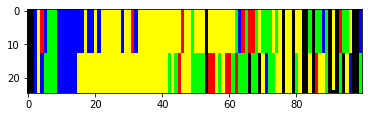

In [66]:
plt.imshow(out[0])

In [ ]:
def plot_loss_acc(lss, lss_t):
    fig,ax = plt.subplots()
    ax.plot(lss, label="train loss")
    ax.plot(lss_t, label = "test loss")
    #ax1 = ax.twinx()
    #ax1.plot(yacc, label = "train accuracy", ls='--')
    #ax1.plot(yacc_t, label = "test accuracy", ls='--')

    lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax1.get_legend_handles_labels()

    ax.legend(lines, labels)

In [ ]:
plot_loss_acc(lss, lss_t)

In [ ]:
plot_loss_acc(lss3, lss_t3, yacc3, yacc_t3)

In [ ]:
def plot_change_latent_var(diva, lat_space="y", var_idx=[0,1,2,3,4,5,6,7], step = 5):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:len(var_idx)].to(DEVICE).float()
        x = a[1][0][:len(var_idx)].to(DEVICE).float()
        y = a[1][1][:len(var_idx)].to(DEVICE).float()

        zx, zx_sc = diva.qzx(x)
        zy, zy_sc = diva.qzy(x)
        zd, zd_sc =  diva.qzd(x)

        print(torch.max(zy), torch.min(zy), "sdmax:", torch.max(zy_sc))

        out = change(zx, zy, zd, var_idx, lat_space, diva, step)
    
    fig, ax = plt.subplots(ncols=out.shape[0],nrows=len(var_idx),figsize=(10*4*out.shape[0],10*len(var_idx)))
    for i in range(out.shape[0]):
      for j in range(len(var_idx)):
        ax[j,i].imshow(out[i,j])

In [ ]:
def change(zx, zy, zd, idx, lat = "y", model=diva, step = 2):
    
    dif = np.arange(-30,15,step)
    print(torch.max(zy), torch.min(zy))
    out = np.zeros((dif.shape[0], len(idx), 25, 100 ,3))  
    #print(zy.shape, dif.shape[0])
    for i in range(dif.shape[0]):
      for j in range(len(idx)):
        if lat == "y":
            zy[j,idx] = dif[i]
        elif lat == "x":
            zx[j,idx] = dif[i]
        elif lat == "d":
            zd[j,idx] = dif[i]
        len_, bar, col = model.px(zd[j],zx[j],zy[j])
        out[i,j] = model.px.reconstruct_image(len_[None,:], bar, col)
    
    return out



In [ ]:
plot_change_latent_var(diva)

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss2], label="train loss")
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss_t2], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(50,120), yacc2, label = "train")
ax1.plot(np.arange(50,120), yacc_t2, label = "test")

plt.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss3], label="train loss")
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss_t3], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(120,180), yacc3, label = "train",c='green')
ax1.plot(np.arange(120,180), yacc_t3, label = "test")

plt.legend()

# Model Evaluation

## Sampling from trained model

In [ ]:
def plot_latent_space(lat_space="y"):
    '''
    lat_space: y, d, x
    '''

    

In [ ]:
plot(x, out, 0)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x[i].cpu().permute(1,2,0))
  
plt.savefig('divastamporg.png')